# Testing different ML models to predict gene set scores from surface protein data

In this notebook different reggressors (RandomForestRegressor, GradientBoostingReggressor, CatBoostRegressor) are tested to predict gene set scores from CLR tranformed surface protein data. 

5 common clusters were found in Melsen and Yang (+Crinier) datasets; 

1. Proliferating NK cells
2. CD56dim GZMK-
3. CD56dim GZMK+ (transitional subset between CD56bright and CD56dim NK cells)
4. CD56bright
5. lymhoid tissue-resident NK cells (lt-NK)

Here, gene set for CD56dim GZMK+ NK cells is explored. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scvi
import scanpy as sc
import seaborn as sb


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#markers

#Proliferating
prolif = ['S100A4', 'S100A6', 'KLRC2', 'IL32', 'GZMH', 'GNLY']

#CD56dim GZMK-
cd56dim_gzmk_neg= ['S100A4', 'S100A6', 'ACTB', 'ACTG1', 'CORO1A', 'PFN1', 'GZMB'] #lower expression of GZMB in gzmk_pos cluster, so marker added in this gene set

#CD56dim GZMK+
cd56dim_gzmk_pos = ['GZMK', 'SELL']

#CD56bright
cd56bright= ['NCAM1', 'KIT', 'SELL', 'CD2', 'IL7R', 'KLRC1']
#cd56bright_prot= ['CD56', 'CD62L', "CD2_prot", 'CD127']  #CD117 ab not used in this dataset

#lt-NK
lt_nk= ['CCL3', 'CCL4', 'XCL1', 'GZMK', 'CD160', 'DUSP2', 'CXCR4', 'BTG1']


In [3]:
#loading Neurips dataset
adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [4]:
adata_neurips

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [5]:
adata_neurips.obs['Site'].unique().tolist()

['site4', 'site3', 'site1', 'site2']

In [6]:
#selecting only sites 1 and 4 (good ab signals), from Neurips dataset

eg=adata_neurips[(adata_neurips.obs['Site'] == "site4") | (adata_neurips.obs['Site'] == "site1")].copy() 

In [7]:
eg.obs['Site'].unique().tolist()

['site4', 'site1']

In [8]:
prot=eg.obsm['protein_expression_clr_neurips']

In [9]:
prot

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTCAAGAGTCACAGAG-1-s4d1  0.652674  1.069339  1.657770  0.890243  1.377072   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
CGTGATAGTTATCTGG-1-s4d1  0.000000  1.249182  1.335424  1.256332  2.674106   
AGATCCAAGATCGGTG-1-s4d1  2.784459  1.132949  1.674846  1.669058  1.663981   
...                           ...       ...       ...       ...       ...   
GTGGTTAGTCGAGTTT-1-s1d3  0.000000  0.175083  0.734526  0.000000  0.505917   
GCTACAACAGTGCGCT-1-s1d3  0.378666  0.453643  0.894450  0.000000  0.766577   
AACAAAGGTTGGTACT-1-s1d3  0.378666  0.324031  1.094684  0.306698  0.401377   
TGACAGTCATGGCTGC-1-s1d3  0.378666  0.764571  0.776968  0.306698  0.152401   
CTGGCAGGTCTCACGG-1-s1d3  0.000000  0.568367  0.965743  0.000000  0.401377   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTCAAGAGTCACAGAG-1-s4d1  1.264995  1.863027  1.101769  1.562259  1.072649   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
CGTGATAGTTATCTGG-1-s4d1  1.322314  0.289336  1.240123  1.397398  1.525053   
AGATCCAAGATCGGTG-1-s4d1  2.101246  2.112640  1.417276  1.884321  1.861734   
...                           ...       ...       ...       ...       ...   
GTGGTTAGTCGAGTTT-1-s1d3  1.235054  1.241451  0.512721  0.502246  1.766372   
GCTACAACAGTGCGCT-1-s1d3  1.058199  1.529611  0.512721  0.663922  1.766372   
AACAAAGGTTGGTACT-1-s1d3  1.983838  2.156735  0.512721  0.835018  2.400949   
TGACAGTCATGGCTGC-1-s1d3  1.358780  1.753042  0.201533  0.586348  1.543085   
CTGGCAGGTCTCACGG-1-s1d3  1.589583  1.935554  0.749707  0.700563  2.113165   

                         ...     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  ...  1.532575  0.614600  0.900688  1.389844   
CTCAAGAGTCACAGAG-1-s4d1  ...  1.283465  0.614600  1.786480  0.762359   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.344431  0.353792  0.860303  0.979461   
CGTGATAGTTATCTGG-1-s4d1  ...  0.859205  1.527772  0.629556  0.854928   
AGATCCAAGATCGGTG-1-s4d1  ...  1.429432  1.031029  2.808629  2.007436   
...                      ...       ...       ...       ...       ...   
GTGGTTAGTCGAGTTT-1-s1d3  ...  0.374154  0.425643  0.519947  0.484666   
GCTACAACAGTGCGCT-1-s1d3  ...  1.074485  0.100854  1.415230  0.854928   
AACAAAGGTTGGTACT-1-s1d3  ...  1.149104  1.324148  1.315806  0.605141   
TGACAGTCATGGCTGC-1-s1d3  ...  1.373575  0.276377  1.113769  0.660339   
CTGGCAGGTCTCACGG-1-s1d3  ...  1.401893  0.723263  0.939506  0.484666   

                            CD224  CD197  CD34  CD10  CD90  CD15  
GTAGTACCAATCCTTT-1-s4d1  0.918109    0.0   0.0   0.0   0.0   0.0  
CTCAAGAGTCACAGAG-1-s4d1  1.112478    0.0   0.0   0.0   0.0   0.0  
CTGTGGGTCATGCGGC-1-s4d1  1.147198    0.0   0.0   0.0   0.0   0.0  
CGTGATAGTTATCTGG-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
AGATCCAAGATCGGTG-1-s4d1  2.064066    0.0   0.0   0.0   0.0   0.0  
...                           ...    ...   ...   ...   ...   ...  
GTGGTTAGTCGAGTTT-1-s1d3  0.497623    0.0   0.0   0.0   0.0   0.0  
GCTACAACAGTGCGCT-1-s1d3  0.560915    0.0   0.0   0.0   0.0   0.0  
AACAAAGGTTGGTACT-1-s1d3  0.357584    0.0   0.0   0.0   0.0   0.0  
TGACAGTCATGGCTGC-1-s1d3  0.960123    0.0   0.0   0.0   0.0   0.0  
CTGGCAGGTCTCACGG-1-s1d3  0.357584    0.0   0.0   0.0   0.0   0.0  

[28418 rows x 139 columns]

In [10]:
prot=prot.rename(columns={'CD2': 'CD2_prot', 'CD224': 'CD224_prot', 'CD83': 'CD83_prot', 'HLA-E': 'HLA-E_prot', 'CX3CR1': 'CX3CR1_prot', 'CD52': 'CD52_prot','CD69': 'CD69_prot', 'CD226':'CD226_prot', 'CD47': 'CD47_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})

In [11]:
#some proteins and genes have same names, here _prot added after protein names

a = eg.obs
b = prot

adata_eg=pd.concat([a, b], axis=1)
eg.obs=adata_eg

In [12]:
eg

AnnData object with n_obs × n_vars = 28418 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47_prot', 'CD48', 'CD40', 'CD154', 'CD52_prot', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD1

In [13]:
#selecting only NK cells, gd T cells and ILCs using Neurips annotations

eg_nk = eg[(eg.obs['cell_type'] == "NK") | (eg.obs['cell_type'] == "NK CD158e1+")].copy()   


In [14]:
eg_nk.obs['cell_type'].unique().tolist()

['NK', 'NK CD158e1+']

In [15]:
#This includes now selected cells (NK, ILC, gd T) from site 1 and 4
eg_nk

AnnData object with n_obs × n_vars = 2640 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47_prot', 'CD48', 'CD40', 'CD154', 'CD52_prot', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16

## Calculating gene scores for gene sets

In [16]:
markers = cd56dim_gzmk_pos

In [17]:
markers

['GZMK', 'SELL']

In [18]:
#calculating scores for gene set

sc.tl.score_genes(eg_nk, markers, score_name = 'marker_score')

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [19]:
eg_nk.obs['marker_score']

GTAGTACCAATCCTTT-1-s4d1   -0.179350
CTGTGGGTCATGCGGC-1-s4d1   -0.265476
GCAACATTCGCAAGAG-1-s4d1   -0.198235
TCACGGGTCGCACGAC-1-s4d1   -0.340324
CGCCAGAAGACCATTC-1-s4d1   -0.215448
                             ...   
ATCATTCGTCCAATCA-1-s1d3   -0.326286
ACATTTCCAGCAGTGA-1-s1d3    0.389041
TGAGACTTCCTTCAGC-1-s1d3   -0.215462
GAGATGGTCCGCCTAT-1-s1d3   -0.428599
ACCTGTCTCACAGTGT-1-s1d3    1.374571
Name: marker_score, Length: 2640, dtype: float64

In [20]:
prot = eg_nk.obsm['protein_expression_clr_neurips']

In [21]:
prot

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
GCAACATTCGCAAGAG-1-s4d1  0.378666  1.192753  1.208881  0.000000  1.456877   
TCACGGGTCGCACGAC-1-s4d1  0.000000  0.849902  1.548700  0.730824  1.530781   
CGCCAGAAGACCATTC-1-s4d1  0.652674  1.249182  1.404314  0.306698  1.417770   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.000000  0.568367  1.124479  1.027708  0.600556   
ACATTTCCAGCAGTGA-1-s1d3  0.000000  0.671273  0.856802  0.000000  0.284617   
TGAGACTTCCTTCAGC-1-s1d3  0.000000  0.671273  0.734526  0.306698  0.284617   
GAGATGGTCCGCCTAT-1-s1d3  0.000000  0.928521  0.999570  0.541080  0.600556   
ACCTGTCTCACAGTGT-1-s1d3  0.652674  0.175083  0.856802  0.000000  0.284617   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
GCAACATTCGCAAGAG-1-s4d1  1.046035  1.333993  0.638218  1.360894  1.072649   
TCACGGGTCGCACGAC-1-s4d1  1.883102  1.686271  1.240123  1.804089  0.812797   
CGCCAGAAGACCATTC-1-s4d1  1.664855  1.409627  1.302726  1.663363  0.849218   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  2.007513  1.679342  0.749707  0.545181  0.288523   
ACATTTCCAGCAGTGA-1-s1d3  1.105431  0.818721  0.201533  0.309292  0.652195   
TGAGACTTCCTTCAGC-1-s1d3  1.255114  1.174628  0.749707  0.625887  0.406586   
GAGATGGTCCGCCTAT-1-s1d3  1.759143  2.420602  1.024682  0.700563  0.406586   
ACCTGTCTCACAGTGT-1-s1d3  1.193686  0.866867  0.512721  0.457384  0.775000   

                         ...     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  ...  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  ...  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  ...  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  ...  1.556781  0.276377  0.680162  1.415407   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  ...  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  ...  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  ...  0.758186  0.276377  0.396827  0.418509   

                            CD224  CD197  CD34  CD10  CD90  CD15  
GTAGTACCAATCCTTT-1-s4d1  0.918109    0.0   0.0   0.0   0.0   0.0  
CTGTGGGTCATGCGGC-1-s4d1  1.147198    0.0   0.0   0.0   0.0   0.0  
GCAACATTCGCAAGAG-1-s4d1  0.676616    0.0   0.0   0.0   0.0   0.0  
TCACGGGTCGCACGAC-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
CGCCAGAAGACCATTC-1-s4d1  0.729806    0.0   0.0   0.0   0.0   0.0  
...                           ...    ...   ...   ...   ...   ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584    0.0   0.0   0.0   0.0   0.0  
ACATTTCCAGCAGTGA-1-s1d3  0.194691    0.0   0.0   0.0   0.0   0.0  
TGAGACTTCCTTCAGC-1-s1d3  0.000000    0.0   0.0   0.0   0.0   0.0  
GAGATGGTCCGCCTAT-1-s1d3  0.430053    0.0   0.0   0.0   0.0   0.0  
ACCTGTCTCACAGTGT-1-s1d3  0.780309    0.0   0.0   0.0   0.0   0.0  

[2640 rows x 139 columns]

In [22]:
#dropping columns containing only zeros

prot = prot.loc[:, (prot!=0).any(axis=0)]

In [23]:
prot

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
GCAACATTCGCAAGAG-1-s4d1  0.378666  1.192753  1.208881  0.000000  1.456877   
TCACGGGTCGCACGAC-1-s4d1  0.000000  0.849902  1.548700  0.730824  1.530781   
CGCCAGAAGACCATTC-1-s4d1  0.652674  1.249182  1.404314  0.306698  1.417770   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.000000  0.568367  1.124479  1.027708  0.600556   
ACATTTCCAGCAGTGA-1-s1d3  0.000000  0.671273  0.856802  0.000000  0.284617   
TGAGACTTCCTTCAGC-1-s1d3  0.000000  0.671273  0.734526  0.306698  0.284617   
GAGATGGTCCGCCTAT-1-s1d3  0.000000  0.928521  0.999570  0.541080  0.600556   
ACCTGTCTCACAGTGT-1-s1d3  0.652674  0.175083  0.856802  0.000000  0.284617   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
GCAACATTCGCAAGAG-1-s4d1  1.046035  1.333993  0.638218  1.360894  1.072649   
TCACGGGTCGCACGAC-1-s4d1  1.883102  1.686271  1.240123  1.804089  0.812797   
CGCCAGAAGACCATTC-1-s4d1  1.664855  1.409627  1.302726  1.663363  0.849218   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  2.007513  1.679342  0.749707  0.545181  0.288523   
ACATTTCCAGCAGTGA-1-s1d3  1.105431  0.818721  0.201533  0.309292  0.652195   
TGAGACTTCCTTCAGC-1-s1d3  1.255114  1.174628  0.749707  0.625887  0.406586   
GAGATGGTCCGCCTAT-1-s1d3  1.759143  2.420602  1.024682  0.700563  0.406586   
ACCTGTCTCACAGTGT-1-s1d3  1.193686  0.866867  0.512721  0.457384  0.775000   

                         ...      CD94     CD162     CD85j      CD23  \
GTAGTACCAATCCTTT-1-s4d1  ...  2.475005  1.804603  1.069921  1.496785   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.408073  1.772872  0.890506  1.188863   
GCAACATTCGCAAGAG-1-s4d1  ...  2.174035  1.013704  1.148843  1.332566   
TCACGGGTCGCACGAC-1-s4d1  ...  3.016060  1.587440  1.623280  1.552023   
CGCCAGAAGACCATTC-1-s4d1  ...  2.826218  2.465725  1.524077  1.637802   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  4.481286  2.345961  0.391222  0.700530   
ACATTTCCAGCAGTGA-1-s1d3  ...  2.122566  1.496074  0.391222  0.410393   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.365443  1.296756  0.214622  0.410393   
GAGATGGTCCGCCTAT-1-s1d3  ...  2.986818  1.976363  0.214622  0.990050   
ACCTGTCTCACAGTGT-1-s1d3  ...  4.033146  2.040049  0.541266  0.226103   

                            CD328     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  2.696518  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  2.678422  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  0.000000  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  2.164676  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  3.066941  1.556781  0.276377  0.680162  1.415407   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  4.391692  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  2.678422  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  3.910620  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  1.800479  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  3.336630  0.758186  0.276377  0.396827  0.418509   

                            CD224  
GTAGTACCAATCCTTT-1-s4d1  0.918109  
CTGTGGGTCATGCGGC-1-s4d1  1.147198  
GCAACATTCGCAAGAG-1-s4d1  0.676616  
TCACGGGTCGCACGAC-1-s4d1  1.000442  
CGCCAGAAGACCATTC-1-s4d1  0.729806  
...                           ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584  
ACATTTCCAGCAGTGA-1-s1d3  0.194691  
TGAGACTTCCTTCAGC-1-s1d3  0.000000  
GAGATGGTCCGCCTAT-1-s1d3  0.43

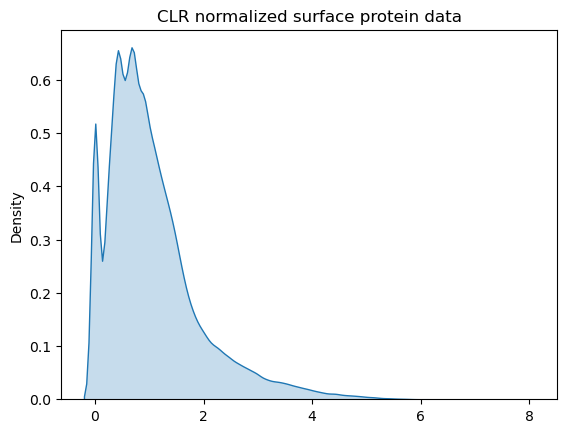

In [24]:
flatten_df = prot.to_numpy().flatten()

sb.kdeplot(flatten_df, fill = True) ; 


plt.title("CLR normalized surface protein data") ;

In [25]:
score_yang = eg_nk.obs['marker_score']

In [26]:
score_yang

GTAGTACCAATCCTTT-1-s4d1   -0.179350
CTGTGGGTCATGCGGC-1-s4d1   -0.265476
GCAACATTCGCAAGAG-1-s4d1   -0.198235
TCACGGGTCGCACGAC-1-s4d1   -0.340324
CGCCAGAAGACCATTC-1-s4d1   -0.215448
                             ...   
ATCATTCGTCCAATCA-1-s1d3   -0.326286
ACATTTCCAGCAGTGA-1-s1d3    0.389041
TGAGACTTCCTTCAGC-1-s1d3   -0.215462
GAGATGGTCCGCCTAT-1-s1d3   -0.428599
ACCTGTCTCACAGTGT-1-s1d3    1.374571
Name: marker_score, Length: 2640, dtype: float64

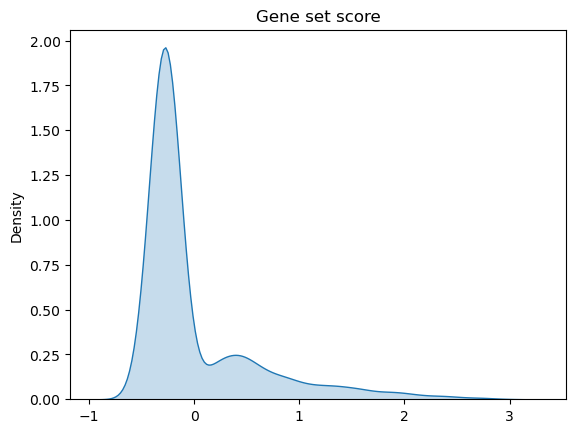

In [27]:
flatten_df1 = score_yang.to_numpy().flatten()

sb.kdeplot(flatten_df1, fill = True) ; 

plt.title("Gene set score") ;

In [28]:
#Creating df containign surface protein data + scores for gene sets

a = score_yang
b = prot

df =pd.concat([a, b], axis=1)


In [29]:
df

marker_score      CD86     CD274     CD270     CD155  \
GTAGTACCAATCCTTT-1-s4d1     -0.179350  0.652674  1.447594  1.489354  0.890243   
CTGTGGGTCATGCGGC-1-s4d1     -0.265476  0.378666  1.132949  1.153412  0.730824   
GCAACATTCGCAAGAG-1-s4d1     -0.198235  0.378666  1.192753  1.208881  0.000000   
TCACGGGTCGCACGAC-1-s4d1     -0.340324  0.000000  0.849902  1.548700  0.730824   
CGCCAGAAGACCATTC-1-s4d1     -0.215448  0.652674  1.249182  1.404314  0.306698   
...                               ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3     -0.326286  0.000000  0.568367  1.124479  1.027708   
ACATTTCCAGCAGTGA-1-s1d3      0.389041  0.000000  0.671273  0.856802  0.000000   
TGAGACTTCCTTCAGC-1-s1d3     -0.215462  0.000000  0.671273  0.734526  0.306698   
GAGATGGTCCGCCTAT-1-s1d3     -0.428599  0.000000  0.928521  0.999570  0.541080   
ACCTGTCTCACAGTGT-1-s1d3      1.374571  0.652674  0.175083  0.856802  0.000000   

                            CD112      CD47      CD48      CD40     CD154  \
GTAGTACCAATCCTTT-1-s4d1  1.290341  1.988618  1.733474  0.850004  1.531390   
CTGTGGGTCATGCGGC-1-s4d1  1.195368  1.546005  1.090567  1.173337  1.303511   
GCAACATTCGCAAGAG-1-s4d1  1.456877  1.046035  1.333993  0.638218  1.360894   
TCACGGGTCGCACGAC-1-s4d1  1.530781  1.883102  1.686271  1.240123  1.804089   
CGCCAGAAGACCATTC-1-s4d1  1.417770  1.664855  1.409627  1.302726  1.663363   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.600556  2.007513  1.679342  0.749707  0.545181   
ACATTTCCAGCAGTGA-1-s1d3  0.284617  1.105431  0.818721  0.201533  0.309292   
TGAGACTTCCTTCAGC-1-s1d3  0.284617  1.255114  1.174628  0.749707  0.625887   
GAGATGGTCCGCCTAT-1-s1d3  0.600556  1.759143  2.420602  1.024682  0.700563   
ACCTGTCTCACAGTGT-1-s1d3  0.284617  1.193686  0.866867  0.512721  0.457384   

                         ...      CD94     CD162     CD85j      CD23  \
GTAGTACCAATCCTTT-1-s4d1  ...  2.475005  1.804603  1.069921  1.496785   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.408073  1.772872  0.890506  1.188863   
GCAACATTCGCAAGAG-1-s4d1  ...  2.174035  1.013704  1.148843  1.332566   
TCACGGGTCGCACGAC-1-s4d1  ...  3.016060  1.587440  1.623280  1.552023   
CGCCAGAAGACCATTC-1-s4d1  ...  2.826218  2.465725  1.524077  1.637802   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  4.481286  2.345961  0.391222  0.700530   
ACATTTCCAGCAGTGA-1-s1d3  ...  2.122566  1.496074  0.391222  0.410393   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.365443  1.296756  0.214622  0.410393   
GAGATGGTCCGCCTAT-1-s1d3  ...  2.986818  1.976363  0.214622  0.990050   
ACCTGTCTCACAGTGT-1-s1d3  ...  4.033146  2.040049  0.541266  0.226103   

                            CD328     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  2.696518  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  2.678422  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  0.000000  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  2.164676  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  3.066941  1.556781  0.276377  0.680162  1.415407   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  4.391692  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  2.678422  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  3.910620  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  1.800479  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  3.336630  0.758186  0.276377  0.396827  0.418509   

                            CD224  
GTAGTACCAATCCTTT-1-s4d1  0.918109  
CTGTGGGTCATGCGGC-1-s4d1  1.147198  
GCAACATTCGCAAGAG-1-s4d1  0.676616  
TCACGGGTCGCACGAC-1-s4d1  1.000442  
CGCCAGAAGACCATTC-1-s4d1  0.729806  
...                           ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584  
ACATTTCCAGCAGTGA-1-s1d3  0.194691  
TGAGACTTCCTTC

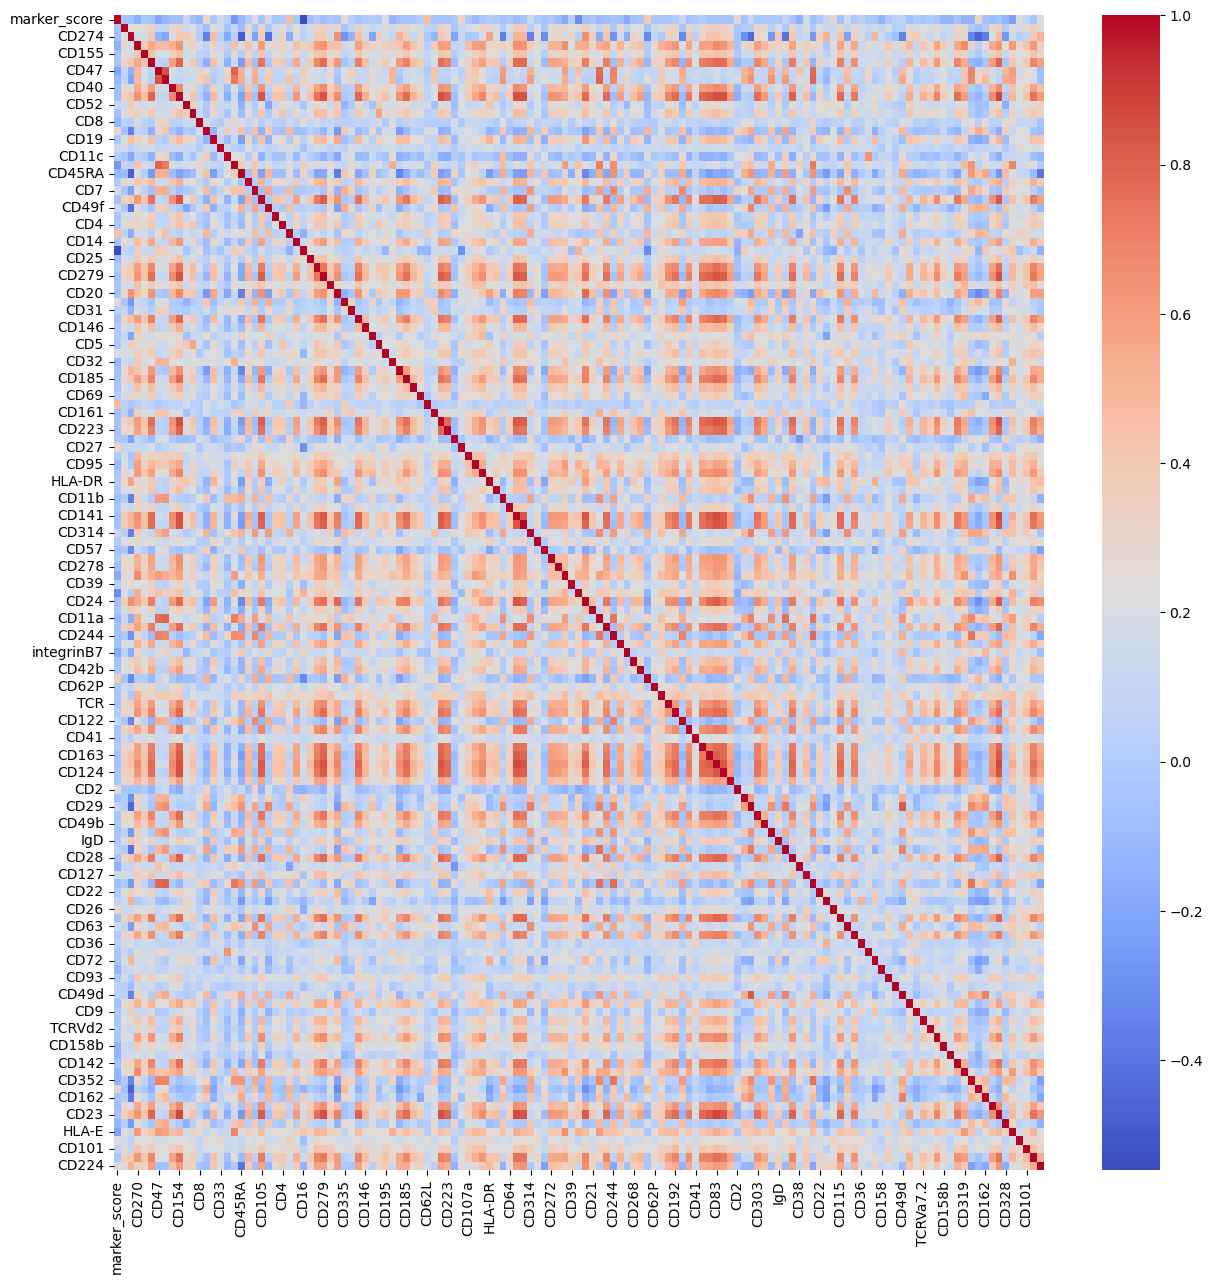

In [30]:
plt.figure(figsize=(15,15))
sb.heatmap(data=df.corr(),cmap='coolwarm')
plt.show()

In [31]:
df

marker_score      CD86     CD274     CD270     CD155  \
GTAGTACCAATCCTTT-1-s4d1     -0.179350  0.652674  1.447594  1.489354  0.890243   
CTGTGGGTCATGCGGC-1-s4d1     -0.265476  0.378666  1.132949  1.153412  0.730824   
GCAACATTCGCAAGAG-1-s4d1     -0.198235  0.378666  1.192753  1.208881  0.000000   
TCACGGGTCGCACGAC-1-s4d1     -0.340324  0.000000  0.849902  1.548700  0.730824   
CGCCAGAAGACCATTC-1-s4d1     -0.215448  0.652674  1.249182  1.404314  0.306698   
...                               ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3     -0.326286  0.000000  0.568367  1.124479  1.027708   
ACATTTCCAGCAGTGA-1-s1d3      0.389041  0.000000  0.671273  0.856802  0.000000   
TGAGACTTCCTTCAGC-1-s1d3     -0.215462  0.000000  0.671273  0.734526  0.306698   
GAGATGGTCCGCCTAT-1-s1d3     -0.428599  0.000000  0.928521  0.999570  0.541080   
ACCTGTCTCACAGTGT-1-s1d3      1.374571  0.652674  0.175083  0.856802  0.000000   

                            CD112      CD47      CD48      CD40     CD154  \
GTAGTACCAATCCTTT-1-s4d1  1.290341  1.988618  1.733474  0.850004  1.531390   
CTGTGGGTCATGCGGC-1-s4d1  1.195368  1.546005  1.090567  1.173337  1.303511   
GCAACATTCGCAAGAG-1-s4d1  1.456877  1.046035  1.333993  0.638218  1.360894   
TCACGGGTCGCACGAC-1-s4d1  1.530781  1.883102  1.686271  1.240123  1.804089   
CGCCAGAAGACCATTC-1-s4d1  1.417770  1.664855  1.409627  1.302726  1.663363   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.600556  2.007513  1.679342  0.749707  0.545181   
ACATTTCCAGCAGTGA-1-s1d3  0.284617  1.105431  0.818721  0.201533  0.309292   
TGAGACTTCCTTCAGC-1-s1d3  0.284617  1.255114  1.174628  0.749707  0.625887   
GAGATGGTCCGCCTAT-1-s1d3  0.600556  1.759143  2.420602  1.024682  0.700563   
ACCTGTCTCACAGTGT-1-s1d3  0.284617  1.193686  0.866867  0.512721  0.457384   

                         ...      CD94     CD162     CD85j      CD23  \
GTAGTACCAATCCTTT-1-s4d1  ...  2.475005  1.804603  1.069921  1.496785   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.408073  1.772872  0.890506  1.188863   
GCAACATTCGCAAGAG-1-s4d1  ...  2.174035  1.013704  1.148843  1.332566   
TCACGGGTCGCACGAC-1-s4d1  ...  3.016060  1.587440  1.623280  1.552023   
CGCCAGAAGACCATTC-1-s4d1  ...  2.826218  2.465725  1.524077  1.637802   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  4.481286  2.345961  0.391222  0.700530   
ACATTTCCAGCAGTGA-1-s1d3  ...  2.122566  1.496074  0.391222  0.410393   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.365443  1.296756  0.214622  0.410393   
GAGATGGTCCGCCTAT-1-s1d3  ...  2.986818  1.976363  0.214622  0.990050   
ACCTGTCTCACAGTGT-1-s1d3  ...  4.033146  2.040049  0.541266  0.226103   

                            CD328     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  2.696518  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  2.678422  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  0.000000  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  2.164676  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  3.066941  1.556781  0.276377  0.680162  1.415407   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  4.391692  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  2.678422  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  3.910620  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  1.800479  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  3.336630  0.758186  0.276377  0.396827  0.418509   

                            CD224  
GTAGTACCAATCCTTT-1-s4d1  0.918109  
CTGTGGGTCATGCGGC-1-s4d1  1.147198  
GCAACATTCGCAAGAG-1-s4d1  0.676616  
TCACGGGTCGCACGAC-1-s4d1  1.000442  
CGCCAGAAGACCATTC-1-s4d1  0.729806  
...                           ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584  
ACATTTCCAGCAGTGA-1-s1d3  0.194691  
TGAGACTTCCTTC

## 1. RandomForestRegressor

In [32]:
#Random forest

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params = {#'bootstrap': [True, False],
 'max_depth': [3,5,7],
 #'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
 'min_samples_leaf': [2, 5, 10],
 #'min_samples_split': [2, 5, 10] ,
 #'n_estimators': [10, 50, 100]
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(RandomForestRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)
    

Mean squared error: 0.12 R2 score: 0.61


In [33]:
#Mean training scores

print(mean_train_score)

[array([-0.13045481, -0.13055266, -0.13085356, -0.08782996, -0.09043908,
       -0.09887084, -0.06353924, -0.07068896, -0.08782569])]


In [34]:
# The best score and parameters

print(result.best_score_)
print(result.best_params_)

-0.13961529716387064
{'max_depth': 7, 'min_samples_leaf': 5}


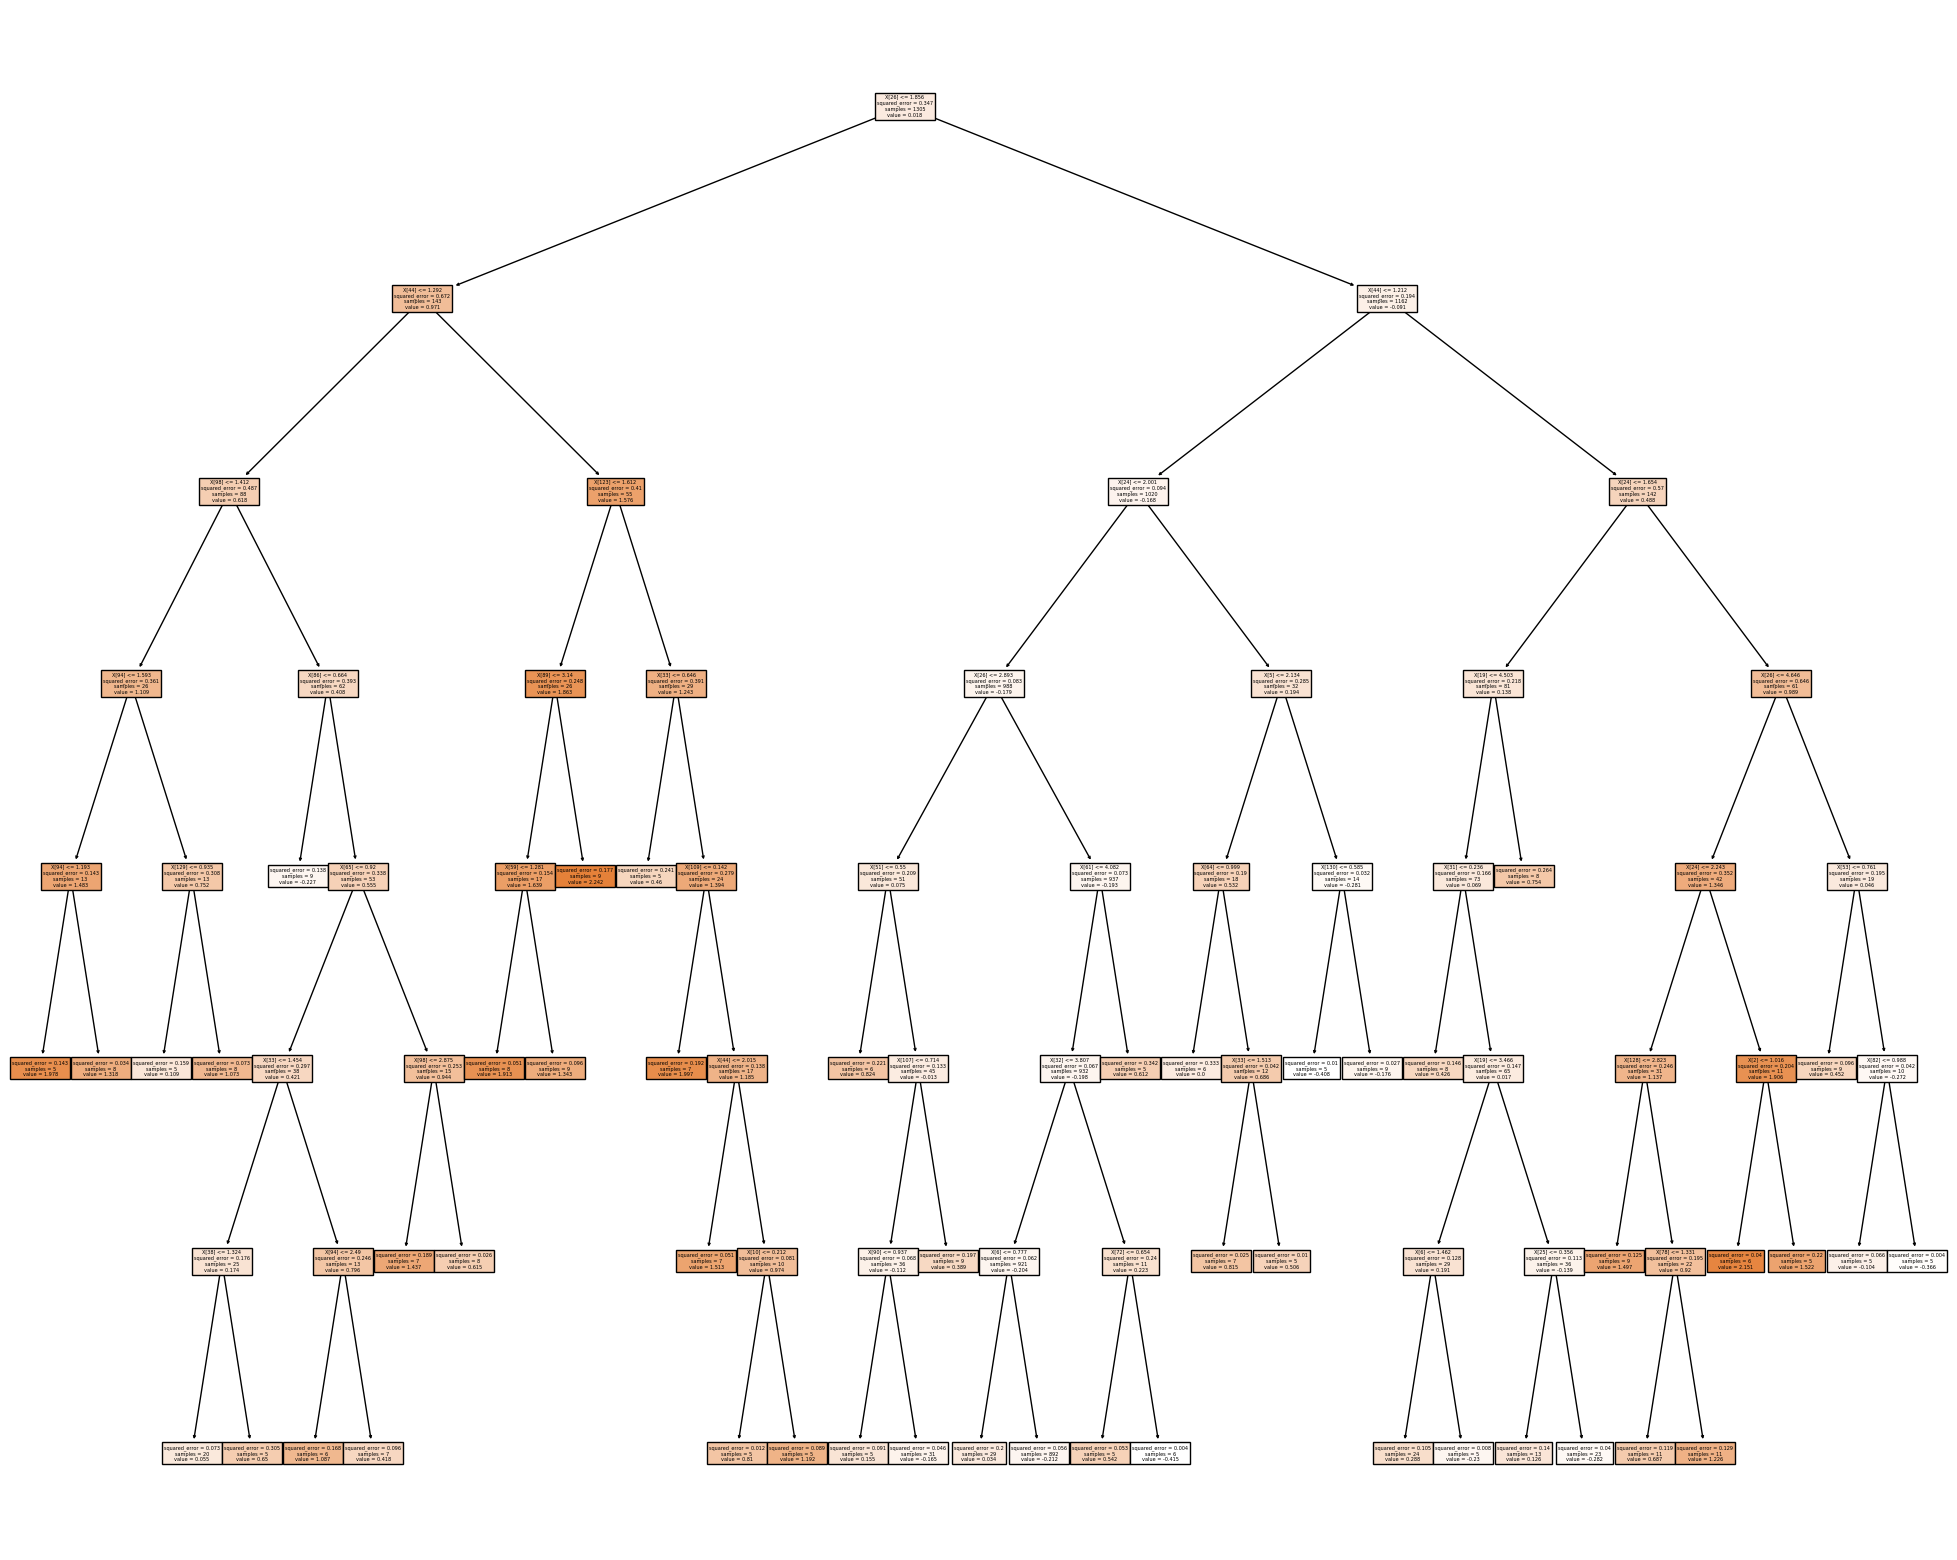

In [35]:
from sklearn import tree

plt.figure(figsize=(25, 20)) # Resize figure
tree.plot_tree(best_model.estimators_[0], filled = True) ;

plt.show()

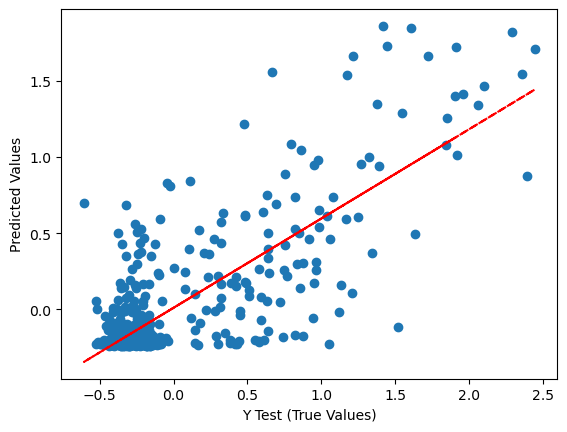

In [36]:
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.show()

<AxesSubplot: xlabel='marker_score', ylabel='Density'>

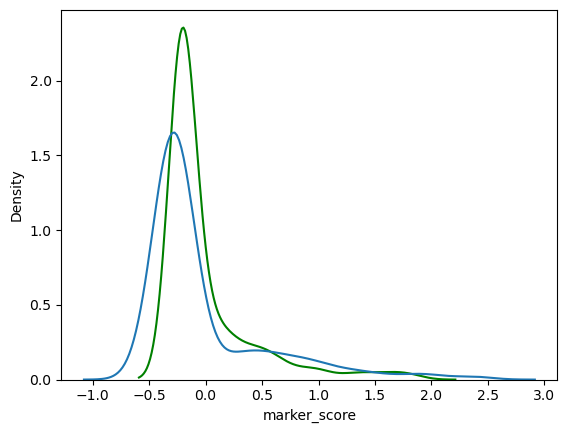

In [37]:
sb.kdeplot(y_pred, color = "g") #predicted values
sb.kdeplot(y_test) #observed values

In [38]:
#Feature importances

importances_rf = best_model.feature_importances_
importances_rf = pd.Series(importances_rf, index=prot.columns)
importances_rf=importances_rf.sort_values(ascending=False)

print(importances_rf.head(10))

CD16     0.425047
CD62L    0.173280
CD44     0.093341
CD56     0.016483
CD54     0.016433
CD27     0.011755
CD94     0.011741
CD81     0.011307
CD38     0.009985
CD2      0.008843
dtype: float64


In [39]:
#df from the top 20 important markers
importances_rf=pd.DataFrame(importances_rf)
importances_rf_top=importances_rf[0:20]
importances_rf_top=importances_rf_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


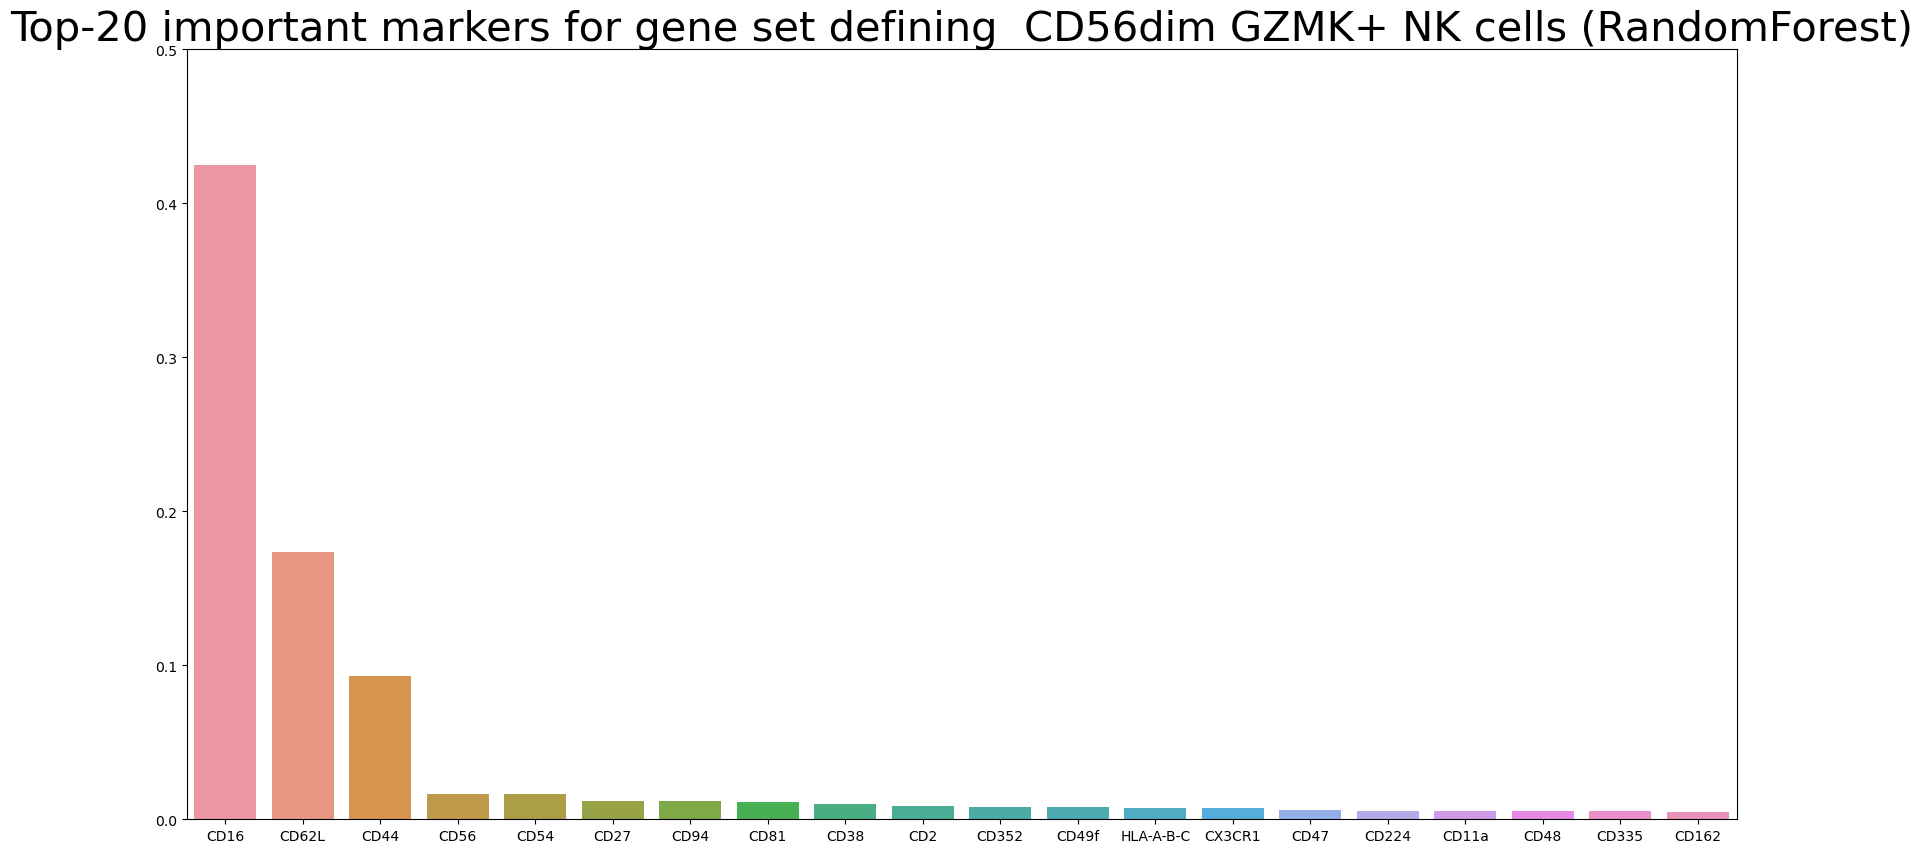

In [56]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.5)
a=sb.barplot(data=importances_rf_top)

plt.title("Top-20 important markers for gene set defining  CD56dim GZMK+ NK cells (RandomForest)", fontsize = 30) ;


## 2. Dummy Reggressor

In [41]:
from sklearn.dummy import DummyRegressor

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params =  {'strategy': ["mean", "median"]}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(DummyRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_dummy = result.best_estimator_
y_pred = best_model_dummy.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.30 R2 score: -0.00


In [42]:
print(mean_train_score)

[array([-0.34141561, -0.40242825])]


## 3. GragientBoostingRegressor

In [43]:
#Gradient boosting regressor

from sklearn.ensemble import GradientBoostingRegressor

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params =  {'max_depth': [3,5,7],
          'min_samples_leaf': [2, 5, 10]}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(GradientBoostingRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_gbr = result.best_estimator_
y_pred = best_model_gbr.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.11 R2 score: 0.63


In [44]:
print(mean_train_score)

[array([-0.06296863, -0.06377088, -0.06567454, -0.01657322, -0.01755036,
       -0.02280478, -0.00196612, -0.00281305, -0.00667294])]


<AxesSubplot: xlabel='marker_score', ylabel='Density'>

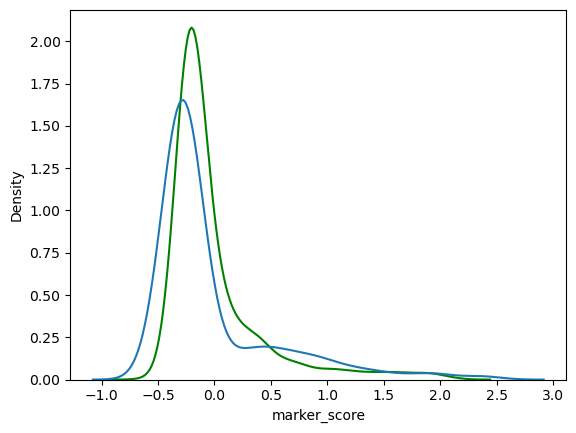

In [45]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [46]:
importances_gbr = best_model_gbr.feature_importances_
importances_gbr = pd.Series(importances_gbr, index=prot.columns)
importances_gbr=importances_gbr.sort_values(ascending=False)

print(importances_gbr.head(10))

CD16         0.424623
CD62L        0.156956
CD44         0.119068
CD56         0.032254
CD81         0.019115
HLA-A-B-C    0.015046
CD94         0.013587
CD48         0.012952
CD2          0.012633
CD27         0.012473
dtype: float64


In [47]:
#df from the top 20 important markers
importances_gbr=pd.DataFrame(importances_gbr)
importances_gbr_top=importances_gbr[0:20]
importances_gbr_top=importances_gbr_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


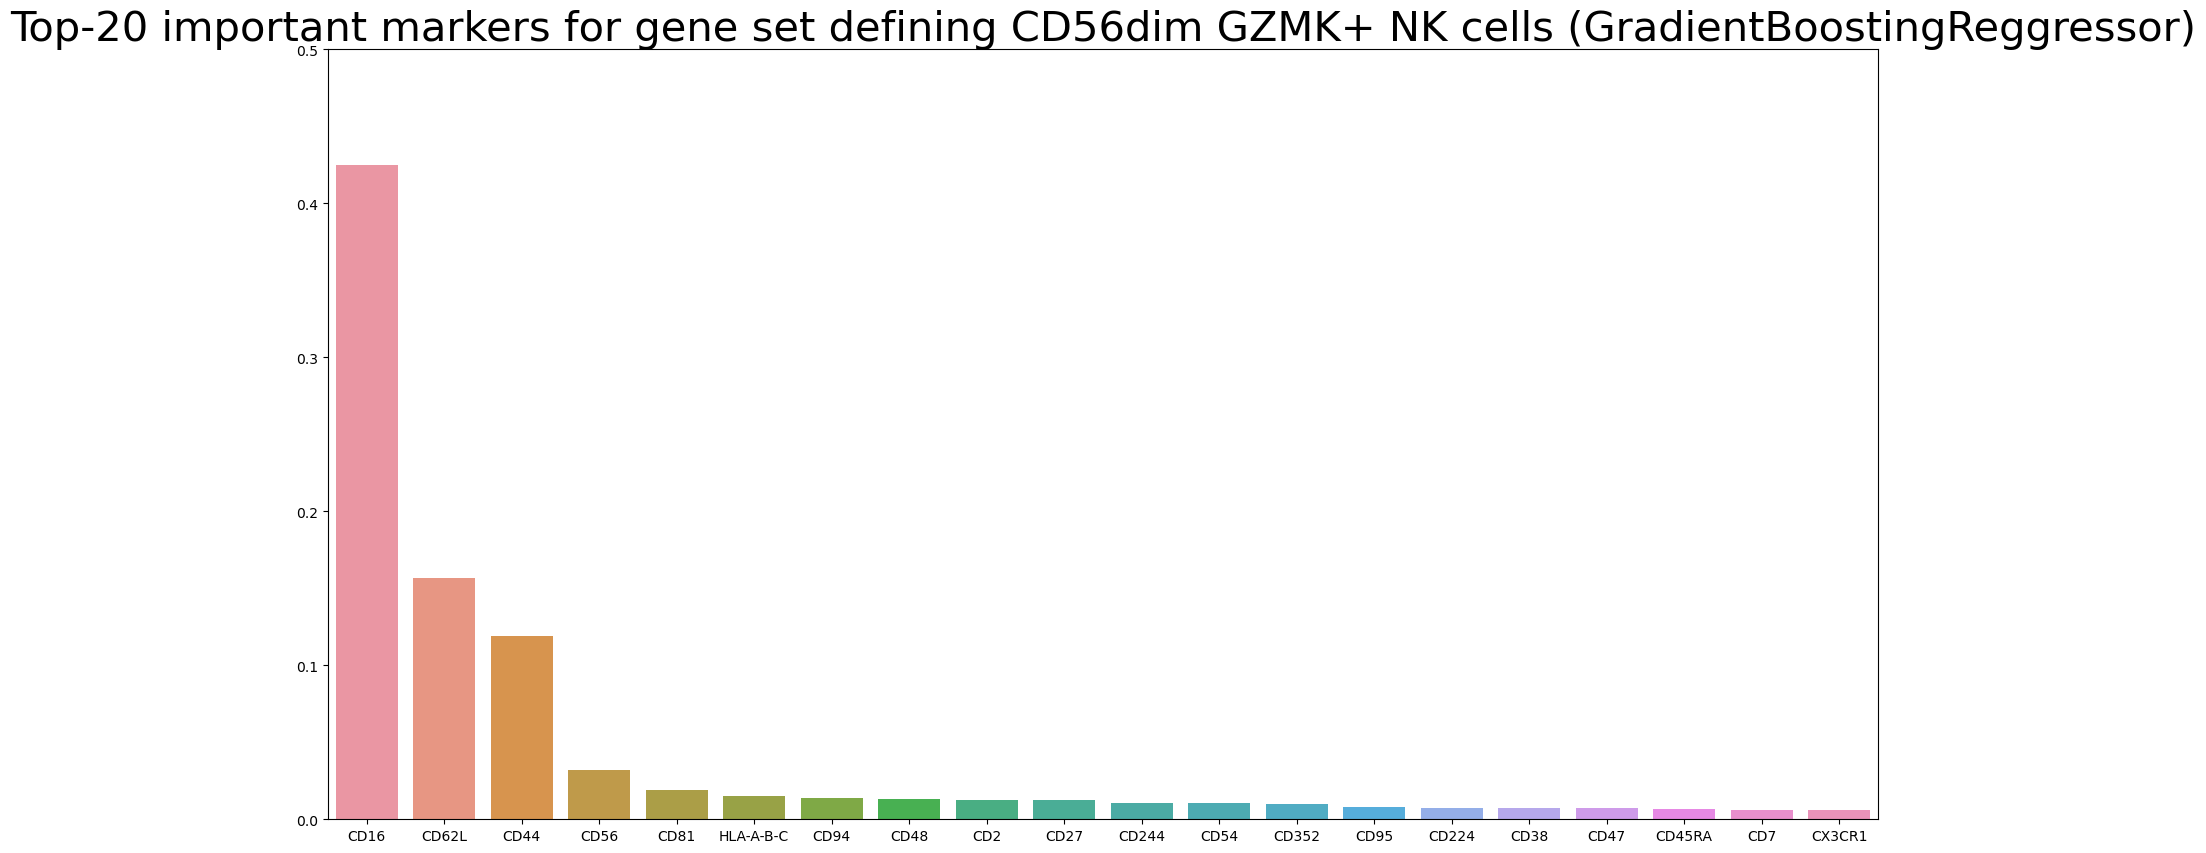

In [57]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.5)
a=sb.barplot(data=importances_gbr_top)

plt.title("Top-20 important markers for gene set defining CD56dim GZMK+ NK cells (GradientBoostingReggressor)", fontsize = 30) ;



## 4. CatBoostRegressor

In [32]:
from catboost import CatBoostRegressor

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params= {'depth': [6,8,10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations'    : [30, 50, 100]
                 }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(CatBoostRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_cb = result.best_estimator_
y_pred = best_model_cb.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

0:	learn: 0.5787357	total: 64.1ms	remaining: 1.86s
1:	learn: 0.5761544	total: 66.9ms	remaining: 936ms
2:	learn: 0.5736812	total: 69.4ms	remaining: 625ms
3:	learn: 0.5711383	total: 72ms	remaining: 468ms
4:	learn: 0.5683564	total: 74.4ms	remaining: 372ms
5:	learn: 0.5655953	total: 76.7ms	remaining: 307ms
6:	learn: 0.5626847	total: 79ms	remaining: 260ms
7:	learn: 0.5602354	total: 81.4ms	remaining: 224ms
8:	learn: 0.5578200	total: 83.8ms	remaining: 196ms
9:	learn: 0.5554870	total: 86.9ms	remaining: 174ms
10:	learn: 0.5532061	total: 89.1ms	remaining: 154ms
11:	learn: 0.5507085	total: 91.8ms	remaining: 138ms
12:	learn: 0.5484141	total: 94ms	remaining: 123ms
13:	learn: 0.5459596	total: 96.1ms	remaining: 110ms
14:	learn: 0.5437102	total: 99ms	remaining: 99ms
15:	learn: 0.5413021	total: 101ms	remaining: 88.6ms
16:	learn: 0.5388675	total: 104ms	remaining: 79.3ms
17:	learn: 0.5366184	total: 106ms	remaining: 70.6ms
18:	learn: 0.5346296	total: 108ms	remaining: 62.6ms
19:	learn: 0.5324840	total: 110

0:	learn: 0.5783524	total: 2.79ms	remaining: 80.8ms
1:	learn: 0.5758346	total: 5.8ms	remaining: 81.3ms
2:	learn: 0.5734008	total: 9.43ms	remaining: 84.9ms
3:	learn: 0.5709019	total: 12.3ms	remaining: 80.1ms
4:	learn: 0.5681515	total: 15.1ms	remaining: 75.6ms
5:	learn: 0.5654433	total: 18.6ms	remaining: 74.2ms
6:	learn: 0.5625337	total: 21.9ms	remaining: 72.1ms
7:	learn: 0.5600428	total: 25.2ms	remaining: 69.2ms
8:	learn: 0.5576646	total: 28.1ms	remaining: 65.6ms
9:	learn: 0.5550914	total: 31ms	remaining: 61.9ms
10:	learn: 0.5528488	total: 34.4ms	remaining: 59.4ms
11:	learn: 0.5503780	total: 37.9ms	remaining: 56.9ms
12:	learn: 0.5481402	total: 43.1ms	remaining: 56.4ms
13:	learn: 0.5457503	total: 46.5ms	remaining: 53.1ms
14:	learn: 0.5434703	total: 49ms	remaining: 49ms
15:	learn: 0.5412286	total: 51.4ms	remaining: 45ms
16:	learn: 0.5389541	total: 54.1ms	remaining: 41.4ms
17:	learn: 0.5368010	total: 57.1ms	remaining: 38ms
18:	learn: 0.5347043	total: 59.8ms	remaining: 34.6ms
19:	learn: 0.5

0:	learn: 0.5710721	total: 3.54ms	remaining: 103ms
1:	learn: 0.5586538	total: 6.52ms	remaining: 91.3ms
2:	learn: 0.5477698	total: 9.14ms	remaining: 82.3ms
3:	learn: 0.5361404	total: 11.9ms	remaining: 77.6ms
4:	learn: 0.5254725	total: 15.3ms	remaining: 76.6ms
5:	learn: 0.5155673	total: 18.7ms	remaining: 74.7ms
6:	learn: 0.5041259	total: 21.1ms	remaining: 69.3ms
7:	learn: 0.4952754	total: 23.7ms	remaining: 65ms
8:	learn: 0.4868184	total: 26.7ms	remaining: 62.4ms
9:	learn: 0.4785439	total: 29.2ms	remaining: 58.4ms
10:	learn: 0.4715817	total: 31.7ms	remaining: 54.7ms
11:	learn: 0.4641886	total: 34ms	remaining: 51ms
12:	learn: 0.4573518	total: 36.8ms	remaining: 48.2ms
13:	learn: 0.4519537	total: 39.2ms	remaining: 44.9ms
14:	learn: 0.4457973	total: 41.7ms	remaining: 41.7ms
15:	learn: 0.4403780	total: 44.2ms	remaining: 38.6ms
16:	learn: 0.4353433	total: 46.5ms	remaining: 35.6ms
17:	learn: 0.4303033	total: 49.2ms	remaining: 32.8ms
18:	learn: 0.4255686	total: 51.7ms	remaining: 29.9ms
19:	learn:

10:	learn: 0.4675063	total: 27.8ms	remaining: 48.1ms
11:	learn: 0.4596417	total: 30.4ms	remaining: 45.5ms
12:	learn: 0.4525076	total: 32.8ms	remaining: 43ms
13:	learn: 0.4454242	total: 35.6ms	remaining: 40.7ms
14:	learn: 0.4393173	total: 38.5ms	remaining: 38.5ms
15:	learn: 0.4335527	total: 41.2ms	remaining: 36ms
16:	learn: 0.4276896	total: 44.1ms	remaining: 33.7ms
17:	learn: 0.4226928	total: 47.2ms	remaining: 31.5ms
18:	learn: 0.4181656	total: 49.8ms	remaining: 28.8ms
19:	learn: 0.4135634	total: 52.6ms	remaining: 26.3ms
20:	learn: 0.4097862	total: 55ms	remaining: 23.6ms
21:	learn: 0.4056179	total: 57.7ms	remaining: 21ms
22:	learn: 0.4012469	total: 60.4ms	remaining: 18.4ms
23:	learn: 0.3967962	total: 63.2ms	remaining: 15.8ms
24:	learn: 0.3929877	total: 66.1ms	remaining: 13.2ms
25:	learn: 0.3893194	total: 68.8ms	remaining: 10.6ms
26:	learn: 0.3853706	total: 71.5ms	remaining: 7.95ms
27:	learn: 0.3817072	total: 74.2ms	remaining: 5.3ms
28:	learn: 0.3788184	total: 76.7ms	remaining: 2.65ms
29

6:	learn: 0.4507393	total: 17.7ms	remaining: 58.3ms
7:	learn: 0.4402076	total: 20.4ms	remaining: 56.1ms
8:	learn: 0.4286196	total: 23ms	remaining: 53.6ms
9:	learn: 0.4182559	total: 25.4ms	remaining: 50.9ms
10:	learn: 0.4098677	total: 28.1ms	remaining: 48.5ms
11:	learn: 0.4016523	total: 30.9ms	remaining: 46.3ms
12:	learn: 0.3928162	total: 33.7ms	remaining: 44ms
13:	learn: 0.3860715	total: 36.9ms	remaining: 42.2ms
14:	learn: 0.3799904	total: 39.2ms	remaining: 39.2ms
15:	learn: 0.3747293	total: 41.4ms	remaining: 36.3ms
16:	learn: 0.3707347	total: 43.8ms	remaining: 33.5ms
17:	learn: 0.3668491	total: 46.4ms	remaining: 30.9ms
18:	learn: 0.3634754	total: 49.4ms	remaining: 28.6ms
19:	learn: 0.3588005	total: 52.1ms	remaining: 26ms
20:	learn: 0.3557751	total: 54.8ms	remaining: 23.5ms
21:	learn: 0.3513634	total: 57.3ms	remaining: 20.8ms
22:	learn: 0.3488984	total: 59.9ms	remaining: 18.2ms
23:	learn: 0.3450563	total: 62.5ms	remaining: 15.6ms
24:	learn: 0.3422754	total: 65.2ms	remaining: 13ms
25:	l

44:	learn: 0.4840469	total: 121ms	remaining: 13.4ms
45:	learn: 0.4823544	total: 124ms	remaining: 10.7ms
46:	learn: 0.4808203	total: 126ms	remaining: 8.05ms
47:	learn: 0.4791947	total: 129ms	remaining: 5.37ms
48:	learn: 0.4775865	total: 132ms	remaining: 2.68ms
49:	learn: 0.4759744	total: 134ms	remaining: 0us
0:	learn: 0.5769779	total: 2.35ms	remaining: 115ms
1:	learn: 0.5744288	total: 4.83ms	remaining: 116ms
2:	learn: 0.5719230	total: 7.26ms	remaining: 114ms
3:	learn: 0.5692098	total: 9.69ms	remaining: 111ms
4:	learn: 0.5665131	total: 12.7ms	remaining: 114ms
5:	learn: 0.5637006	total: 14.9ms	remaining: 109ms
6:	learn: 0.5612736	total: 17.3ms	remaining: 106ms
7:	learn: 0.5587512	total: 19.7ms	remaining: 104ms
8:	learn: 0.5561314	total: 22.1ms	remaining: 101ms
9:	learn: 0.5535263	total: 24.4ms	remaining: 97.7ms
10:	learn: 0.5513103	total: 26.8ms	remaining: 94.9ms
11:	learn: 0.5488762	total: 29.3ms	remaining: 92.7ms
12:	learn: 0.5466311	total: 31.5ms	remaining: 89.8ms
13:	learn: 0.5442097	

25:	learn: 0.5287017	total: 97.3ms	remaining: 89.8ms
26:	learn: 0.5266019	total: 101ms	remaining: 86.1ms
27:	learn: 0.5247240	total: 105ms	remaining: 82.2ms
28:	learn: 0.5229432	total: 109ms	remaining: 79.3ms
29:	learn: 0.5208961	total: 112ms	remaining: 74.7ms
30:	learn: 0.5187545	total: 116ms	remaining: 70.9ms
31:	learn: 0.5168688	total: 119ms	remaining: 66.7ms
32:	learn: 0.5147440	total: 122ms	remaining: 63ms
33:	learn: 0.5125932	total: 126ms	remaining: 59.3ms
34:	learn: 0.5106825	total: 129ms	remaining: 55.2ms
35:	learn: 0.5085012	total: 132ms	remaining: 51.3ms
36:	learn: 0.5066247	total: 137ms	remaining: 48ms
37:	learn: 0.5049353	total: 142ms	remaining: 44.7ms
38:	learn: 0.5031993	total: 144ms	remaining: 40.7ms
39:	learn: 0.5013307	total: 148ms	remaining: 37ms
40:	learn: 0.4995295	total: 151ms	remaining: 33.2ms
41:	learn: 0.4977035	total: 156ms	remaining: 29.7ms
42:	learn: 0.4960712	total: 158ms	remaining: 25.8ms
43:	learn: 0.4943217	total: 161ms	remaining: 22ms
44:	learn: 0.492452

21:	learn: 0.5343678	total: 60.8ms	remaining: 77.4ms
22:	learn: 0.5323077	total: 63.7ms	remaining: 74.8ms
23:	learn: 0.5299662	total: 66.7ms	remaining: 72.3ms
24:	learn: 0.5278906	total: 69.8ms	remaining: 69.8ms
25:	learn: 0.5258465	total: 72.9ms	remaining: 67.3ms
26:	learn: 0.5236324	total: 76.1ms	remaining: 64.9ms
27:	learn: 0.5216768	total: 79.2ms	remaining: 62.2ms
28:	learn: 0.5199423	total: 82.5ms	remaining: 59.7ms
29:	learn: 0.5178373	total: 85ms	remaining: 56.6ms
30:	learn: 0.5156810	total: 87.5ms	remaining: 53.6ms
31:	learn: 0.5136052	total: 90.5ms	remaining: 50.9ms
32:	learn: 0.5117556	total: 93.1ms	remaining: 48ms
33:	learn: 0.5096669	total: 95.4ms	remaining: 44.9ms
34:	learn: 0.5074665	total: 98.2ms	remaining: 42.1ms
35:	learn: 0.5053960	total: 101ms	remaining: 39.1ms
36:	learn: 0.5035423	total: 103ms	remaining: 36.2ms
37:	learn: 0.5018687	total: 106ms	remaining: 33.4ms
38:	learn: 0.5000072	total: 108ms	remaining: 30.5ms
39:	learn: 0.4983178	total: 111ms	remaining: 27.6ms
40

16:	learn: 0.4301999	total: 42.3ms	remaining: 82ms
17:	learn: 0.4253259	total: 45ms	remaining: 80.1ms
18:	learn: 0.4208143	total: 47.7ms	remaining: 77.7ms
19:	learn: 0.4160933	total: 50.5ms	remaining: 75.8ms
20:	learn: 0.4119233	total: 53.7ms	remaining: 74.1ms
21:	learn: 0.4078185	total: 56.5ms	remaining: 71.9ms
22:	learn: 0.4034520	total: 59.5ms	remaining: 69.9ms
23:	learn: 0.3990933	total: 63ms	remaining: 68.3ms
24:	learn: 0.3953103	total: 66.1ms	remaining: 66.1ms
25:	learn: 0.3915676	total: 69.3ms	remaining: 64ms
26:	learn: 0.3882200	total: 71.9ms	remaining: 61.3ms
27:	learn: 0.3854533	total: 74.6ms	remaining: 58.6ms
28:	learn: 0.3826382	total: 77.3ms	remaining: 56ms
29:	learn: 0.3797379	total: 80.3ms	remaining: 53.5ms
30:	learn: 0.3762884	total: 82.9ms	remaining: 50.8ms
31:	learn: 0.3734534	total: 85.5ms	remaining: 48.1ms
32:	learn: 0.3707668	total: 88ms	remaining: 45.3ms
33:	learn: 0.3682599	total: 90.7ms	remaining: 42.7ms
34:	learn: 0.3655740	total: 93.2ms	remaining: 40ms
35:	lea

20:	learn: 0.4122011	total: 53ms	remaining: 73.2ms
21:	learn: 0.4084562	total: 56ms	remaining: 71.3ms
22:	learn: 0.4041842	total: 58.8ms	remaining: 69ms
23:	learn: 0.3997262	total: 62ms	remaining: 67.1ms
24:	learn: 0.3958393	total: 65.1ms	remaining: 65.1ms
25:	learn: 0.3927383	total: 67.7ms	remaining: 62.5ms
26:	learn: 0.3889102	total: 70.5ms	remaining: 60.1ms
27:	learn: 0.3853426	total: 73.6ms	remaining: 57.9ms
28:	learn: 0.3822216	total: 76.2ms	remaining: 55.2ms
29:	learn: 0.3790165	total: 78.5ms	remaining: 52.3ms
30:	learn: 0.3760445	total: 80.9ms	remaining: 49.6ms
31:	learn: 0.3735437	total: 83.3ms	remaining: 46.9ms
32:	learn: 0.3707607	total: 86.1ms	remaining: 44.4ms
33:	learn: 0.3681408	total: 88.9ms	remaining: 41.8ms
34:	learn: 0.3657051	total: 91.4ms	remaining: 39.2ms
35:	learn: 0.3636817	total: 94ms	remaining: 36.5ms
36:	learn: 0.3614666	total: 96.5ms	remaining: 33.9ms
37:	learn: 0.3598474	total: 99.7ms	remaining: 31.5ms
38:	learn: 0.3575566	total: 102ms	remaining: 28.9ms
39:	

18:	learn: 0.3563018	total: 46.8ms	remaining: 76.4ms
19:	learn: 0.3525304	total: 50.1ms	remaining: 75.1ms
20:	learn: 0.3491747	total: 52.5ms	remaining: 72.5ms
21:	learn: 0.3468373	total: 55ms	remaining: 70ms
22:	learn: 0.3446425	total: 58.2ms	remaining: 68.3ms
23:	learn: 0.3414568	total: 61.2ms	remaining: 66.2ms
24:	learn: 0.3380786	total: 64.4ms	remaining: 64.4ms
25:	learn: 0.3357003	total: 67.7ms	remaining: 62.5ms
26:	learn: 0.3324960	total: 70.1ms	remaining: 59.7ms
27:	learn: 0.3299915	total: 72.6ms	remaining: 57ms
28:	learn: 0.3282872	total: 75.3ms	remaining: 54.5ms
29:	learn: 0.3261219	total: 77.9ms	remaining: 51.9ms
30:	learn: 0.3233978	total: 80.4ms	remaining: 49.3ms
31:	learn: 0.3212124	total: 83.2ms	remaining: 46.8ms
32:	learn: 0.3190837	total: 86.2ms	remaining: 44.4ms
33:	learn: 0.3168596	total: 89.8ms	remaining: 42.3ms
34:	learn: 0.3149433	total: 92.7ms	remaining: 39.7ms
35:	learn: 0.3129175	total: 95.2ms	remaining: 37ms
36:	learn: 0.3117906	total: 97.9ms	remaining: 34.4ms
3

18:	learn: 0.3610637	total: 45.7ms	remaining: 74.6ms
19:	learn: 0.3574711	total: 48.7ms	remaining: 73ms
20:	learn: 0.3545196	total: 51.4ms	remaining: 71ms
21:	learn: 0.3513918	total: 54.4ms	remaining: 69.2ms
22:	learn: 0.3479943	total: 57.1ms	remaining: 67ms
23:	learn: 0.3445050	total: 59.8ms	remaining: 64.7ms
24:	learn: 0.3410974	total: 62.5ms	remaining: 62.5ms
25:	learn: 0.3386548	total: 65.6ms	remaining: 60.5ms
26:	learn: 0.3354844	total: 68.6ms	remaining: 58.5ms
27:	learn: 0.3334612	total: 70.8ms	remaining: 55.7ms
28:	learn: 0.3311836	total: 73.1ms	remaining: 53ms
29:	learn: 0.3285536	total: 75.6ms	remaining: 50.4ms
30:	learn: 0.3267903	total: 78.1ms	remaining: 47.8ms
31:	learn: 0.3240722	total: 80.8ms	remaining: 45.4ms
32:	learn: 0.3215313	total: 83.4ms	remaining: 43ms
33:	learn: 0.3199375	total: 85.8ms	remaining: 40.4ms
34:	learn: 0.3185065	total: 88.5ms	remaining: 37.9ms
35:	learn: 0.3170155	total: 91.1ms	remaining: 35.4ms
36:	learn: 0.3157858	total: 93.5ms	remaining: 32.8ms
37:

14:	learn: 0.3834069	total: 38.5ms	remaining: 89.9ms
15:	learn: 0.3783888	total: 41.8ms	remaining: 88.8ms
16:	learn: 0.3738912	total: 44.5ms	remaining: 86.4ms
17:	learn: 0.3676206	total: 47.2ms	remaining: 84ms
18:	learn: 0.3632775	total: 50ms	remaining: 81.6ms
19:	learn: 0.3593181	total: 52.6ms	remaining: 78.9ms
20:	learn: 0.3567606	total: 55.8ms	remaining: 77.1ms
21:	learn: 0.3534546	total: 58.9ms	remaining: 75ms
22:	learn: 0.3499039	total: 61.3ms	remaining: 72ms
23:	learn: 0.3462750	total: 63.8ms	remaining: 69.1ms
24:	learn: 0.3424591	total: 66.9ms	remaining: 66.9ms
25:	learn: 0.3397635	total: 70.7ms	remaining: 65.3ms
26:	learn: 0.3370038	total: 74.4ms	remaining: 63.4ms
27:	learn: 0.3340489	total: 77ms	remaining: 60.5ms
28:	learn: 0.3314932	total: 79.6ms	remaining: 57.7ms
29:	learn: 0.3292965	total: 82.7ms	remaining: 55.1ms
30:	learn: 0.3269553	total: 85.3ms	remaining: 52.3ms
31:	learn: 0.3250720	total: 87.5ms	remaining: 49.2ms
32:	learn: 0.3229879	total: 91.1ms	remaining: 47ms
33:	l

13:	learn: 0.5442097	total: 34ms	remaining: 209ms
14:	learn: 0.5416467	total: 36.9ms	remaining: 209ms
15:	learn: 0.5393513	total: 39.6ms	remaining: 208ms
16:	learn: 0.5369057	total: 42ms	remaining: 205ms
17:	learn: 0.5347972	total: 44.7ms	remaining: 203ms
18:	learn: 0.5327836	total: 47.3ms	remaining: 201ms
19:	learn: 0.5306538	total: 50.2ms	remaining: 201ms
20:	learn: 0.5287224	total: 53.2ms	remaining: 200ms
21:	learn: 0.5267125	total: 56.2ms	remaining: 199ms
22:	learn: 0.5242029	total: 58.5ms	remaining: 196ms
23:	learn: 0.5218100	total: 61.1ms	remaining: 193ms
24:	learn: 0.5197669	total: 63.6ms	remaining: 191ms
25:	learn: 0.5180953	total: 66.4ms	remaining: 189ms
26:	learn: 0.5157452	total: 68.9ms	remaining: 186ms
27:	learn: 0.5138987	total: 71.4ms	remaining: 184ms
28:	learn: 0.5119841	total: 73.9ms	remaining: 181ms
29:	learn: 0.5099723	total: 76.7ms	remaining: 179ms
30:	learn: 0.5079947	total: 79.3ms	remaining: 176ms
31:	learn: 0.5059837	total: 82.1ms	remaining: 174ms
32:	learn: 0.504

22:	learn: 0.5298465	total: 58.2ms	remaining: 195ms
23:	learn: 0.5275394	total: 61.3ms	remaining: 194ms
24:	learn: 0.5253099	total: 63.9ms	remaining: 192ms
25:	learn: 0.5235872	total: 66.8ms	remaining: 190ms
26:	learn: 0.5214433	total: 69.6ms	remaining: 188ms
27:	learn: 0.5195342	total: 72.5ms	remaining: 186ms
28:	learn: 0.5178248	total: 75.4ms	remaining: 185ms
29:	learn: 0.5159379	total: 78.4ms	remaining: 183ms
30:	learn: 0.5140053	total: 81.6ms	remaining: 182ms
31:	learn: 0.5120673	total: 84.1ms	remaining: 179ms
32:	learn: 0.5101949	total: 86.6ms	remaining: 176ms
33:	learn: 0.5081364	total: 89.4ms	remaining: 174ms
34:	learn: 0.5059147	total: 91.7ms	remaining: 170ms
35:	learn: 0.5040569	total: 94.2ms	remaining: 167ms
36:	learn: 0.5023346	total: 96.8ms	remaining: 165ms
37:	learn: 0.5006952	total: 100ms	remaining: 163ms
38:	learn: 0.4988355	total: 103ms	remaining: 161ms
39:	learn: 0.4970323	total: 107ms	remaining: 160ms
40:	learn: 0.4954018	total: 109ms	remaining: 157ms
41:	learn: 0.493

11:	learn: 0.5600071	total: 54.5ms	remaining: 400ms
12:	learn: 0.5576755	total: 60.2ms	remaining: 403ms
13:	learn: 0.5551983	total: 62.8ms	remaining: 386ms
14:	learn: 0.5525175	total: 66.2ms	remaining: 375ms
15:	learn: 0.5501281	total: 69.2ms	remaining: 363ms
16:	learn: 0.5476650	total: 72.8ms	remaining: 355ms
17:	learn: 0.5455902	total: 75.8ms	remaining: 345ms
18:	learn: 0.5436017	total: 79.1ms	remaining: 337ms
19:	learn: 0.5414848	total: 82ms	remaining: 328ms
20:	learn: 0.5394546	total: 84.4ms	remaining: 318ms
21:	learn: 0.5373186	total: 86.9ms	remaining: 308ms
22:	learn: 0.5351649	total: 90.4ms	remaining: 303ms
23:	learn: 0.5327971	total: 94.6ms	remaining: 300ms
24:	learn: 0.5307005	total: 97.6ms	remaining: 293ms
25:	learn: 0.5285850	total: 100ms	remaining: 285ms
26:	learn: 0.5265787	total: 102ms	remaining: 277ms
27:	learn: 0.5246173	total: 105ms	remaining: 271ms
28:	learn: 0.5226750	total: 108ms	remaining: 265ms
29:	learn: 0.5205170	total: 111ms	remaining: 258ms
30:	learn: 0.518493

5:	learn: 0.5655706	total: 17.9ms	remaining: 280ms
6:	learn: 0.5626779	total: 20.9ms	remaining: 277ms
7:	learn: 0.5603561	total: 24.3ms	remaining: 279ms
8:	learn: 0.5579962	total: 27.3ms	remaining: 276ms
9:	learn: 0.5555709	total: 30.7ms	remaining: 276ms
10:	learn: 0.5535927	total: 35.5ms	remaining: 288ms
11:	learn: 0.5511955	total: 38.5ms	remaining: 282ms
12:	learn: 0.5489751	total: 41.5ms	remaining: 277ms
13:	learn: 0.5466566	total: 43.9ms	remaining: 270ms
14:	learn: 0.5444167	total: 47.1ms	remaining: 267ms
15:	learn: 0.5421679	total: 50.3ms	remaining: 264ms
16:	learn: 0.5398636	total: 53.2ms	remaining: 260ms
17:	learn: 0.5378634	total: 56.1ms	remaining: 256ms
18:	learn: 0.5359048	total: 58.5ms	remaining: 249ms
19:	learn: 0.5339442	total: 61ms	remaining: 244ms
20:	learn: 0.5319652	total: 64.1ms	remaining: 241ms
21:	learn: 0.5298082	total: 66.8ms	remaining: 237ms
22:	learn: 0.5277490	total: 69.7ms	remaining: 233ms
23:	learn: 0.5254788	total: 72.7ms	remaining: 230ms
24:	learn: 0.523455

0:	learn: 0.5761000	total: 4.25ms	remaining: 421ms
1:	learn: 0.5736100	total: 7.92ms	remaining: 388ms
2:	learn: 0.5710940	total: 11.5ms	remaining: 371ms
3:	learn: 0.5686077	total: 15.2ms	remaining: 365ms
4:	learn: 0.5661048	total: 19.5ms	remaining: 371ms
5:	learn: 0.5633814	total: 22.3ms	remaining: 350ms
6:	learn: 0.5608207	total: 25.4ms	remaining: 338ms
7:	learn: 0.5587511	total: 28ms	remaining: 322ms
8:	learn: 0.5563465	total: 30.7ms	remaining: 310ms
9:	learn: 0.5538116	total: 34.3ms	remaining: 308ms
10:	learn: 0.5515532	total: 37.5ms	remaining: 303ms
11:	learn: 0.5490225	total: 40.1ms	remaining: 294ms
12:	learn: 0.5467766	total: 43.2ms	remaining: 289ms
13:	learn: 0.5444208	total: 46ms	remaining: 282ms
14:	learn: 0.5418721	total: 48.9ms	remaining: 277ms
15:	learn: 0.5396460	total: 53ms	remaining: 278ms
16:	learn: 0.5372982	total: 57.7ms	remaining: 282ms
17:	learn: 0.5352110	total: 61.4ms	remaining: 280ms
18:	learn: 0.5331066	total: 64.6ms	remaining: 275ms
19:	learn: 0.5309922	total: 

99:	learn: 0.2953423	total: 279ms	remaining: 0us
0:	learn: 0.5658200	total: 2.54ms	remaining: 252ms
1:	learn: 0.5537829	total: 5.56ms	remaining: 272ms
2:	learn: 0.5433992	total: 8.27ms	remaining: 267ms
3:	learn: 0.5323383	total: 10.6ms	remaining: 254ms
4:	learn: 0.5215496	total: 13.2ms	remaining: 250ms
5:	learn: 0.5105730	total: 16.3ms	remaining: 256ms
6:	learn: 0.4988887	total: 18.8ms	remaining: 249ms
7:	learn: 0.4896667	total: 21.6ms	remaining: 248ms
8:	learn: 0.4818882	total: 24.8ms	remaining: 251ms
9:	learn: 0.4734858	total: 27.9ms	remaining: 251ms
10:	learn: 0.4663538	total: 30.6ms	remaining: 248ms
11:	learn: 0.4588228	total: 33.1ms	remaining: 243ms
12:	learn: 0.4509999	total: 35.8ms	remaining: 239ms
13:	learn: 0.4440778	total: 38.9ms	remaining: 239ms
14:	learn: 0.4379609	total: 41.4ms	remaining: 234ms
15:	learn: 0.4326926	total: 44.7ms	remaining: 234ms
16:	learn: 0.4277403	total: 47.4ms	remaining: 231ms
17:	learn: 0.4229623	total: 50ms	remaining: 228ms
18:	learn: 0.4183410	total:

74:	learn: 0.3150825	total: 212ms	remaining: 70.7ms
75:	learn: 0.3145582	total: 216ms	remaining: 68.2ms
76:	learn: 0.3135027	total: 219ms	remaining: 65.5ms
77:	learn: 0.3133744	total: 222ms	remaining: 62.7ms
78:	learn: 0.3128493	total: 226ms	remaining: 60ms
79:	learn: 0.3119407	total: 228ms	remaining: 57ms
80:	learn: 0.3112011	total: 230ms	remaining: 54.1ms
81:	learn: 0.3107409	total: 233ms	remaining: 51.2ms
82:	learn: 0.3101262	total: 236ms	remaining: 48.3ms
83:	learn: 0.3095891	total: 238ms	remaining: 45.4ms
84:	learn: 0.3089246	total: 241ms	remaining: 42.6ms
85:	learn: 0.3083966	total: 244ms	remaining: 39.7ms
86:	learn: 0.3077868	total: 247ms	remaining: 36.8ms
87:	learn: 0.3070407	total: 249ms	remaining: 34ms
88:	learn: 0.3062790	total: 252ms	remaining: 31.1ms
89:	learn: 0.3059205	total: 255ms	remaining: 28.3ms
90:	learn: 0.3053435	total: 258ms	remaining: 25.5ms
91:	learn: 0.3046373	total: 260ms	remaining: 22.6ms
92:	learn: 0.3037899	total: 263ms	remaining: 19.8ms
93:	learn: 0.30322

83:	learn: 0.3055591	total: 227ms	remaining: 43.2ms
84:	learn: 0.3046523	total: 229ms	remaining: 40.5ms
85:	learn: 0.3037389	total: 232ms	remaining: 37.8ms
86:	learn: 0.3033111	total: 235ms	remaining: 35.1ms
87:	learn: 0.3031692	total: 238ms	remaining: 32.4ms
88:	learn: 0.3025490	total: 242ms	remaining: 29.9ms
89:	learn: 0.3016406	total: 244ms	remaining: 27.2ms
90:	learn: 0.3011162	total: 247ms	remaining: 24.4ms
91:	learn: 0.3007376	total: 250ms	remaining: 21.7ms
92:	learn: 0.2999774	total: 252ms	remaining: 19ms
93:	learn: 0.2992750	total: 255ms	remaining: 16.3ms
94:	learn: 0.2985315	total: 258ms	remaining: 13.6ms
95:	learn: 0.2982738	total: 260ms	remaining: 10.9ms
96:	learn: 0.2978924	total: 264ms	remaining: 8.15ms
97:	learn: 0.2972175	total: 266ms	remaining: 5.43ms
98:	learn: 0.2968541	total: 269ms	remaining: 2.71ms
99:	learn: 0.2966122	total: 272ms	remaining: 0us
0:	learn: 0.5767365	total: 2.44ms	remaining: 242ms
1:	learn: 0.5644692	total: 5.35ms	remaining: 262ms
2:	learn: 0.5530260

85:	learn: 0.3065758	total: 255ms	remaining: 41.5ms
86:	learn: 0.3059069	total: 257ms	remaining: 38.5ms
87:	learn: 0.3050823	total: 261ms	remaining: 35.6ms
88:	learn: 0.3046723	total: 264ms	remaining: 32.6ms
89:	learn: 0.3044515	total: 267ms	remaining: 29.6ms
90:	learn: 0.3037480	total: 270ms	remaining: 26.7ms
91:	learn: 0.3032963	total: 272ms	remaining: 23.6ms
92:	learn: 0.3028443	total: 275ms	remaining: 20.7ms
93:	learn: 0.3024152	total: 277ms	remaining: 17.7ms
94:	learn: 0.3022446	total: 280ms	remaining: 14.7ms
95:	learn: 0.3017900	total: 283ms	remaining: 11.8ms
96:	learn: 0.3011175	total: 285ms	remaining: 8.82ms
97:	learn: 0.3007706	total: 288ms	remaining: 5.87ms
98:	learn: 0.3004714	total: 292ms	remaining: 2.94ms
99:	learn: 0.3002108	total: 294ms	remaining: 0us
0:	learn: 0.5681957	total: 4.53ms	remaining: 448ms
1:	learn: 0.5555338	total: 7.51ms	remaining: 368ms
2:	learn: 0.5442773	total: 10.7ms	remaining: 347ms
3:	learn: 0.5329473	total: 13.7ms	remaining: 328ms
4:	learn: 0.5218875

88:	learn: 0.3066301	total: 246ms	remaining: 30.4ms
89:	learn: 0.3060104	total: 249ms	remaining: 27.7ms
90:	learn: 0.3049736	total: 253ms	remaining: 25.1ms
91:	learn: 0.3044792	total: 256ms	remaining: 22.3ms
92:	learn: 0.3037920	total: 260ms	remaining: 19.5ms
93:	learn: 0.3034336	total: 263ms	remaining: 16.8ms
94:	learn: 0.3033045	total: 265ms	remaining: 14ms
95:	learn: 0.3028677	total: 268ms	remaining: 11.2ms
96:	learn: 0.3023018	total: 271ms	remaining: 8.38ms
97:	learn: 0.3016007	total: 274ms	remaining: 5.58ms
98:	learn: 0.3012573	total: 276ms	remaining: 2.79ms
99:	learn: 0.3007780	total: 279ms	remaining: 0us
0:	learn: 0.5658567	total: 2.52ms	remaining: 250ms
1:	learn: 0.5541845	total: 5.97ms	remaining: 292ms
2:	learn: 0.5429552	total: 8.39ms	remaining: 271ms
3:	learn: 0.5313441	total: 11.2ms	remaining: 270ms
4:	learn: 0.5209249	total: 14.1ms	remaining: 269ms
5:	learn: 0.5105327	total: 16.5ms	remaining: 258ms
6:	learn: 0.5002550	total: 19.2ms	remaining: 255ms
7:	learn: 0.4922497	tota

0:	learn: 0.5521525	total: 3.37ms	remaining: 334ms
1:	learn: 0.5298361	total: 6.26ms	remaining: 307ms
2:	learn: 0.5112828	total: 9.13ms	remaining: 295ms
3:	learn: 0.4927629	total: 12.1ms	remaining: 291ms
4:	learn: 0.4733774	total: 14.6ms	remaining: 277ms
5:	learn: 0.4561292	total: 16.8ms	remaining: 264ms
6:	learn: 0.4413435	total: 19.9ms	remaining: 264ms
7:	learn: 0.4303251	total: 22.3ms	remaining: 256ms
8:	learn: 0.4194409	total: 24.5ms	remaining: 248ms
9:	learn: 0.4091416	total: 26.9ms	remaining: 242ms
10:	learn: 0.4005315	total: 29.6ms	remaining: 239ms
11:	learn: 0.3929471	total: 32.4ms	remaining: 237ms
12:	learn: 0.3844577	total: 34.8ms	remaining: 233ms
13:	learn: 0.3766517	total: 37.4ms	remaining: 230ms
14:	learn: 0.3699271	total: 40ms	remaining: 227ms
15:	learn: 0.3645913	total: 42.5ms	remaining: 223ms
16:	learn: 0.3606133	total: 45.2ms	remaining: 221ms
17:	learn: 0.3559971	total: 47.8ms	remaining: 218ms
18:	learn: 0.3521082	total: 50.2ms	remaining: 214ms
19:	learn: 0.3479980	tot

89:	learn: 0.2686011	total: 298ms	remaining: 33.1ms
90:	learn: 0.2683963	total: 301ms	remaining: 29.8ms
91:	learn: 0.2675635	total: 304ms	remaining: 26.5ms
92:	learn: 0.2665078	total: 307ms	remaining: 23.1ms
93:	learn: 0.2656586	total: 310ms	remaining: 19.8ms
94:	learn: 0.2652846	total: 313ms	remaining: 16.5ms
95:	learn: 0.2648226	total: 316ms	remaining: 13.2ms
96:	learn: 0.2646615	total: 319ms	remaining: 9.87ms
97:	learn: 0.2638578	total: 323ms	remaining: 6.58ms
98:	learn: 0.2625602	total: 325ms	remaining: 3.29ms
99:	learn: 0.2618987	total: 328ms	remaining: 0us
0:	learn: 0.5581070	total: 4.22ms	remaining: 418ms
1:	learn: 0.5350826	total: 7.62ms	remaining: 373ms
2:	learn: 0.5164958	total: 10.4ms	remaining: 335ms
3:	learn: 0.4968798	total: 14.3ms	remaining: 343ms
4:	learn: 0.4799461	total: 18.4ms	remaining: 350ms
5:	learn: 0.4636224	total: 22.7ms	remaining: 355ms
6:	learn: 0.4484230	total: 26.4ms	remaining: 350ms
7:	learn: 0.4374897	total: 29.2ms	remaining: 336ms
8:	learn: 0.4268987	tot

97:	learn: 0.2620294	total: 337ms	remaining: 6.87ms
98:	learn: 0.2607300	total: 340ms	remaining: 3.43ms
99:	learn: 0.2598470	total: 343ms	remaining: 0us
0:	learn: 0.5627243	total: 3.21ms	remaining: 318ms
1:	learn: 0.5396085	total: 6.2ms	remaining: 304ms
2:	learn: 0.5212004	total: 9.25ms	remaining: 299ms
3:	learn: 0.5012598	total: 12.1ms	remaining: 289ms
4:	learn: 0.4830423	total: 15.1ms	remaining: 287ms
5:	learn: 0.4653485	total: 18.1ms	remaining: 283ms
6:	learn: 0.4507393	total: 21.4ms	remaining: 284ms
7:	learn: 0.4402076	total: 36.3ms	remaining: 417ms
8:	learn: 0.4286196	total: 40.6ms	remaining: 411ms
9:	learn: 0.4182559	total: 46.8ms	remaining: 421ms
10:	learn: 0.4098677	total: 62ms	remaining: 502ms
11:	learn: 0.4016523	total: 67.9ms	remaining: 498ms
12:	learn: 0.3928162	total: 78.7ms	remaining: 527ms
13:	learn: 0.3860715	total: 92.1ms	remaining: 566ms
14:	learn: 0.3799904	total: 104ms	remaining: 589ms
15:	learn: 0.3747293	total: 112ms	remaining: 590ms
16:	learn: 0.3707347	total: 12

89:	learn: 0.2687338	total: 295ms	remaining: 32.8ms
90:	learn: 0.2685430	total: 299ms	remaining: 29.6ms
91:	learn: 0.2669424	total: 302ms	remaining: 26.3ms
92:	learn: 0.2659650	total: 306ms	remaining: 23ms
93:	learn: 0.2646211	total: 311ms	remaining: 19.8ms
94:	learn: 0.2636431	total: 315ms	remaining: 16.6ms
95:	learn: 0.2624552	total: 318ms	remaining: 13.3ms
96:	learn: 0.2622951	total: 322ms	remaining: 9.94ms
97:	learn: 0.2616456	total: 325ms	remaining: 6.62ms
98:	learn: 0.2603712	total: 328ms	remaining: 3.31ms
99:	learn: 0.2596983	total: 332ms	remaining: 0us
0:	learn: 0.5554717	total: 2.97ms	remaining: 294ms
1:	learn: 0.5325612	total: 6.98ms	remaining: 342ms
2:	learn: 0.5143649	total: 10.6ms	remaining: 342ms
3:	learn: 0.4951216	total: 14ms	remaining: 336ms
4:	learn: 0.4774060	total: 17.5ms	remaining: 333ms
5:	learn: 0.4621217	total: 22.2ms	remaining: 347ms
6:	learn: 0.4472845	total: 26.3ms	remaining: 350ms
7:	learn: 0.4372681	total: 32.1ms	remaining: 369ms
8:	learn: 0.4258667	total: 

72:	learn: 0.2804970	total: 223ms	remaining: 82.6ms
73:	learn: 0.2791272	total: 227ms	remaining: 79.6ms
74:	learn: 0.2787424	total: 229ms	remaining: 76.5ms
75:	learn: 0.2783588	total: 233ms	remaining: 73.7ms
76:	learn: 0.2768266	total: 237ms	remaining: 70.8ms
77:	learn: 0.2761293	total: 246ms	remaining: 69.5ms
78:	learn: 0.2754548	total: 257ms	remaining: 68.4ms
79:	learn: 0.2749744	total: 262ms	remaining: 65.6ms
80:	learn: 0.2736489	total: 268ms	remaining: 62.9ms
81:	learn: 0.2728361	total: 275ms	remaining: 60.4ms
82:	learn: 0.2723433	total: 280ms	remaining: 57.3ms
83:	learn: 0.2717792	total: 284ms	remaining: 54ms
84:	learn: 0.2707660	total: 288ms	remaining: 50.8ms
85:	learn: 0.2697890	total: 292ms	remaining: 47.5ms
86:	learn: 0.2686086	total: 295ms	remaining: 44ms
87:	learn: 0.2681543	total: 297ms	remaining: 40.5ms
88:	learn: 0.2675911	total: 300ms	remaining: 37.1ms
89:	learn: 0.2673189	total: 304ms	remaining: 33.8ms
90:	learn: 0.2666346	total: 309ms	remaining: 30.6ms
91:	learn: 0.266

3:	learn: 0.5697044	total: 45.5ms	remaining: 296ms
4:	learn: 0.5672577	total: 54.4ms	remaining: 272ms
5:	learn: 0.5648976	total: 63.3ms	remaining: 253ms
6:	learn: 0.5621509	total: 71.3ms	remaining: 234ms
7:	learn: 0.5595743	total: 80ms	remaining: 220ms
8:	learn: 0.5573729	total: 87.5ms	remaining: 204ms
9:	learn: 0.5547080	total: 94.8ms	remaining: 190ms
10:	learn: 0.5524917	total: 103ms	remaining: 177ms
11:	learn: 0.5500358	total: 113ms	remaining: 169ms
12:	learn: 0.5474787	total: 122ms	remaining: 159ms
13:	learn: 0.5453687	total: 130ms	remaining: 149ms
14:	learn: 0.5432442	total: 138ms	remaining: 138ms
15:	learn: 0.5411352	total: 146ms	remaining: 128ms
16:	learn: 0.5390093	total: 154ms	remaining: 118ms
17:	learn: 0.5369003	total: 164ms	remaining: 110ms
18:	learn: 0.5347278	total: 174ms	remaining: 101ms
19:	learn: 0.5326370	total: 184ms	remaining: 92.1ms
20:	learn: 0.5304589	total: 196ms	remaining: 83.8ms
21:	learn: 0.5282791	total: 205ms	remaining: 74.6ms
22:	learn: 0.5261745	total: 21

0:	learn: 0.5786530	total: 19.9ms	remaining: 577ms
1:	learn: 0.5759470	total: 28.8ms	remaining: 404ms
2:	learn: 0.5734742	total: 37.2ms	remaining: 335ms
3:	learn: 0.5712140	total: 45.9ms	remaining: 298ms
4:	learn: 0.5687541	total: 54.2ms	remaining: 271ms
5:	learn: 0.5664213	total: 62.2ms	remaining: 249ms
6:	learn: 0.5638577	total: 70.9ms	remaining: 233ms
7:	learn: 0.5613770	total: 79.9ms	remaining: 220ms
8:	learn: 0.5590948	total: 88.9ms	remaining: 207ms
9:	learn: 0.5565748	total: 97.9ms	remaining: 196ms
10:	learn: 0.5542898	total: 107ms	remaining: 184ms
11:	learn: 0.5519140	total: 115ms	remaining: 173ms
12:	learn: 0.5494952	total: 124ms	remaining: 162ms
13:	learn: 0.5475030	total: 132ms	remaining: 151ms
14:	learn: 0.5455230	total: 141ms	remaining: 141ms
15:	learn: 0.5434191	total: 149ms	remaining: 131ms
16:	learn: 0.5413002	total: 157ms	remaining: 120ms
17:	learn: 0.5393086	total: 166ms	remaining: 111ms
18:	learn: 0.5371564	total: 174ms	remaining: 101ms
19:	learn: 0.5350563	total: 181

12:	learn: 0.4548933	total: 113ms	remaining: 147ms
13:	learn: 0.4481386	total: 121ms	remaining: 138ms
14:	learn: 0.4425593	total: 129ms	remaining: 129ms
15:	learn: 0.4362221	total: 137ms	remaining: 120ms
16:	learn: 0.4304157	total: 145ms	remaining: 111ms
17:	learn: 0.4242951	total: 154ms	remaining: 102ms
18:	learn: 0.4185262	total: 162ms	remaining: 93.8ms
19:	learn: 0.4133564	total: 188ms	remaining: 93.8ms
20:	learn: 0.4074746	total: 199ms	remaining: 85.4ms
21:	learn: 0.4031926	total: 214ms	remaining: 77.7ms
22:	learn: 0.3991523	total: 226ms	remaining: 68.6ms
23:	learn: 0.3951971	total: 240ms	remaining: 59.9ms
24:	learn: 0.3908469	total: 248ms	remaining: 49.6ms
25:	learn: 0.3870485	total: 256ms	remaining: 39.4ms
26:	learn: 0.3830832	total: 264ms	remaining: 29.3ms
27:	learn: 0.3788825	total: 273ms	remaining: 19.5ms
28:	learn: 0.3754520	total: 281ms	remaining: 9.68ms
29:	learn: 0.3724807	total: 290ms	remaining: 0us
0:	learn: 0.5712264	total: 16.5ms	remaining: 479ms
1:	learn: 0.5586205	to

0:	learn: 0.5745181	total: 18.4ms	remaining: 534ms
1:	learn: 0.5621315	total: 28.6ms	remaining: 400ms
2:	learn: 0.5500062	total: 37.9ms	remaining: 341ms
3:	learn: 0.5398844	total: 47.2ms	remaining: 307ms
4:	learn: 0.5293887	total: 56.1ms	remaining: 280ms
5:	learn: 0.5195722	total: 64.5ms	remaining: 258ms
6:	learn: 0.5089963	total: 73.4ms	remaining: 241ms
7:	learn: 0.4997826	total: 82.4ms	remaining: 227ms
8:	learn: 0.4914051	total: 91.7ms	remaining: 214ms
9:	learn: 0.4832071	total: 102ms	remaining: 204ms
10:	learn: 0.4756559	total: 111ms	remaining: 192ms
11:	learn: 0.4682448	total: 120ms	remaining: 180ms
12:	learn: 0.4607590	total: 130ms	remaining: 170ms
13:	learn: 0.4542242	total: 139ms	remaining: 159ms
14:	learn: 0.4474912	total: 148ms	remaining: 148ms
15:	learn: 0.4408748	total: 159ms	remaining: 139ms
16:	learn: 0.4346533	total: 172ms	remaining: 131ms
17:	learn: 0.4294229	total: 183ms	remaining: 122ms
18:	learn: 0.4238601	total: 192ms	remaining: 111ms
19:	learn: 0.4183263	total: 202m

11:	learn: 0.3979412	total: 105ms	remaining: 157ms
12:	learn: 0.3898307	total: 112ms	remaining: 147ms
13:	learn: 0.3822954	total: 121ms	remaining: 138ms
14:	learn: 0.3767626	total: 129ms	remaining: 129ms
15:	learn: 0.3701820	total: 138ms	remaining: 120ms
16:	learn: 0.3645786	total: 145ms	remaining: 111ms
17:	learn: 0.3588834	total: 153ms	remaining: 102ms
18:	learn: 0.3536032	total: 161ms	remaining: 93.1ms
19:	learn: 0.3467940	total: 170ms	remaining: 84.8ms
20:	learn: 0.3421501	total: 178ms	remaining: 76.3ms
21:	learn: 0.3365423	total: 188ms	remaining: 68.2ms
22:	learn: 0.3330912	total: 196ms	remaining: 59.7ms
23:	learn: 0.3293078	total: 208ms	remaining: 52ms
24:	learn: 0.3257497	total: 220ms	remaining: 44ms
25:	learn: 0.3226133	total: 231ms	remaining: 35.5ms
26:	learn: 0.3188692	total: 239ms	remaining: 26.5ms
27:	learn: 0.3155689	total: 247ms	remaining: 17.7ms
28:	learn: 0.3127271	total: 256ms	remaining: 8.83ms
29:	learn: 0.3113545	total: 265ms	remaining: 0us
0:	learn: 0.5609088	total:

0:	learn: 0.5535586	total: 22.5ms	remaining: 652ms
1:	learn: 0.5316540	total: 32.6ms	remaining: 457ms
2:	learn: 0.5086225	total: 43.5ms	remaining: 391ms
3:	learn: 0.4912781	total: 55.2ms	remaining: 359ms
4:	learn: 0.4749907	total: 66.2ms	remaining: 331ms
5:	learn: 0.4601630	total: 78.2ms	remaining: 313ms
6:	learn: 0.4457718	total: 90.1ms	remaining: 296ms
7:	learn: 0.4351798	total: 101ms	remaining: 279ms
8:	learn: 0.4243544	total: 114ms	remaining: 265ms
9:	learn: 0.4125830	total: 127ms	remaining: 254ms
10:	learn: 0.4039278	total: 141ms	remaining: 244ms
11:	learn: 0.3942229	total: 155ms	remaining: 232ms
12:	learn: 0.3865944	total: 165ms	remaining: 216ms
13:	learn: 0.3793073	total: 177ms	remaining: 203ms
14:	learn: 0.3736330	total: 188ms	remaining: 188ms
15:	learn: 0.3663533	total: 198ms	remaining: 173ms
16:	learn: 0.3603187	total: 208ms	remaining: 159ms
17:	learn: 0.3543354	total: 217ms	remaining: 145ms
18:	learn: 0.3489653	total: 227ms	remaining: 132ms
19:	learn: 0.3438663	total: 238ms	

31:	learn: 0.5126931	total: 306ms	remaining: 172ms
32:	learn: 0.5106779	total: 315ms	remaining: 162ms
33:	learn: 0.5087941	total: 324ms	remaining: 153ms
34:	learn: 0.5070335	total: 331ms	remaining: 142ms
35:	learn: 0.5053616	total: 339ms	remaining: 132ms
36:	learn: 0.5036986	total: 346ms	remaining: 122ms
37:	learn: 0.5016840	total: 354ms	remaining: 112ms
38:	learn: 0.4997516	total: 363ms	remaining: 102ms
39:	learn: 0.4977225	total: 373ms	remaining: 93.2ms
40:	learn: 0.4957969	total: 382ms	remaining: 83.8ms
41:	learn: 0.4943547	total: 392ms	remaining: 74.6ms
42:	learn: 0.4924657	total: 400ms	remaining: 65.1ms
43:	learn: 0.4909471	total: 409ms	remaining: 55.7ms
44:	learn: 0.4892414	total: 417ms	remaining: 46.4ms
45:	learn: 0.4873841	total: 426ms	remaining: 37ms
46:	learn: 0.4858166	total: 435ms	remaining: 27.8ms
47:	learn: 0.4841947	total: 445ms	remaining: 18.5ms
48:	learn: 0.4825611	total: 453ms	remaining: 9.24ms
49:	learn: 0.4807572	total: 462ms	remaining: 0us
0:	learn: 0.5817210	total

6:	learn: 0.5635357	total: 66.3ms	remaining: 408ms
7:	learn: 0.5609883	total: 76.2ms	remaining: 400ms
8:	learn: 0.5586831	total: 84.7ms	remaining: 386ms
9:	learn: 0.5563187	total: 92.2ms	remaining: 369ms
10:	learn: 0.5541145	total: 102ms	remaining: 361ms
11:	learn: 0.5518136	total: 112ms	remaining: 356ms
12:	learn: 0.5493140	total: 120ms	remaining: 342ms
13:	learn: 0.5470417	total: 129ms	remaining: 331ms
14:	learn: 0.5450001	total: 138ms	remaining: 323ms
15:	learn: 0.5425830	total: 148ms	remaining: 313ms
16:	learn: 0.5404915	total: 157ms	remaining: 306ms
17:	learn: 0.5385234	total: 167ms	remaining: 297ms
18:	learn: 0.5363155	total: 177ms	remaining: 289ms
19:	learn: 0.5341431	total: 187ms	remaining: 280ms
20:	learn: 0.5318672	total: 196ms	remaining: 271ms
21:	learn: 0.5298526	total: 207ms	remaining: 264ms
22:	learn: 0.5280255	total: 216ms	remaining: 254ms
23:	learn: 0.5260913	total: 226ms	remaining: 245ms
24:	learn: 0.5241225	total: 235ms	remaining: 235ms
25:	learn: 0.5221466	total: 244

32:	learn: 0.5063901	total: 299ms	remaining: 154ms
33:	learn: 0.5046496	total: 312ms	remaining: 147ms
34:	learn: 0.5027675	total: 322ms	remaining: 138ms
35:	learn: 0.5010513	total: 334ms	remaining: 130ms
36:	learn: 0.4992358	total: 342ms	remaining: 120ms
37:	learn: 0.4973728	total: 353ms	remaining: 111ms
38:	learn: 0.4954921	total: 364ms	remaining: 103ms
39:	learn: 0.4936495	total: 379ms	remaining: 94.7ms
40:	learn: 0.4917851	total: 389ms	remaining: 85.5ms
41:	learn: 0.4899977	total: 403ms	remaining: 76.8ms
42:	learn: 0.4882487	total: 414ms	remaining: 67.4ms
43:	learn: 0.4864604	total: 435ms	remaining: 59.3ms
44:	learn: 0.4848139	total: 451ms	remaining: 50.1ms
45:	learn: 0.4829619	total: 467ms	remaining: 40.7ms
46:	learn: 0.4812299	total: 495ms	remaining: 31.6ms
47:	learn: 0.4795974	total: 511ms	remaining: 21.3ms
48:	learn: 0.4778891	total: 549ms	remaining: 11.2ms
49:	learn: 0.4761037	total: 572ms	remaining: 0us
0:	learn: 0.5675784	total: 34.2ms	remaining: 1.67s
1:	learn: 0.5558355	tot

12:	learn: 0.4573076	total: 100ms	remaining: 286ms
13:	learn: 0.4502419	total: 109ms	remaining: 279ms
14:	learn: 0.4446544	total: 117ms	remaining: 273ms
15:	learn: 0.4379770	total: 123ms	remaining: 262ms
16:	learn: 0.4321421	total: 130ms	remaining: 252ms
17:	learn: 0.4259444	total: 136ms	remaining: 242ms
18:	learn: 0.4203390	total: 143ms	remaining: 233ms
19:	learn: 0.4150732	total: 150ms	remaining: 224ms
20:	learn: 0.4101344	total: 157ms	remaining: 216ms
21:	learn: 0.4053161	total: 164ms	remaining: 209ms
22:	learn: 0.4007860	total: 172ms	remaining: 202ms
23:	learn: 0.3966285	total: 178ms	remaining: 193ms
24:	learn: 0.3919690	total: 185ms	remaining: 185ms
25:	learn: 0.3877529	total: 191ms	remaining: 177ms
26:	learn: 0.3838477	total: 198ms	remaining: 169ms
27:	learn: 0.3798411	total: 204ms	remaining: 161ms
28:	learn: 0.3769016	total: 211ms	remaining: 153ms
29:	learn: 0.3741968	total: 218ms	remaining: 145ms
30:	learn: 0.3707698	total: 225ms	remaining: 138ms
31:	learn: 0.3678517	total: 232

44:	learn: 0.3352267	total: 347ms	remaining: 38.6ms
45:	learn: 0.3331570	total: 354ms	remaining: 30.8ms
46:	learn: 0.3313965	total: 362ms	remaining: 23.1ms
47:	learn: 0.3296072	total: 370ms	remaining: 15.4ms
48:	learn: 0.3279108	total: 376ms	remaining: 7.68ms
49:	learn: 0.3257700	total: 383ms	remaining: 0us
0:	learn: 0.5683645	total: 20.7ms	remaining: 1.01s
1:	learn: 0.5559717	total: 36.5ms	remaining: 876ms
2:	learn: 0.5436623	total: 45.4ms	remaining: 711ms
3:	learn: 0.5337886	total: 52.7ms	remaining: 606ms
4:	learn: 0.5239519	total: 61.3ms	remaining: 551ms
5:	learn: 0.5143313	total: 69.3ms	remaining: 508ms
6:	learn: 0.5049916	total: 76.5ms	remaining: 470ms
7:	learn: 0.4957539	total: 83.2ms	remaining: 437ms
8:	learn: 0.4874197	total: 90.5ms	remaining: 412ms
9:	learn: 0.4795848	total: 96.9ms	remaining: 388ms
10:	learn: 0.4724956	total: 104ms	remaining: 368ms
11:	learn: 0.4652655	total: 110ms	remaining: 350ms
12:	learn: 0.4580496	total: 118ms	remaining: 335ms
13:	learn: 0.4518902	total: 

13:	learn: 0.3782640	total: 138ms	remaining: 356ms
14:	learn: 0.3722391	total: 146ms	remaining: 340ms
15:	learn: 0.3661343	total: 154ms	remaining: 327ms
16:	learn: 0.3598735	total: 161ms	remaining: 312ms
17:	learn: 0.3540190	total: 168ms	remaining: 299ms
18:	learn: 0.3487190	total: 175ms	remaining: 285ms
19:	learn: 0.3423701	total: 182ms	remaining: 272ms
20:	learn: 0.3377216	total: 189ms	remaining: 261ms
21:	learn: 0.3317413	total: 196ms	remaining: 249ms
22:	learn: 0.3276064	total: 203ms	remaining: 238ms
23:	learn: 0.3239410	total: 209ms	remaining: 227ms
24:	learn: 0.3198039	total: 216ms	remaining: 216ms
25:	learn: 0.3159447	total: 225ms	remaining: 207ms
26:	learn: 0.3131502	total: 232ms	remaining: 198ms
27:	learn: 0.3096241	total: 240ms	remaining: 188ms
28:	learn: 0.3062692	total: 248ms	remaining: 179ms
29:	learn: 0.3039842	total: 255ms	remaining: 170ms
30:	learn: 0.3016785	total: 261ms	remaining: 160ms
31:	learn: 0.2988069	total: 268ms	remaining: 151ms
32:	learn: 0.2974805	total: 275

44:	learn: 0.2796844	total: 332ms	remaining: 36.9ms
45:	learn: 0.2781257	total: 340ms	remaining: 29.6ms
46:	learn: 0.2762770	total: 347ms	remaining: 22.2ms
47:	learn: 0.2739162	total: 354ms	remaining: 14.8ms
48:	learn: 0.2731001	total: 362ms	remaining: 7.39ms
49:	learn: 0.2722924	total: 368ms	remaining: 0us
0:	learn: 0.5609088	total: 14.8ms	remaining: 725ms
1:	learn: 0.5397092	total: 21.3ms	remaining: 511ms
2:	learn: 0.5194384	total: 28ms	remaining: 439ms
3:	learn: 0.4999497	total: 35.7ms	remaining: 410ms
4:	learn: 0.4834566	total: 42.7ms	remaining: 384ms
5:	learn: 0.4675765	total: 49.4ms	remaining: 362ms
6:	learn: 0.4508343	total: 56.3ms	remaining: 346ms
7:	learn: 0.4385469	total: 62.6ms	remaining: 329ms
8:	learn: 0.4268776	total: 70.4ms	remaining: 321ms
9:	learn: 0.4152809	total: 78ms	remaining: 312ms
10:	learn: 0.4060192	total: 86ms	remaining: 305ms
11:	learn: 0.3969272	total: 92.8ms	remaining: 294ms
12:	learn: 0.3886800	total: 99.7ms	remaining: 284ms
13:	learn: 0.3818360	total: 107

28:	learn: 0.3154192	total: 221ms	remaining: 160ms
29:	learn: 0.3132771	total: 228ms	remaining: 152ms
30:	learn: 0.3098950	total: 235ms	remaining: 144ms
31:	learn: 0.3074914	total: 243ms	remaining: 136ms
32:	learn: 0.3058412	total: 250ms	remaining: 129ms
33:	learn: 0.3024355	total: 257ms	remaining: 121ms
34:	learn: 0.2995889	total: 264ms	remaining: 113ms
35:	learn: 0.2967724	total: 270ms	remaining: 105ms
36:	learn: 0.2947016	total: 277ms	remaining: 97.5ms
37:	learn: 0.2926210	total: 284ms	remaining: 89.7ms
38:	learn: 0.2907005	total: 291ms	remaining: 82.2ms
39:	learn: 0.2891648	total: 298ms	remaining: 74.5ms
40:	learn: 0.2869656	total: 305ms	remaining: 67ms
41:	learn: 0.2854266	total: 312ms	remaining: 59.5ms
42:	learn: 0.2842416	total: 320ms	remaining: 52ms
43:	learn: 0.2830281	total: 327ms	remaining: 44.6ms
44:	learn: 0.2812750	total: 336ms	remaining: 37.3ms
45:	learn: 0.2794737	total: 344ms	remaining: 29.9ms
46:	learn: 0.2779670	total: 352ms	remaining: 22.4ms
47:	learn: 0.2770184	tot

68:	learn: 0.4483964	total: 493ms	remaining: 222ms
69:	learn: 0.4472570	total: 500ms	remaining: 214ms
70:	learn: 0.4458729	total: 507ms	remaining: 207ms
71:	learn: 0.4444491	total: 514ms	remaining: 200ms
72:	learn: 0.4430733	total: 522ms	remaining: 193ms
73:	learn: 0.4418950	total: 530ms	remaining: 186ms
74:	learn: 0.4406489	total: 536ms	remaining: 179ms
75:	learn: 0.4395187	total: 543ms	remaining: 171ms
76:	learn: 0.4380525	total: 550ms	remaining: 164ms
77:	learn: 0.4366952	total: 556ms	remaining: 157ms
78:	learn: 0.4353344	total: 564ms	remaining: 150ms
79:	learn: 0.4340763	total: 571ms	remaining: 143ms
80:	learn: 0.4327966	total: 577ms	remaining: 135ms
81:	learn: 0.4314859	total: 585ms	remaining: 128ms
82:	learn: 0.4302366	total: 592ms	remaining: 121ms
83:	learn: 0.4290631	total: 600ms	remaining: 114ms
84:	learn: 0.4277994	total: 606ms	remaining: 107ms
85:	learn: 0.4265814	total: 614ms	remaining: 99.9ms
86:	learn: 0.4253548	total: 622ms	remaining: 92.9ms
87:	learn: 0.4242230	total: 6

53:	learn: 0.4746015	total: 428ms	remaining: 365ms
54:	learn: 0.4729916	total: 438ms	remaining: 358ms
55:	learn: 0.4714139	total: 447ms	remaining: 351ms
56:	learn: 0.4697699	total: 455ms	remaining: 343ms
57:	learn: 0.4680715	total: 464ms	remaining: 336ms
58:	learn: 0.4666440	total: 471ms	remaining: 327ms
59:	learn: 0.4650458	total: 478ms	remaining: 319ms
60:	learn: 0.4634969	total: 486ms	remaining: 310ms
61:	learn: 0.4619307	total: 492ms	remaining: 302ms
62:	learn: 0.4604605	total: 499ms	remaining: 293ms
63:	learn: 0.4590929	total: 506ms	remaining: 285ms
64:	learn: 0.4575779	total: 513ms	remaining: 276ms
65:	learn: 0.4562429	total: 520ms	remaining: 268ms
66:	learn: 0.4548672	total: 527ms	remaining: 259ms
67:	learn: 0.4535325	total: 533ms	remaining: 251ms
68:	learn: 0.4520744	total: 540ms	remaining: 242ms
69:	learn: 0.4505601	total: 547ms	remaining: 234ms
70:	learn: 0.4491530	total: 553ms	remaining: 226ms
71:	learn: 0.4477910	total: 561ms	remaining: 218ms
72:	learn: 0.4464788	total: 568

40:	learn: 0.5009059	total: 296ms	remaining: 426ms
41:	learn: 0.4991860	total: 303ms	remaining: 419ms
42:	learn: 0.4973878	total: 311ms	remaining: 412ms
43:	learn: 0.4954315	total: 318ms	remaining: 405ms
44:	learn: 0.4936654	total: 327ms	remaining: 399ms
45:	learn: 0.4920355	total: 334ms	remaining: 392ms
46:	learn: 0.4903415	total: 340ms	remaining: 384ms
47:	learn: 0.4886934	total: 348ms	remaining: 377ms
48:	learn: 0.4870921	total: 354ms	remaining: 369ms
49:	learn: 0.4852732	total: 362ms	remaining: 362ms
50:	learn: 0.4836993	total: 369ms	remaining: 354ms
51:	learn: 0.4822170	total: 376ms	remaining: 347ms
52:	learn: 0.4804489	total: 383ms	remaining: 339ms
53:	learn: 0.4787204	total: 390ms	remaining: 332ms
54:	learn: 0.4770445	total: 397ms	remaining: 325ms
55:	learn: 0.4754486	total: 404ms	remaining: 318ms
56:	learn: 0.4737604	total: 411ms	remaining: 310ms
57:	learn: 0.4719593	total: 418ms	remaining: 303ms
58:	learn: 0.4705070	total: 425ms	remaining: 295ms
59:	learn: 0.4690258	total: 432

30:	learn: 0.5128062	total: 223ms	remaining: 495ms
31:	learn: 0.5106550	total: 230ms	remaining: 489ms
32:	learn: 0.5086478	total: 237ms	remaining: 482ms
33:	learn: 0.5068651	total: 245ms	remaining: 476ms
34:	learn: 0.5052882	total: 252ms	remaining: 468ms
35:	learn: 0.5033595	total: 259ms	remaining: 460ms
36:	learn: 0.5016038	total: 266ms	remaining: 452ms
37:	learn: 0.4997248	total: 272ms	remaining: 444ms
38:	learn: 0.4979508	total: 279ms	remaining: 436ms
39:	learn: 0.4960697	total: 286ms	remaining: 428ms
40:	learn: 0.4942504	total: 292ms	remaining: 421ms
41:	learn: 0.4925591	total: 299ms	remaining: 413ms
42:	learn: 0.4906982	total: 307ms	remaining: 407ms
43:	learn: 0.4891883	total: 314ms	remaining: 399ms
44:	learn: 0.4874799	total: 320ms	remaining: 391ms
45:	learn: 0.4856049	total: 327ms	remaining: 384ms
46:	learn: 0.4839839	total: 334ms	remaining: 377ms
47:	learn: 0.4824825	total: 341ms	remaining: 369ms
48:	learn: 0.4809961	total: 348ms	remaining: 362ms
49:	learn: 0.4791056	total: 355

0:	learn: 0.5851000	total: 13.5ms	remaining: 1.34s
1:	learn: 0.5823112	total: 20.1ms	remaining: 987ms
2:	learn: 0.5796419	total: 26.9ms	remaining: 869ms
3:	learn: 0.5773231	total: 33.8ms	remaining: 811ms
4:	learn: 0.5748668	total: 40ms	remaining: 760ms
5:	learn: 0.5724853	total: 46.6ms	remaining: 730ms
6:	learn: 0.5697935	total: 53.3ms	remaining: 709ms
7:	learn: 0.5671917	total: 60.2ms	remaining: 693ms
8:	learn: 0.5648518	total: 66.7ms	remaining: 674ms
9:	learn: 0.5622362	total: 73.4ms	remaining: 661ms
10:	learn: 0.5599754	total: 80.5ms	remaining: 651ms
11:	learn: 0.5575125	total: 87.1ms	remaining: 639ms
12:	learn: 0.5549249	total: 93.5ms	remaining: 625ms
13:	learn: 0.5528084	total: 100ms	remaining: 614ms
14:	learn: 0.5506220	total: 106ms	remaining: 602ms
15:	learn: 0.5483892	total: 113ms	remaining: 593ms
16:	learn: 0.5463585	total: 120ms	remaining: 585ms
17:	learn: 0.5442456	total: 126ms	remaining: 575ms
18:	learn: 0.5420033	total: 133ms	remaining: 566ms
19:	learn: 0.5397600	total: 13

72:	learn: 0.4430777	total: 537ms	remaining: 199ms
73:	learn: 0.4419120	total: 544ms	remaining: 191ms
74:	learn: 0.4405034	total: 551ms	remaining: 184ms
75:	learn: 0.4392279	total: 559ms	remaining: 177ms
76:	learn: 0.4378708	total: 567ms	remaining: 169ms
77:	learn: 0.4365831	total: 574ms	remaining: 162ms
78:	learn: 0.4352818	total: 581ms	remaining: 154ms
79:	learn: 0.4341667	total: 588ms	remaining: 147ms
80:	learn: 0.4329665	total: 595ms	remaining: 139ms
81:	learn: 0.4317454	total: 601ms	remaining: 132ms
82:	learn: 0.4304672	total: 608ms	remaining: 125ms
83:	learn: 0.4292322	total: 614ms	remaining: 117ms
84:	learn: 0.4281194	total: 621ms	remaining: 110ms
85:	learn: 0.4270450	total: 628ms	remaining: 102ms
86:	learn: 0.4258677	total: 635ms	remaining: 94.8ms
87:	learn: 0.4246755	total: 641ms	remaining: 87.5ms
88:	learn: 0.4235674	total: 649ms	remaining: 80.2ms
89:	learn: 0.4224929	total: 656ms	remaining: 72.9ms
90:	learn: 0.4212941	total: 664ms	remaining: 65.7ms
91:	learn: 0.4203346	total

54:	learn: 0.3110479	total: 424ms	remaining: 347ms
55:	learn: 0.3094940	total: 434ms	remaining: 341ms
56:	learn: 0.3075048	total: 445ms	remaining: 336ms
57:	learn: 0.3057793	total: 453ms	remaining: 328ms
58:	learn: 0.3043670	total: 461ms	remaining: 320ms
59:	learn: 0.3031644	total: 468ms	remaining: 312ms
60:	learn: 0.3023544	total: 476ms	remaining: 304ms
61:	learn: 0.3010538	total: 484ms	remaining: 297ms
62:	learn: 0.3001142	total: 491ms	remaining: 288ms
63:	learn: 0.2988599	total: 498ms	remaining: 280ms
64:	learn: 0.2976604	total: 505ms	remaining: 272ms
65:	learn: 0.2962066	total: 513ms	remaining: 264ms
66:	learn: 0.2947328	total: 521ms	remaining: 256ms
67:	learn: 0.2937450	total: 528ms	remaining: 249ms
68:	learn: 0.2925530	total: 536ms	remaining: 241ms
69:	learn: 0.2908245	total: 543ms	remaining: 233ms
70:	learn: 0.2894594	total: 549ms	remaining: 224ms
71:	learn: 0.2878511	total: 557ms	remaining: 216ms
72:	learn: 0.2867278	total: 564ms	remaining: 209ms
73:	learn: 0.2859458	total: 572

19:	learn: 0.4150732	total: 144ms	remaining: 576ms
20:	learn: 0.4101344	total: 151ms	remaining: 568ms
21:	learn: 0.4053161	total: 158ms	remaining: 561ms
22:	learn: 0.4007860	total: 166ms	remaining: 556ms
23:	learn: 0.3966285	total: 173ms	remaining: 548ms
24:	learn: 0.3919690	total: 180ms	remaining: 539ms
25:	learn: 0.3877529	total: 186ms	remaining: 529ms
26:	learn: 0.3838477	total: 192ms	remaining: 519ms
27:	learn: 0.3798411	total: 199ms	remaining: 511ms
28:	learn: 0.3769016	total: 206ms	remaining: 503ms
29:	learn: 0.3741968	total: 213ms	remaining: 496ms
30:	learn: 0.3707698	total: 219ms	remaining: 488ms
31:	learn: 0.3678517	total: 226ms	remaining: 480ms
32:	learn: 0.3648519	total: 234ms	remaining: 475ms
33:	learn: 0.3619263	total: 241ms	remaining: 469ms
34:	learn: 0.3589982	total: 249ms	remaining: 462ms
35:	learn: 0.3563602	total: 256ms	remaining: 454ms
36:	learn: 0.3533636	total: 262ms	remaining: 446ms
37:	learn: 0.3504912	total: 269ms	remaining: 439ms
38:	learn: 0.3479869	total: 276

90:	learn: 0.2743714	total: 656ms	remaining: 64.9ms
91:	learn: 0.2734408	total: 664ms	remaining: 57.7ms
92:	learn: 0.2723264	total: 673ms	remaining: 50.6ms
93:	learn: 0.2714038	total: 681ms	remaining: 43.4ms
94:	learn: 0.2705248	total: 688ms	remaining: 36.2ms
95:	learn: 0.2696836	total: 696ms	remaining: 29ms
96:	learn: 0.2688219	total: 703ms	remaining: 21.7ms
97:	learn: 0.2686674	total: 708ms	remaining: 14.4ms
98:	learn: 0.2682593	total: 715ms	remaining: 7.22ms
99:	learn: 0.2676783	total: 721ms	remaining: 0us
0:	learn: 0.5767854	total: 15.5ms	remaining: 1.53s
1:	learn: 0.5646107	total: 22.3ms	remaining: 1.09s
2:	learn: 0.5526330	total: 29.8ms	remaining: 964ms
3:	learn: 0.5421667	total: 37.1ms	remaining: 892ms
4:	learn: 0.5297995	total: 44.7ms	remaining: 849ms
5:	learn: 0.5194901	total: 51.9ms	remaining: 813ms
6:	learn: 0.5094190	total: 58.9ms	remaining: 782ms
7:	learn: 0.4997630	total: 65.9ms	remaining: 758ms
8:	learn: 0.4915267	total: 72.7ms	remaining: 735ms
9:	learn: 0.4823877	total:

58:	learn: 0.3119915	total: 422ms	remaining: 294ms
59:	learn: 0.3106986	total: 431ms	remaining: 287ms
60:	learn: 0.3097917	total: 438ms	remaining: 280ms
61:	learn: 0.3083198	total: 445ms	remaining: 273ms
62:	learn: 0.3068316	total: 453ms	remaining: 266ms
63:	learn: 0.3055061	total: 460ms	remaining: 258ms
64:	learn: 0.3041417	total: 466ms	remaining: 251ms
65:	learn: 0.3029435	total: 473ms	remaining: 243ms
66:	learn: 0.3015979	total: 479ms	remaining: 236ms
67:	learn: 0.3006646	total: 486ms	remaining: 229ms
68:	learn: 0.2995962	total: 492ms	remaining: 221ms
69:	learn: 0.2982906	total: 499ms	remaining: 214ms
70:	learn: 0.2965745	total: 507ms	remaining: 207ms
71:	learn: 0.2950326	total: 513ms	remaining: 200ms
72:	learn: 0.2934785	total: 520ms	remaining: 192ms
73:	learn: 0.2927847	total: 527ms	remaining: 185ms
74:	learn: 0.2918396	total: 534ms	remaining: 178ms
75:	learn: 0.2907612	total: 540ms	remaining: 171ms
76:	learn: 0.2897505	total: 547ms	remaining: 163ms
77:	learn: 0.2885835	total: 554

30:	learn: 0.3720151	total: 218ms	remaining: 485ms
31:	learn: 0.3685484	total: 225ms	remaining: 479ms
32:	learn: 0.3657962	total: 233ms	remaining: 473ms
33:	learn: 0.3629509	total: 240ms	remaining: 466ms
34:	learn: 0.3601393	total: 248ms	remaining: 460ms
35:	learn: 0.3566550	total: 255ms	remaining: 453ms
36:	learn: 0.3535309	total: 261ms	remaining: 445ms
37:	learn: 0.3510203	total: 268ms	remaining: 437ms
38:	learn: 0.3479457	total: 275ms	remaining: 430ms
39:	learn: 0.3455362	total: 281ms	remaining: 422ms
40:	learn: 0.3424854	total: 289ms	remaining: 415ms
41:	learn: 0.3407344	total: 295ms	remaining: 408ms
42:	learn: 0.3387670	total: 301ms	remaining: 400ms
43:	learn: 0.3374294	total: 308ms	remaining: 392ms
44:	learn: 0.3354967	total: 315ms	remaining: 384ms
45:	learn: 0.3333283	total: 322ms	remaining: 378ms
46:	learn: 0.3310212	total: 328ms	remaining: 370ms
47:	learn: 0.3287701	total: 335ms	remaining: 363ms
48:	learn: 0.3267183	total: 343ms	remaining: 357ms
49:	learn: 0.3249897	total: 350

1:	learn: 0.5328450	total: 22.8ms	remaining: 1.11s
2:	learn: 0.5112142	total: 30.1ms	remaining: 975ms
3:	learn: 0.4939695	total: 37.2ms	remaining: 892ms
4:	learn: 0.4757003	total: 43.8ms	remaining: 831ms
5:	learn: 0.4599681	total: 50.9ms	remaining: 798ms
6:	learn: 0.4454291	total: 58.1ms	remaining: 772ms
7:	learn: 0.4340937	total: 64.7ms	remaining: 744ms
8:	learn: 0.4223022	total: 71.2ms	remaining: 720ms
9:	learn: 0.4108590	total: 77.9ms	remaining: 701ms
10:	learn: 0.4011595	total: 85.3ms	remaining: 690ms
11:	learn: 0.3924542	total: 92.5ms	remaining: 679ms
12:	learn: 0.3845973	total: 99.4ms	remaining: 665ms
13:	learn: 0.3782640	total: 106ms	remaining: 651ms
14:	learn: 0.3722391	total: 113ms	remaining: 638ms
15:	learn: 0.3661343	total: 119ms	remaining: 626ms
16:	learn: 0.3598735	total: 126ms	remaining: 615ms
17:	learn: 0.3540190	total: 132ms	remaining: 603ms
18:	learn: 0.3487190	total: 139ms	remaining: 592ms
19:	learn: 0.3423701	total: 145ms	remaining: 581ms
20:	learn: 0.3377216	total: 

77:	learn: 0.2338287	total: 543ms	remaining: 153ms
78:	learn: 0.2323330	total: 550ms	remaining: 146ms
79:	learn: 0.2317047	total: 556ms	remaining: 139ms
80:	learn: 0.2310943	total: 563ms	remaining: 132ms
81:	learn: 0.2293858	total: 571ms	remaining: 125ms
82:	learn: 0.2279147	total: 578ms	remaining: 118ms
83:	learn: 0.2275697	total: 585ms	remaining: 111ms
84:	learn: 0.2260264	total: 592ms	remaining: 104ms
85:	learn: 0.2258098	total: 599ms	remaining: 97.5ms
86:	learn: 0.2254750	total: 605ms	remaining: 90.5ms
87:	learn: 0.2252339	total: 612ms	remaining: 83.4ms
88:	learn: 0.2249528	total: 619ms	remaining: 76.5ms
89:	learn: 0.2236902	total: 626ms	remaining: 69.6ms
90:	learn: 0.2225254	total: 633ms	remaining: 62.6ms
91:	learn: 0.2209840	total: 640ms	remaining: 55.7ms
92:	learn: 0.2201310	total: 647ms	remaining: 48.7ms
93:	learn: 0.2189724	total: 655ms	remaining: 41.8ms
94:	learn: 0.2182779	total: 662ms	remaining: 34.8ms
95:	learn: 0.2167711	total: 669ms	remaining: 27.9ms
96:	learn: 0.2157442

52:	learn: 0.2691397	total: 442ms	remaining: 392ms
53:	learn: 0.2672974	total: 452ms	remaining: 385ms
54:	learn: 0.2662642	total: 460ms	remaining: 377ms
55:	learn: 0.2639177	total: 470ms	remaining: 369ms
56:	learn: 0.2629544	total: 479ms	remaining: 361ms
57:	learn: 0.2613463	total: 488ms	remaining: 353ms
58:	learn: 0.2603110	total: 497ms	remaining: 345ms
59:	learn: 0.2589039	total: 506ms	remaining: 337ms
60:	learn: 0.2583546	total: 514ms	remaining: 329ms
61:	learn: 0.2567491	total: 523ms	remaining: 321ms
62:	learn: 0.2554712	total: 534ms	remaining: 314ms
63:	learn: 0.2539909	total: 544ms	remaining: 306ms
64:	learn: 0.2527799	total: 555ms	remaining: 299ms
65:	learn: 0.2506050	total: 567ms	remaining: 292ms
66:	learn: 0.2504309	total: 577ms	remaining: 284ms
67:	learn: 0.2499122	total: 588ms	remaining: 276ms
68:	learn: 0.2486356	total: 598ms	remaining: 269ms
69:	learn: 0.2468353	total: 608ms	remaining: 261ms
70:	learn: 0.2447330	total: 619ms	remaining: 253ms
71:	learn: 0.2442044	total: 626

30:	learn: 0.3050419	total: 220ms	remaining: 490ms
31:	learn: 0.3018151	total: 227ms	remaining: 483ms
32:	learn: 0.2994569	total: 235ms	remaining: 477ms
33:	learn: 0.2960995	total: 242ms	remaining: 470ms
34:	learn: 0.2936717	total: 249ms	remaining: 462ms
35:	learn: 0.2912823	total: 256ms	remaining: 455ms
36:	learn: 0.2890010	total: 262ms	remaining: 447ms
37:	learn: 0.2876242	total: 269ms	remaining: 439ms
38:	learn: 0.2858679	total: 276ms	remaining: 431ms
39:	learn: 0.2846784	total: 283ms	remaining: 424ms
40:	learn: 0.2825001	total: 290ms	remaining: 418ms
41:	learn: 0.2810101	total: 297ms	remaining: 410ms
42:	learn: 0.2795823	total: 304ms	remaining: 403ms
43:	learn: 0.2776247	total: 311ms	remaining: 396ms
44:	learn: 0.2756493	total: 318ms	remaining: 388ms
45:	learn: 0.2747748	total: 325ms	remaining: 381ms
46:	learn: 0.2741151	total: 332ms	remaining: 375ms
47:	learn: 0.2725939	total: 340ms	remaining: 368ms
48:	learn: 0.2711007	total: 347ms	remaining: 361ms
49:	learn: 0.2704536	total: 354

94:	learn: 0.2212627	total: 694ms	remaining: 36.5ms
95:	learn: 0.2211232	total: 702ms	remaining: 29.2ms
96:	learn: 0.2200724	total: 710ms	remaining: 21.9ms
97:	learn: 0.2191746	total: 716ms	remaining: 14.6ms
98:	learn: 0.2179439	total: 723ms	remaining: 7.3ms
99:	learn: 0.2168288	total: 730ms	remaining: 0us
0:	learn: 0.5558007	total: 13.6ms	remaining: 1.35s
1:	learn: 0.5334784	total: 20.2ms	remaining: 991ms
2:	learn: 0.5135299	total: 26.7ms	remaining: 863ms
3:	learn: 0.4973735	total: 34.2ms	remaining: 820ms
4:	learn: 0.4805415	total: 41.6ms	remaining: 790ms
5:	learn: 0.4647347	total: 48.1ms	remaining: 754ms
6:	learn: 0.4500749	total: 65.4ms	remaining: 868ms
7:	learn: 0.4394182	total: 84.8ms	remaining: 975ms
8:	learn: 0.4282945	total: 99.7ms	remaining: 1.01s
9:	learn: 0.4168317	total: 117ms	remaining: 1.05s
10:	learn: 0.4068847	total: 132ms	remaining: 1.07s
11:	learn: 0.3975812	total: 139ms	remaining: 1.02s
12:	learn: 0.3893994	total: 148ms	remaining: 990ms
13:	learn: 0.3824118	total: 15

82:	learn: 0.2270368	total: 589ms	remaining: 121ms
83:	learn: 0.2256702	total: 596ms	remaining: 114ms
84:	learn: 0.2247467	total: 603ms	remaining: 106ms
85:	learn: 0.2226218	total: 610ms	remaining: 99.3ms
86:	learn: 0.2212969	total: 618ms	remaining: 92.3ms
87:	learn: 0.2200959	total: 625ms	remaining: 85.2ms
88:	learn: 0.2197288	total: 631ms	remaining: 78ms
89:	learn: 0.2190285	total: 638ms	remaining: 70.9ms
90:	learn: 0.2177809	total: 645ms	remaining: 63.8ms
91:	learn: 0.2168521	total: 652ms	remaining: 56.7ms
92:	learn: 0.2154043	total: 659ms	remaining: 49.6ms
93:	learn: 0.2149740	total: 665ms	remaining: 42.5ms
94:	learn: 0.2143691	total: 673ms	remaining: 35.4ms
95:	learn: 0.2134326	total: 680ms	remaining: 28.3ms
96:	learn: 0.2130259	total: 687ms	remaining: 21.2ms
97:	learn: 0.2127037	total: 694ms	remaining: 14.2ms
98:	learn: 0.2114809	total: 701ms	remaining: 7.08ms
99:	learn: 0.2097980	total: 709ms	remaining: 0us
0:	learn: 0.5535586	total: 16.8ms	remaining: 1.66s
1:	learn: 0.5316540	t

20:	learn: 0.5322266	total: 411ms	remaining: 176ms
21:	learn: 0.5300778	total: 431ms	remaining: 157ms
22:	learn: 0.5277070	total: 450ms	remaining: 137ms
23:	learn: 0.5259412	total: 468ms	remaining: 117ms
24:	learn: 0.5240446	total: 486ms	remaining: 97.3ms
25:	learn: 0.5219569	total: 506ms	remaining: 77.9ms
26:	learn: 0.5200170	total: 525ms	remaining: 58.3ms
27:	learn: 0.5177138	total: 544ms	remaining: 38.8ms
28:	learn: 0.5155678	total: 563ms	remaining: 19.4ms
29:	learn: 0.5137200	total: 582ms	remaining: 0us
0:	learn: 0.5828014	total: 19.3ms	remaining: 561ms
1:	learn: 0.5805291	total: 39.3ms	remaining: 550ms
2:	learn: 0.5780553	total: 58.8ms	remaining: 529ms
3:	learn: 0.5752738	total: 79.3ms	remaining: 515ms
4:	learn: 0.5728460	total: 98.2ms	remaining: 491ms
5:	learn: 0.5701258	total: 117ms	remaining: 469ms
6:	learn: 0.5678318	total: 136ms	remaining: 448ms
7:	learn: 0.5652318	total: 156ms	remaining: 429ms
8:	learn: 0.5628984	total: 176ms	remaining: 410ms
9:	learn: 0.5603573	total: 195ms

2:	learn: 0.5735761	total: 64.9ms	remaining: 584ms
3:	learn: 0.5710411	total: 87.7ms	remaining: 570ms
4:	learn: 0.5688116	total: 109ms	remaining: 543ms
5:	learn: 0.5666087	total: 137ms	remaining: 549ms
6:	learn: 0.5642152	total: 163ms	remaining: 536ms
7:	learn: 0.5618072	total: 188ms	remaining: 518ms
8:	learn: 0.5595818	total: 211ms	remaining: 492ms
9:	learn: 0.5571093	total: 232ms	remaining: 464ms
10:	learn: 0.5549393	total: 239ms	remaining: 412ms
11:	learn: 0.5526984	total: 260ms	remaining: 389ms
12:	learn: 0.5506731	total: 281ms	remaining: 367ms
13:	learn: 0.5483953	total: 302ms	remaining: 345ms
14:	learn: 0.5461487	total: 323ms	remaining: 323ms
15:	learn: 0.5442172	total: 342ms	remaining: 299ms
16:	learn: 0.5424378	total: 361ms	remaining: 276ms
17:	learn: 0.5405639	total: 380ms	remaining: 254ms
18:	learn: 0.5385707	total: 400ms	remaining: 231ms
19:	learn: 0.5365753	total: 420ms	remaining: 210ms
20:	learn: 0.5343400	total: 439ms	remaining: 188ms
21:	learn: 0.5327002	total: 460ms	rem

14:	learn: 0.4421095	total: 313ms	remaining: 313ms
15:	learn: 0.4350702	total: 335ms	remaining: 293ms
16:	learn: 0.4296244	total: 356ms	remaining: 272ms
17:	learn: 0.4239289	total: 377ms	remaining: 251ms
18:	learn: 0.4181850	total: 397ms	remaining: 230ms
19:	learn: 0.4127349	total: 417ms	remaining: 209ms
20:	learn: 0.4071794	total: 439ms	remaining: 188ms
21:	learn: 0.4020856	total: 459ms	remaining: 167ms
22:	learn: 0.3975538	total: 478ms	remaining: 146ms
23:	learn: 0.3930234	total: 500ms	remaining: 125ms
24:	learn: 0.3881528	total: 520ms	remaining: 104ms
25:	learn: 0.3842822	total: 542ms	remaining: 83.4ms
26:	learn: 0.3799609	total: 563ms	remaining: 62.5ms
27:	learn: 0.3764260	total: 584ms	remaining: 41.7ms
28:	learn: 0.3724121	total: 605ms	remaining: 20.9ms
29:	learn: 0.3685193	total: 626ms	remaining: 0us
0:	learn: 0.5719480	total: 20.8ms	remaining: 604ms
1:	learn: 0.5598743	total: 40.6ms	remaining: 568ms
2:	learn: 0.5472708	total: 62.1ms	remaining: 559ms
3:	learn: 0.5353564	total: 82

29:	learn: 0.3705042	total: 609ms	remaining: 0us
0:	learn: 0.5753401	total: 25.1ms	remaining: 727ms
1:	learn: 0.5648590	total: 44.5ms	remaining: 623ms
2:	learn: 0.5526467	total: 66.5ms	remaining: 599ms
3:	learn: 0.5411097	total: 91.5ms	remaining: 595ms
4:	learn: 0.5310028	total: 113ms	remaining: 565ms
5:	learn: 0.5213702	total: 134ms	remaining: 537ms
6:	learn: 0.5109093	total: 155ms	remaining: 509ms
7:	learn: 0.5019425	total: 176ms	remaining: 484ms
8:	learn: 0.4934908	total: 199ms	remaining: 464ms
9:	learn: 0.4849987	total: 219ms	remaining: 439ms
10:	learn: 0.4780786	total: 239ms	remaining: 413ms
11:	learn: 0.4714197	total: 259ms	remaining: 389ms
12:	learn: 0.4637945	total: 284ms	remaining: 372ms
13:	learn: 0.4564110	total: 308ms	remaining: 351ms
14:	learn: 0.4498628	total: 330ms	remaining: 330ms
15:	learn: 0.4418023	total: 351ms	remaining: 308ms
16:	learn: 0.4359584	total: 372ms	remaining: 284ms
17:	learn: 0.4305390	total: 391ms	remaining: 261ms
18:	learn: 0.4242432	total: 411ms	remai

16:	learn: 0.3565504	total: 361ms	remaining: 276ms
17:	learn: 0.3506678	total: 387ms	remaining: 258ms
18:	learn: 0.3448281	total: 412ms	remaining: 238ms
19:	learn: 0.3396612	total: 437ms	remaining: 219ms
20:	learn: 0.3342471	total: 462ms	remaining: 198ms
21:	learn: 0.3289492	total: 487ms	remaining: 177ms
22:	learn: 0.3249652	total: 511ms	remaining: 156ms
23:	learn: 0.3190091	total: 536ms	remaining: 134ms
24:	learn: 0.3132443	total: 561ms	remaining: 112ms
25:	learn: 0.3085179	total: 586ms	remaining: 90.2ms
26:	learn: 0.3044879	total: 609ms	remaining: 67.7ms
27:	learn: 0.3006017	total: 632ms	remaining: 45.1ms
28:	learn: 0.2976092	total: 654ms	remaining: 22.6ms
29:	learn: 0.2931795	total: 676ms	remaining: 0us
0:	learn: 0.5628048	total: 21.4ms	remaining: 620ms
1:	learn: 0.5420317	total: 42.9ms	remaining: 600ms
2:	learn: 0.5209277	total: 64.5ms	remaining: 581ms
3:	learn: 0.5007310	total: 86.8ms	remaining: 564ms
4:	learn: 0.4851178	total: 109ms	remaining: 545ms
5:	learn: 0.4683055	total: 132

4:	learn: 0.4743730	total: 95.4ms	remaining: 477ms
5:	learn: 0.4612081	total: 116ms	remaining: 464ms
6:	learn: 0.4461469	total: 135ms	remaining: 445ms
7:	learn: 0.4336788	total: 155ms	remaining: 426ms
8:	learn: 0.4216462	total: 175ms	remaining: 408ms
9:	learn: 0.4112596	total: 197ms	remaining: 394ms
10:	learn: 0.4016625	total: 217ms	remaining: 375ms
11:	learn: 0.3923016	total: 236ms	remaining: 355ms
12:	learn: 0.3837517	total: 257ms	remaining: 336ms
13:	learn: 0.3749546	total: 275ms	remaining: 315ms
14:	learn: 0.3675593	total: 295ms	remaining: 295ms
15:	learn: 0.3611594	total: 314ms	remaining: 275ms
16:	learn: 0.3546035	total: 335ms	remaining: 256ms
17:	learn: 0.3475743	total: 356ms	remaining: 237ms
18:	learn: 0.3407310	total: 376ms	remaining: 218ms
19:	learn: 0.3353260	total: 397ms	remaining: 199ms
20:	learn: 0.3312848	total: 419ms	remaining: 179ms
21:	learn: 0.3252742	total: 439ms	remaining: 160ms
22:	learn: 0.3209894	total: 458ms	remaining: 139ms
23:	learn: 0.3161496	total: 479ms	re

43:	learn: 0.4925117	total: 913ms	remaining: 124ms
44:	learn: 0.4906003	total: 934ms	remaining: 104ms
45:	learn: 0.4889463	total: 955ms	remaining: 83ms
46:	learn: 0.4874853	total: 974ms	remaining: 62.2ms
47:	learn: 0.4858465	total: 994ms	remaining: 41.4ms
48:	learn: 0.4841886	total: 1.01s	remaining: 20.7ms
49:	learn: 0.4825672	total: 1.03s	remaining: 0us
0:	learn: 0.5818697	total: 20ms	remaining: 980ms
1:	learn: 0.5793470	total: 40.8ms	remaining: 978ms
2:	learn: 0.5769967	total: 61.5ms	remaining: 963ms
3:	learn: 0.5743209	total: 82.7ms	remaining: 951ms
4:	learn: 0.5720247	total: 103ms	remaining: 931ms
5:	learn: 0.5694209	total: 124ms	remaining: 908ms
6:	learn: 0.5671927	total: 144ms	remaining: 886ms
7:	learn: 0.5645132	total: 164ms	remaining: 862ms
8:	learn: 0.5621930	total: 184ms	remaining: 837ms
9:	learn: 0.5597900	total: 203ms	remaining: 811ms
10:	learn: 0.5575821	total: 222ms	remaining: 787ms
11:	learn: 0.5553286	total: 242ms	remaining: 766ms
12:	learn: 0.5532863	total: 261ms	remai

8:	learn: 0.5592282	total: 190ms	remaining: 865ms
9:	learn: 0.5567469	total: 212ms	remaining: 848ms
10:	learn: 0.5544762	total: 232ms	remaining: 824ms
11:	learn: 0.5522669	total: 251ms	remaining: 795ms
12:	learn: 0.5502079	total: 270ms	remaining: 769ms
13:	learn: 0.5479140	total: 290ms	remaining: 746ms
14:	learn: 0.5456901	total: 310ms	remaining: 723ms
15:	learn: 0.5433393	total: 329ms	remaining: 699ms
16:	learn: 0.5411100	total: 356ms	remaining: 690ms
17:	learn: 0.5390750	total: 383ms	remaining: 681ms
18:	learn: 0.5370638	total: 411ms	remaining: 671ms
19:	learn: 0.5350456	total: 442ms	remaining: 663ms
20:	learn: 0.5330576	total: 471ms	remaining: 650ms
21:	learn: 0.5312350	total: 497ms	remaining: 633ms
22:	learn: 0.5292034	total: 525ms	remaining: 617ms
23:	learn: 0.5273042	total: 564ms	remaining: 611ms
24:	learn: 0.5255558	total: 598ms	remaining: 598ms
25:	learn: 0.5236439	total: 624ms	remaining: 576ms
26:	learn: 0.5215219	total: 656ms	remaining: 559ms
27:	learn: 0.5197690	total: 692ms

22:	learn: 0.5273314	total: 492ms	remaining: 578ms
23:	learn: 0.5252791	total: 513ms	remaining: 556ms
24:	learn: 0.5234789	total: 532ms	remaining: 532ms
25:	learn: 0.5215438	total: 552ms	remaining: 509ms
26:	learn: 0.5194014	total: 571ms	remaining: 486ms
27:	learn: 0.5173503	total: 591ms	remaining: 464ms
28:	learn: 0.5153399	total: 611ms	remaining: 443ms
29:	learn: 0.5135193	total: 630ms	remaining: 420ms
30:	learn: 0.5118637	total: 650ms	remaining: 399ms
31:	learn: 0.5100786	total: 670ms	remaining: 377ms
32:	learn: 0.5085433	total: 691ms	remaining: 356ms
33:	learn: 0.5068669	total: 715ms	remaining: 336ms
34:	learn: 0.5050925	total: 738ms	remaining: 316ms
35:	learn: 0.5033603	total: 760ms	remaining: 295ms
36:	learn: 0.5016786	total: 780ms	remaining: 274ms
37:	learn: 0.4999508	total: 802ms	remaining: 253ms
38:	learn: 0.4982361	total: 822ms	remaining: 232ms
39:	learn: 0.4967396	total: 843ms	remaining: 211ms
40:	learn: 0.4949251	total: 863ms	remaining: 189ms
41:	learn: 0.4931001	total: 882

43:	learn: 0.3236510	total: 924ms	remaining: 126ms
44:	learn: 0.3212545	total: 946ms	remaining: 105ms
45:	learn: 0.3190716	total: 967ms	remaining: 84.1ms
46:	learn: 0.3171202	total: 986ms	remaining: 62.9ms
47:	learn: 0.3147763	total: 1.01s	remaining: 41.9ms
48:	learn: 0.3121162	total: 1.03s	remaining: 21ms
49:	learn: 0.3092801	total: 1.05s	remaining: 0us
0:	learn: 0.5719480	total: 19.9ms	remaining: 976ms
1:	learn: 0.5598743	total: 39.5ms	remaining: 949ms
2:	learn: 0.5472708	total: 61.2ms	remaining: 959ms
3:	learn: 0.5353564	total: 84.4ms	remaining: 971ms
4:	learn: 0.5251804	total: 105ms	remaining: 947ms
5:	learn: 0.5149419	total: 127ms	remaining: 930ms
6:	learn: 0.5058419	total: 148ms	remaining: 909ms
7:	learn: 0.4961899	total: 168ms	remaining: 884ms
8:	learn: 0.4881124	total: 170ms	remaining: 775ms
9:	learn: 0.4803276	total: 191ms	remaining: 765ms
10:	learn: 0.4730977	total: 212ms	remaining: 753ms
11:	learn: 0.4654907	total: 234ms	remaining: 742ms
12:	learn: 0.4594552	total: 256ms	rem

8:	learn: 0.4867536	total: 258ms	remaining: 1.17s
9:	learn: 0.4781780	total: 286ms	remaining: 1.15s
10:	learn: 0.4702592	total: 314ms	remaining: 1.11s
11:	learn: 0.4630699	total: 338ms	remaining: 1.07s
12:	learn: 0.4552725	total: 366ms	remaining: 1.04s
13:	learn: 0.4479175	total: 388ms	remaining: 999ms
14:	learn: 0.4412134	total: 411ms	remaining: 960ms
15:	learn: 0.4342076	total: 433ms	remaining: 920ms
16:	learn: 0.4285747	total: 454ms	remaining: 881ms
17:	learn: 0.4224710	total: 475ms	remaining: 845ms
18:	learn: 0.4171403	total: 499ms	remaining: 813ms
19:	learn: 0.4121985	total: 519ms	remaining: 778ms
20:	learn: 0.4063570	total: 540ms	remaining: 746ms
21:	learn: 0.4016327	total: 562ms	remaining: 715ms
22:	learn: 0.3971694	total: 583ms	remaining: 685ms
23:	learn: 0.3923022	total: 605ms	remaining: 655ms
24:	learn: 0.3875233	total: 625ms	remaining: 625ms
25:	learn: 0.3832945	total: 645ms	remaining: 595ms
26:	learn: 0.3797523	total: 665ms	remaining: 567ms
27:	learn: 0.3754321	total: 686ms

20:	learn: 0.4057394	total: 408ms	remaining: 564ms
21:	learn: 0.4009350	total: 429ms	remaining: 546ms
22:	learn: 0.3960264	total: 449ms	remaining: 527ms
23:	learn: 0.3916495	total: 468ms	remaining: 507ms
24:	learn: 0.3867624	total: 488ms	remaining: 488ms
25:	learn: 0.3826160	total: 508ms	remaining: 469ms
26:	learn: 0.3787118	total: 528ms	remaining: 450ms
27:	learn: 0.3750006	total: 548ms	remaining: 431ms
28:	learn: 0.3713488	total: 568ms	remaining: 412ms
29:	learn: 0.3671599	total: 589ms	remaining: 392ms
30:	learn: 0.3639356	total: 610ms	remaining: 374ms
31:	learn: 0.3599626	total: 632ms	remaining: 355ms
32:	learn: 0.3562656	total: 652ms	remaining: 336ms
33:	learn: 0.3527241	total: 674ms	remaining: 317ms
34:	learn: 0.3492569	total: 696ms	remaining: 298ms
35:	learn: 0.3458043	total: 717ms	remaining: 279ms
36:	learn: 0.3426909	total: 737ms	remaining: 259ms
37:	learn: 0.3397005	total: 758ms	remaining: 239ms
38:	learn: 0.3363937	total: 779ms	remaining: 220ms
39:	learn: 0.3338883	total: 800

38:	learn: 0.2579691	total: 819ms	remaining: 231ms
39:	learn: 0.2555119	total: 841ms	remaining: 210ms
40:	learn: 0.2530650	total: 860ms	remaining: 189ms
41:	learn: 0.2504951	total: 880ms	remaining: 168ms
42:	learn: 0.2466581	total: 901ms	remaining: 147ms
43:	learn: 0.2450503	total: 921ms	remaining: 126ms
44:	learn: 0.2431707	total: 941ms	remaining: 105ms
45:	learn: 0.2418443	total: 960ms	remaining: 83.5ms
46:	learn: 0.2385042	total: 980ms	remaining: 62.6ms
47:	learn: 0.2358077	total: 1s	remaining: 41.7ms
48:	learn: 0.2336070	total: 1.02s	remaining: 20.8ms
49:	learn: 0.2310979	total: 1.04s	remaining: 0us
0:	learn: 0.5597847	total: 23.5ms	remaining: 1.15s
1:	learn: 0.5369820	total: 47.2ms	remaining: 1.13s
2:	learn: 0.5172574	total: 70.4ms	remaining: 1.1s
3:	learn: 0.4973299	total: 92.9ms	remaining: 1.07s
4:	learn: 0.4809111	total: 115ms	remaining: 1.04s
5:	learn: 0.4650467	total: 139ms	remaining: 1.02s
6:	learn: 0.4499579	total: 161ms	remaining: 991ms
7:	learn: 0.4351865	total: 184ms	rem

1:	learn: 0.5368341	total: 40.9ms	remaining: 981ms
2:	learn: 0.5173384	total: 62.9ms	remaining: 985ms
3:	learn: 0.4964413	total: 83.6ms	remaining: 961ms
4:	learn: 0.4798654	total: 104ms	remaining: 933ms
5:	learn: 0.4633480	total: 124ms	remaining: 907ms
6:	learn: 0.4489667	total: 144ms	remaining: 884ms
7:	learn: 0.4349408	total: 163ms	remaining: 858ms
8:	learn: 0.4219535	total: 183ms	remaining: 834ms
9:	learn: 0.4113292	total: 203ms	remaining: 812ms
10:	learn: 0.4022310	total: 223ms	remaining: 790ms
11:	learn: 0.3925882	total: 243ms	remaining: 768ms
12:	learn: 0.3832685	total: 263ms	remaining: 749ms
13:	learn: 0.3767351	total: 284ms	remaining: 730ms
14:	learn: 0.3679599	total: 304ms	remaining: 709ms
15:	learn: 0.3605522	total: 325ms	remaining: 691ms
16:	learn: 0.3548301	total: 345ms	remaining: 670ms
17:	learn: 0.3476666	total: 365ms	remaining: 649ms
18:	learn: 0.3416820	total: 386ms	remaining: 629ms
19:	learn: 0.3362697	total: 406ms	remaining: 608ms
20:	learn: 0.3320918	total: 425ms	rem

13:	learn: 0.3749546	total: 290ms	remaining: 746ms
14:	learn: 0.3675593	total: 312ms	remaining: 728ms
15:	learn: 0.3611594	total: 333ms	remaining: 709ms
16:	learn: 0.3546035	total: 355ms	remaining: 688ms
17:	learn: 0.3475743	total: 375ms	remaining: 668ms
18:	learn: 0.3407310	total: 398ms	remaining: 649ms
19:	learn: 0.3353260	total: 419ms	remaining: 628ms
20:	learn: 0.3312848	total: 438ms	remaining: 605ms
21:	learn: 0.3252742	total: 458ms	remaining: 583ms
22:	learn: 0.3209894	total: 481ms	remaining: 565ms
23:	learn: 0.3161496	total: 505ms	remaining: 547ms
24:	learn: 0.3105085	total: 527ms	remaining: 527ms
25:	learn: 0.3061014	total: 546ms	remaining: 504ms
26:	learn: 0.3025090	total: 566ms	remaining: 482ms
27:	learn: 0.2986457	total: 585ms	remaining: 460ms
28:	learn: 0.2948365	total: 605ms	remaining: 438ms
29:	learn: 0.2904915	total: 624ms	remaining: 416ms
30:	learn: 0.2869240	total: 644ms	remaining: 395ms
31:	learn: 0.2827931	total: 664ms	remaining: 373ms
32:	learn: 0.2788381	total: 684

25:	learn: 0.5219569	total: 527ms	remaining: 1.5s
26:	learn: 0.5200170	total: 550ms	remaining: 1.49s
27:	learn: 0.5177138	total: 571ms	remaining: 1.47s
28:	learn: 0.5155678	total: 592ms	remaining: 1.45s
29:	learn: 0.5137200	total: 615ms	remaining: 1.44s
30:	learn: 0.5119561	total: 643ms	remaining: 1.43s
31:	learn: 0.5102116	total: 675ms	remaining: 1.44s
32:	learn: 0.5081993	total: 699ms	remaining: 1.42s
33:	learn: 0.5065264	total: 719ms	remaining: 1.4s
34:	learn: 0.5046785	total: 739ms	remaining: 1.37s
35:	learn: 0.5029477	total: 762ms	remaining: 1.35s
36:	learn: 0.5010130	total: 782ms	remaining: 1.33s
37:	learn: 0.4992590	total: 802ms	remaining: 1.31s
38:	learn: 0.4975368	total: 821ms	remaining: 1.28s
39:	learn: 0.4959753	total: 842ms	remaining: 1.26s
40:	learn: 0.4941883	total: 862ms	remaining: 1.24s
41:	learn: 0.4923333	total: 882ms	remaining: 1.22s
42:	learn: 0.4906212	total: 904ms	remaining: 1.2s
43:	learn: 0.4888070	total: 925ms	remaining: 1.18s
44:	learn: 0.4870864	total: 946ms	

94:	learn: 0.4207720	total: 1.95s	remaining: 103ms
95:	learn: 0.4197102	total: 1.97s	remaining: 82.3ms
96:	learn: 0.4185413	total: 2s	remaining: 61.7ms
97:	learn: 0.4174767	total: 2.02s	remaining: 41.1ms
98:	learn: 0.4162588	total: 2.04s	remaining: 20.6ms
99:	learn: 0.4151974	total: 2.06s	remaining: 0us
0:	learn: 0.5818697	total: 18.9ms	remaining: 1.87s
1:	learn: 0.5793470	total: 38.3ms	remaining: 1.88s
2:	learn: 0.5769967	total: 57.4ms	remaining: 1.85s
3:	learn: 0.5743209	total: 77.3ms	remaining: 1.85s
4:	learn: 0.5720247	total: 97.2ms	remaining: 1.85s
5:	learn: 0.5694209	total: 118ms	remaining: 1.85s
6:	learn: 0.5671927	total: 137ms	remaining: 1.82s
7:	learn: 0.5645132	total: 156ms	remaining: 1.8s
8:	learn: 0.5621930	total: 176ms	remaining: 1.78s
9:	learn: 0.5597900	total: 195ms	remaining: 1.76s
10:	learn: 0.5575821	total: 214ms	remaining: 1.73s
11:	learn: 0.5553286	total: 234ms	remaining: 1.72s
12:	learn: 0.5532863	total: 253ms	remaining: 1.7s
13:	learn: 0.5512190	total: 273ms	remai

59:	learn: 0.4720874	total: 1.25s	remaining: 834ms
60:	learn: 0.4706543	total: 1.27s	remaining: 815ms
61:	learn: 0.4690795	total: 1.3s	remaining: 796ms
62:	learn: 0.4674928	total: 1.32s	remaining: 775ms
63:	learn: 0.4659182	total: 1.35s	remaining: 760ms
64:	learn: 0.4646737	total: 1.38s	remaining: 742ms
65:	learn: 0.4632541	total: 1.4s	remaining: 721ms
66:	learn: 0.4619687	total: 1.42s	remaining: 699ms
67:	learn: 0.4606913	total: 1.44s	remaining: 677ms
68:	learn: 0.4592621	total: 1.46s	remaining: 655ms
69:	learn: 0.4578132	total: 1.48s	remaining: 634ms
70:	learn: 0.4563463	total: 1.5s	remaining: 612ms
71:	learn: 0.4550181	total: 1.52s	remaining: 590ms
72:	learn: 0.4533744	total: 1.54s	remaining: 569ms
73:	learn: 0.4519531	total: 1.56s	remaining: 549ms
74:	learn: 0.4505985	total: 1.58s	remaining: 528ms
75:	learn: 0.4494598	total: 1.6s	remaining: 506ms
76:	learn: 0.4482459	total: 1.62s	remaining: 485ms
77:	learn: 0.4468307	total: 1.64s	remaining: 464ms
78:	learn: 0.4456272	total: 1.66s	r

25:	learn: 0.5236439	total: 552ms	remaining: 1.57s
26:	learn: 0.5215219	total: 577ms	remaining: 1.56s
27:	learn: 0.5197690	total: 598ms	remaining: 1.54s
28:	learn: 0.5177054	total: 619ms	remaining: 1.51s
29:	learn: 0.5159924	total: 640ms	remaining: 1.49s
30:	learn: 0.5142413	total: 661ms	remaining: 1.47s
31:	learn: 0.5124358	total: 681ms	remaining: 1.45s
32:	learn: 0.5108028	total: 702ms	remaining: 1.42s
33:	learn: 0.5092743	total: 723ms	remaining: 1.4s
34:	learn: 0.5075422	total: 744ms	remaining: 1.38s
35:	learn: 0.5056996	total: 767ms	remaining: 1.36s
36:	learn: 0.5039215	total: 787ms	remaining: 1.34s
37:	learn: 0.5021071	total: 809ms	remaining: 1.32s
38:	learn: 0.5003880	total: 831ms	remaining: 1.3s
39:	learn: 0.4989048	total: 852ms	remaining: 1.28s
40:	learn: 0.4970199	total: 873ms	remaining: 1.25s
41:	learn: 0.4953126	total: 894ms	remaining: 1.23s
42:	learn: 0.4935168	total: 915ms	remaining: 1.21s
43:	learn: 0.4917077	total: 936ms	remaining: 1.19s
44:	learn: 0.4899705	total: 958ms

93:	learn: 0.4225390	total: 1.95s	remaining: 125ms
94:	learn: 0.4214383	total: 1.97s	remaining: 104ms
95:	learn: 0.4202172	total: 1.99s	remaining: 83ms
96:	learn: 0.4191981	total: 2.01s	remaining: 62.2ms
97:	learn: 0.4181448	total: 2.03s	remaining: 41.5ms
98:	learn: 0.4171387	total: 2.05s	remaining: 20.7ms
99:	learn: 0.4160472	total: 2.07s	remaining: 0us
0:	learn: 0.5852688	total: 19.6ms	remaining: 1.94s
1:	learn: 0.5830861	total: 39.1ms	remaining: 1.91s
2:	learn: 0.5803866	total: 59.1ms	remaining: 1.91s
3:	learn: 0.5776743	total: 79.1ms	remaining: 1.9s
4:	learn: 0.5752714	total: 99.6ms	remaining: 1.89s
5:	learn: 0.5730028	total: 119ms	remaining: 1.86s
6:	learn: 0.5705338	total: 138ms	remaining: 1.84s
7:	learn: 0.5680405	total: 145ms	remaining: 1.67s
8:	learn: 0.5657145	total: 165ms	remaining: 1.66s
9:	learn: 0.5631967	total: 185ms	remaining: 1.66s
10:	learn: 0.5610067	total: 204ms	remaining: 1.65s
11:	learn: 0.5585236	total: 224ms	remaining: 1.65s
12:	learn: 0.5563113	total: 245ms	rem

59:	learn: 0.4635071	total: 1.22s	remaining: 812ms
60:	learn: 0.4620166	total: 1.24s	remaining: 792ms
61:	learn: 0.4603604	total: 1.26s	remaining: 771ms
62:	learn: 0.4590274	total: 1.28s	remaining: 750ms
63:	learn: 0.4575303	total: 1.3s	remaining: 730ms
64:	learn: 0.4560693	total: 1.32s	remaining: 710ms
65:	learn: 0.4548289	total: 1.34s	remaining: 691ms
66:	learn: 0.4532631	total: 1.36s	remaining: 670ms
67:	learn: 0.4519437	total: 1.38s	remaining: 650ms
68:	learn: 0.4506724	total: 1.4s	remaining: 629ms
69:	learn: 0.4495266	total: 1.42s	remaining: 609ms
70:	learn: 0.4480460	total: 1.45s	remaining: 590ms
71:	learn: 0.4465501	total: 1.47s	remaining: 571ms
72:	learn: 0.4451727	total: 1.49s	remaining: 552ms
73:	learn: 0.4438364	total: 1.51s	remaining: 532ms
74:	learn: 0.4423281	total: 1.54s	remaining: 513ms
75:	learn: 0.4409278	total: 1.56s	remaining: 492ms
76:	learn: 0.4395709	total: 1.58s	remaining: 472ms
77:	learn: 0.4383032	total: 1.6s	remaining: 452ms
78:	learn: 0.4370647	total: 1.62s	

29:	learn: 0.3647025	total: 672ms	remaining: 1.57s
30:	learn: 0.3608234	total: 693ms	remaining: 1.54s
31:	learn: 0.3566544	total: 712ms	remaining: 1.51s
32:	learn: 0.3527994	total: 732ms	remaining: 1.49s
33:	learn: 0.3495403	total: 752ms	remaining: 1.46s
34:	learn: 0.3460324	total: 772ms	remaining: 1.43s
35:	learn: 0.3428608	total: 791ms	remaining: 1.41s
36:	learn: 0.3393654	total: 811ms	remaining: 1.38s
37:	learn: 0.3361331	total: 834ms	remaining: 1.36s
38:	learn: 0.3332360	total: 855ms	remaining: 1.34s
39:	learn: 0.3302583	total: 877ms	remaining: 1.32s
40:	learn: 0.3267555	total: 897ms	remaining: 1.29s
41:	learn: 0.3237153	total: 916ms	remaining: 1.26s
42:	learn: 0.3205842	total: 934ms	remaining: 1.24s
43:	learn: 0.3178150	total: 953ms	remaining: 1.21s
44:	learn: 0.3150962	total: 973ms	remaining: 1.19s
45:	learn: 0.3127748	total: 992ms	remaining: 1.16s
46:	learn: 0.3101368	total: 1.01s	remaining: 1.14s
47:	learn: 0.3078436	total: 1.03s	remaining: 1.12s
48:	learn: 0.3053345	total: 1.0

93:	learn: 0.2379334	total: 1.99s	remaining: 127ms
94:	learn: 0.2364590	total: 2.02s	remaining: 106ms
95:	learn: 0.2351983	total: 2.04s	remaining: 84.8ms
96:	learn: 0.2341607	total: 2.05s	remaining: 63.5ms
97:	learn: 0.2331810	total: 2.07s	remaining: 42.3ms
98:	learn: 0.2321579	total: 2.09s	remaining: 21.1ms
99:	learn: 0.2308532	total: 2.11s	remaining: 0us
0:	learn: 0.5719480	total: 18.7ms	remaining: 1.85s
1:	learn: 0.5598743	total: 38ms	remaining: 1.86s
2:	learn: 0.5472708	total: 59.5ms	remaining: 1.93s
3:	learn: 0.5353564	total: 80.4ms	remaining: 1.93s
4:	learn: 0.5251804	total: 99.9ms	remaining: 1.9s
5:	learn: 0.5149419	total: 119ms	remaining: 1.87s
6:	learn: 0.5058419	total: 140ms	remaining: 1.85s
7:	learn: 0.4961899	total: 159ms	remaining: 1.83s
8:	learn: 0.4881124	total: 161ms	remaining: 1.63s
9:	learn: 0.4803276	total: 180ms	remaining: 1.62s
10:	learn: 0.4730977	total: 199ms	remaining: 1.61s
11:	learn: 0.4654907	total: 219ms	remaining: 1.6s
12:	learn: 0.4594552	total: 239ms	rema

58:	learn: 0.2918531	total: 1.12s	remaining: 776ms
59:	learn: 0.2901582	total: 1.14s	remaining: 757ms
60:	learn: 0.2874463	total: 1.15s	remaining: 738ms
61:	learn: 0.2856967	total: 1.17s	remaining: 720ms
62:	learn: 0.2841015	total: 1.19s	remaining: 701ms
63:	learn: 0.2820588	total: 1.21s	remaining: 682ms
64:	learn: 0.2806834	total: 1.23s	remaining: 663ms
65:	learn: 0.2789748	total: 1.25s	remaining: 645ms
66:	learn: 0.2772729	total: 1.27s	remaining: 626ms
67:	learn: 0.2753746	total: 1.29s	remaining: 607ms
68:	learn: 0.2739608	total: 1.31s	remaining: 589ms
69:	learn: 0.2721423	total: 1.33s	remaining: 571ms
70:	learn: 0.2707530	total: 1.35s	remaining: 552ms
71:	learn: 0.2686411	total: 1.37s	remaining: 533ms
72:	learn: 0.2667789	total: 1.39s	remaining: 514ms
73:	learn: 0.2654670	total: 1.41s	remaining: 495ms
74:	learn: 0.2633389	total: 1.43s	remaining: 476ms
75:	learn: 0.2618434	total: 1.45s	remaining: 457ms
76:	learn: 0.2602626	total: 1.47s	remaining: 438ms
77:	learn: 0.2587586	total: 1.4

23:	learn: 0.3923022	total: 493ms	remaining: 1.56s
24:	learn: 0.3875233	total: 513ms	remaining: 1.54s
25:	learn: 0.3832945	total: 532ms	remaining: 1.51s
26:	learn: 0.3797523	total: 552ms	remaining: 1.49s
27:	learn: 0.3754321	total: 571ms	remaining: 1.47s
28:	learn: 0.3713534	total: 590ms	remaining: 1.44s
29:	learn: 0.3674824	total: 610ms	remaining: 1.42s
30:	learn: 0.3640337	total: 630ms	remaining: 1.4s
31:	learn: 0.3605483	total: 649ms	remaining: 1.38s
32:	learn: 0.3570813	total: 669ms	remaining: 1.36s
33:	learn: 0.3540362	total: 689ms	remaining: 1.34s
34:	learn: 0.3506176	total: 708ms	remaining: 1.31s
35:	learn: 0.3468996	total: 729ms	remaining: 1.29s
36:	learn: 0.3435939	total: 748ms	remaining: 1.27s
37:	learn: 0.3405792	total: 768ms	remaining: 1.25s
38:	learn: 0.3377860	total: 788ms	remaining: 1.23s
39:	learn: 0.3350367	total: 808ms	remaining: 1.21s
40:	learn: 0.3316600	total: 827ms	remaining: 1.19s
41:	learn: 0.3286216	total: 846ms	remaining: 1.17s
42:	learn: 0.3258867	total: 866m

95:	learn: 0.2441780	total: 1.94s	remaining: 81ms
96:	learn: 0.2425541	total: 1.96s	remaining: 60.8ms
97:	learn: 0.2410354	total: 1.98s	remaining: 40.5ms
98:	learn: 0.2401307	total: 2s	remaining: 20.2ms
99:	learn: 0.2389037	total: 2.02s	remaining: 0us
0:	learn: 0.5753401	total: 19.2ms	remaining: 1.9s
1:	learn: 0.5648590	total: 38ms	remaining: 1.86s
2:	learn: 0.5526467	total: 56.9ms	remaining: 1.84s
3:	learn: 0.5411097	total: 76.5ms	remaining: 1.84s
4:	learn: 0.5310028	total: 95.8ms	remaining: 1.82s
5:	learn: 0.5213702	total: 115ms	remaining: 1.81s
6:	learn: 0.5109093	total: 135ms	remaining: 1.79s
7:	learn: 0.5019425	total: 154ms	remaining: 1.76s
8:	learn: 0.4934908	total: 172ms	remaining: 1.74s
9:	learn: 0.4849987	total: 192ms	remaining: 1.73s
10:	learn: 0.4780786	total: 211ms	remaining: 1.71s
11:	learn: 0.4714197	total: 229ms	remaining: 1.68s
12:	learn: 0.4637945	total: 250ms	remaining: 1.67s
13:	learn: 0.4564110	total: 268ms	remaining: 1.65s
14:	learn: 0.4498628	total: 288ms	remainin

60:	learn: 0.2842772	total: 1.18s	remaining: 753ms
61:	learn: 0.2828543	total: 1.2s	remaining: 734ms
62:	learn: 0.2810311	total: 1.22s	remaining: 716ms
63:	learn: 0.2790250	total: 1.24s	remaining: 696ms
64:	learn: 0.2771094	total: 1.26s	remaining: 677ms
65:	learn: 0.2756609	total: 1.28s	remaining: 657ms
66:	learn: 0.2737886	total: 1.29s	remaining: 638ms
67:	learn: 0.2720974	total: 1.31s	remaining: 619ms
68:	learn: 0.2700910	total: 1.33s	remaining: 599ms
69:	learn: 0.2687846	total: 1.35s	remaining: 580ms
70:	learn: 0.2669563	total: 1.37s	remaining: 560ms
71:	learn: 0.2656543	total: 1.39s	remaining: 541ms
72:	learn: 0.2639684	total: 1.41s	remaining: 522ms
73:	learn: 0.2616838	total: 1.43s	remaining: 502ms
74:	learn: 0.2608255	total: 1.45s	remaining: 483ms
75:	learn: 0.2597966	total: 1.47s	remaining: 463ms
76:	learn: 0.2584848	total: 1.49s	remaining: 444ms
77:	learn: 0.2568691	total: 1.5s	remaining: 425ms
78:	learn: 0.2557644	total: 1.52s	remaining: 405ms
79:	learn: 0.2544582	total: 1.54s

24:	learn: 0.3060759	total: 542ms	remaining: 1.63s
25:	learn: 0.3025021	total: 566ms	remaining: 1.61s
26:	learn: 0.2985979	total: 585ms	remaining: 1.58s
27:	learn: 0.2950654	total: 605ms	remaining: 1.55s
28:	learn: 0.2910752	total: 624ms	remaining: 1.53s
29:	learn: 0.2864621	total: 644ms	remaining: 1.5s
30:	learn: 0.2822234	total: 663ms	remaining: 1.48s
31:	learn: 0.2784867	total: 683ms	remaining: 1.45s
32:	learn: 0.2751211	total: 701ms	remaining: 1.42s
33:	learn: 0.2723733	total: 720ms	remaining: 1.4s
34:	learn: 0.2676423	total: 739ms	remaining: 1.37s
35:	learn: 0.2647181	total: 759ms	remaining: 1.35s
36:	learn: 0.2603789	total: 779ms	remaining: 1.33s
37:	learn: 0.2568935	total: 799ms	remaining: 1.3s
38:	learn: 0.2541506	total: 817ms	remaining: 1.28s
39:	learn: 0.2511976	total: 837ms	remaining: 1.25s
40:	learn: 0.2477401	total: 855ms	remaining: 1.23s
41:	learn: 0.2448723	total: 874ms	remaining: 1.21s
42:	learn: 0.2417134	total: 893ms	remaining: 1.18s
43:	learn: 0.2401160	total: 912ms	

87:	learn: 0.1702155	total: 1.85s	remaining: 252ms
88:	learn: 0.1691912	total: 1.87s	remaining: 232ms
89:	learn: 0.1675472	total: 1.89s	remaining: 210ms
90:	learn: 0.1657978	total: 1.91s	remaining: 189ms
91:	learn: 0.1655852	total: 1.93s	remaining: 168ms
92:	learn: 0.1653840	total: 1.96s	remaining: 147ms
93:	learn: 0.1631968	total: 1.98s	remaining: 126ms
94:	learn: 0.1620432	total: 2s	remaining: 105ms
95:	learn: 0.1613813	total: 2.02s	remaining: 84ms
96:	learn: 0.1611493	total: 2.04s	remaining: 63ms
97:	learn: 0.1593787	total: 2.06s	remaining: 42ms
98:	learn: 0.1576348	total: 2.08s	remaining: 21ms
99:	learn: 0.1562002	total: 2.1s	remaining: 0us
0:	learn: 0.5597847	total: 20.1ms	remaining: 1.99s
1:	learn: 0.5369820	total: 39.5ms	remaining: 1.94s
2:	learn: 0.5172574	total: 60ms	remaining: 1.94s
3:	learn: 0.4973299	total: 80.9ms	remaining: 1.94s
4:	learn: 0.4809111	total: 101ms	remaining: 1.92s
5:	learn: 0.4650467	total: 122ms	remaining: 1.9s
6:	learn: 0.4499579	total: 143ms	remaining: 1.

51:	learn: 0.2319925	total: 1.04s	remaining: 959ms
52:	learn: 0.2303343	total: 1.06s	remaining: 940ms
53:	learn: 0.2287443	total: 1.08s	remaining: 920ms
54:	learn: 0.2262959	total: 1.1s	remaining: 900ms
55:	learn: 0.2238692	total: 1.12s	remaining: 878ms
56:	learn: 0.2221255	total: 1.14s	remaining: 858ms
57:	learn: 0.2211936	total: 1.15s	remaining: 832ms
58:	learn: 0.2195229	total: 1.17s	remaining: 816ms
59:	learn: 0.2166106	total: 1.19s	remaining: 795ms
60:	learn: 0.2143191	total: 1.21s	remaining: 776ms
61:	learn: 0.2124583	total: 1.23s	remaining: 756ms
62:	learn: 0.2102931	total: 1.26s	remaining: 739ms
63:	learn: 0.2088098	total: 1.28s	remaining: 721ms
64:	learn: 0.2073597	total: 1.3s	remaining: 700ms
65:	learn: 0.2057881	total: 1.32s	remaining: 680ms
66:	learn: 0.2046446	total: 1.34s	remaining: 660ms
67:	learn: 0.2033451	total: 1.36s	remaining: 640ms
68:	learn: 0.2021354	total: 1.38s	remaining: 619ms
69:	learn: 0.2014828	total: 1.4s	remaining: 599ms
70:	learn: 0.2006384	total: 1.42s	

20:	learn: 0.3320918	total: 442ms	remaining: 1.66s
21:	learn: 0.3267487	total: 464ms	remaining: 1.65s
22:	learn: 0.3226300	total: 485ms	remaining: 1.63s
23:	learn: 0.3177433	total: 505ms	remaining: 1.6s
24:	learn: 0.3122414	total: 525ms	remaining: 1.57s
25:	learn: 0.3082739	total: 544ms	remaining: 1.55s
26:	learn: 0.3046915	total: 563ms	remaining: 1.52s
27:	learn: 0.3005483	total: 584ms	remaining: 1.5s
28:	learn: 0.2954468	total: 605ms	remaining: 1.48s
29:	learn: 0.2914355	total: 626ms	remaining: 1.46s
30:	learn: 0.2880686	total: 650ms	remaining: 1.45s
31:	learn: 0.2837219	total: 673ms	remaining: 1.43s
32:	learn: 0.2801552	total: 693ms	remaining: 1.41s
33:	learn: 0.2763904	total: 715ms	remaining: 1.39s
34:	learn: 0.2728952	total: 744ms	remaining: 1.38s
35:	learn: 0.2698544	total: 769ms	remaining: 1.37s
36:	learn: 0.2661308	total: 794ms	remaining: 1.35s
37:	learn: 0.2618672	total: 814ms	remaining: 1.33s
38:	learn: 0.2598163	total: 836ms	remaining: 1.31s
39:	learn: 0.2574301	total: 860ms

89:	learn: 0.1699236	total: 1.8s	remaining: 200ms
90:	learn: 0.1690645	total: 1.82s	remaining: 180ms
91:	learn: 0.1679461	total: 1.84s	remaining: 160ms
92:	learn: 0.1664743	total: 1.86s	remaining: 140ms
93:	learn: 0.1643384	total: 1.88s	remaining: 120ms
94:	learn: 0.1625002	total: 1.9s	remaining: 99.9ms
95:	learn: 0.1622894	total: 1.92s	remaining: 79.9ms
96:	learn: 0.1618709	total: 1.94s	remaining: 59.9ms
97:	learn: 0.1616818	total: 1.96s	remaining: 39.9ms
98:	learn: 0.1604753	total: 1.97s	remaining: 19.9ms
99:	learn: 0.1595821	total: 1.99s	remaining: 0us
0:	learn: 0.5631597	total: 19.6ms	remaining: 1.94s
1:	learn: 0.5432705	total: 40.3ms	remaining: 1.97s
2:	learn: 0.5209994	total: 62.1ms	remaining: 2.01s
3:	learn: 0.5026415	total: 82.7ms	remaining: 1.99s
4:	learn: 0.4870925	total: 104ms	remaining: 1.97s
5:	learn: 0.4701685	total: 125ms	remaining: 1.96s
6:	learn: 0.4541764	total: 146ms	remaining: 1.94s
7:	learn: 0.4397566	total: 167ms	remaining: 1.92s
8:	learn: 0.4258848	total: 188ms	r

55:	learn: 0.2208876	total: 1.12s	remaining: 879ms
56:	learn: 0.2185008	total: 1.14s	remaining: 859ms
57:	learn: 0.2164989	total: 1.16s	remaining: 840ms
58:	learn: 0.2149887	total: 1.18s	remaining: 819ms
59:	learn: 0.2133266	total: 1.2s	remaining: 799ms
60:	learn: 0.2103131	total: 1.22s	remaining: 779ms
61:	learn: 0.2076668	total: 1.24s	remaining: 758ms
62:	learn: 0.2064578	total: 1.26s	remaining: 738ms
63:	learn: 0.2042922	total: 1.28s	remaining: 718ms
64:	learn: 0.2027071	total: 1.3s	remaining: 699ms
65:	learn: 0.2004890	total: 1.31s	remaining: 678ms
66:	learn: 0.1991114	total: 1.33s	remaining: 658ms
67:	learn: 0.1975795	total: 1.36s	remaining: 639ms
68:	learn: 0.1958510	total: 1.38s	remaining: 619ms
69:	learn: 0.1947622	total: 1.4s	remaining: 599ms
70:	learn: 0.1932682	total: 1.42s	remaining: 580ms
71:	learn: 0.1919083	total: 1.44s	remaining: 560ms
72:	learn: 0.1899072	total: 1.46s	remaining: 540ms
73:	learn: 0.1889934	total: 1.48s	remaining: 519ms
74:	learn: 0.1880995	total: 1.5s	r

<AxesSubplot: xlabel='marker_score', ylabel='Density'>

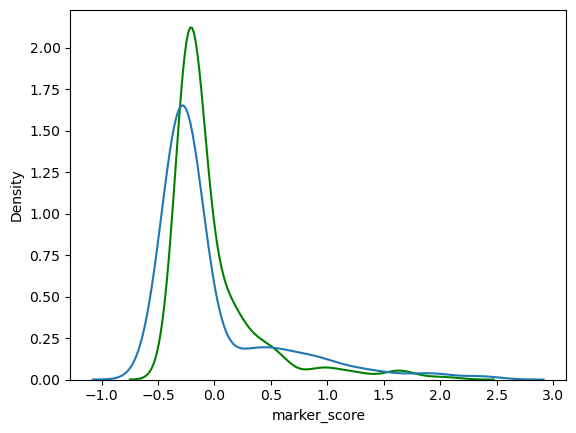

In [33]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [34]:
importances_cb = best_model_cb.feature_importances_
importances_cb = pd.Series(importances_cb, index=prot.columns)
importances_cb=importances_cb.sort_values(ascending=False)

print(importances_cb.head(10))

CD16         24.549087
CD62L        18.499746
CD44         12.643798
HLA-A-B-C     2.831006
CD56          2.362346
CD94          2.335548
CD54          1.987221
CD352         1.671129
CX3CR1        1.659967
CD224         1.481380
dtype: float64


In [35]:
#df from the top 20 important markers
importances_cb=pd.DataFrame(importances_cb)
importances_cb_top=importances_cb[0:20]
importances_cb_top=importances_cb_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


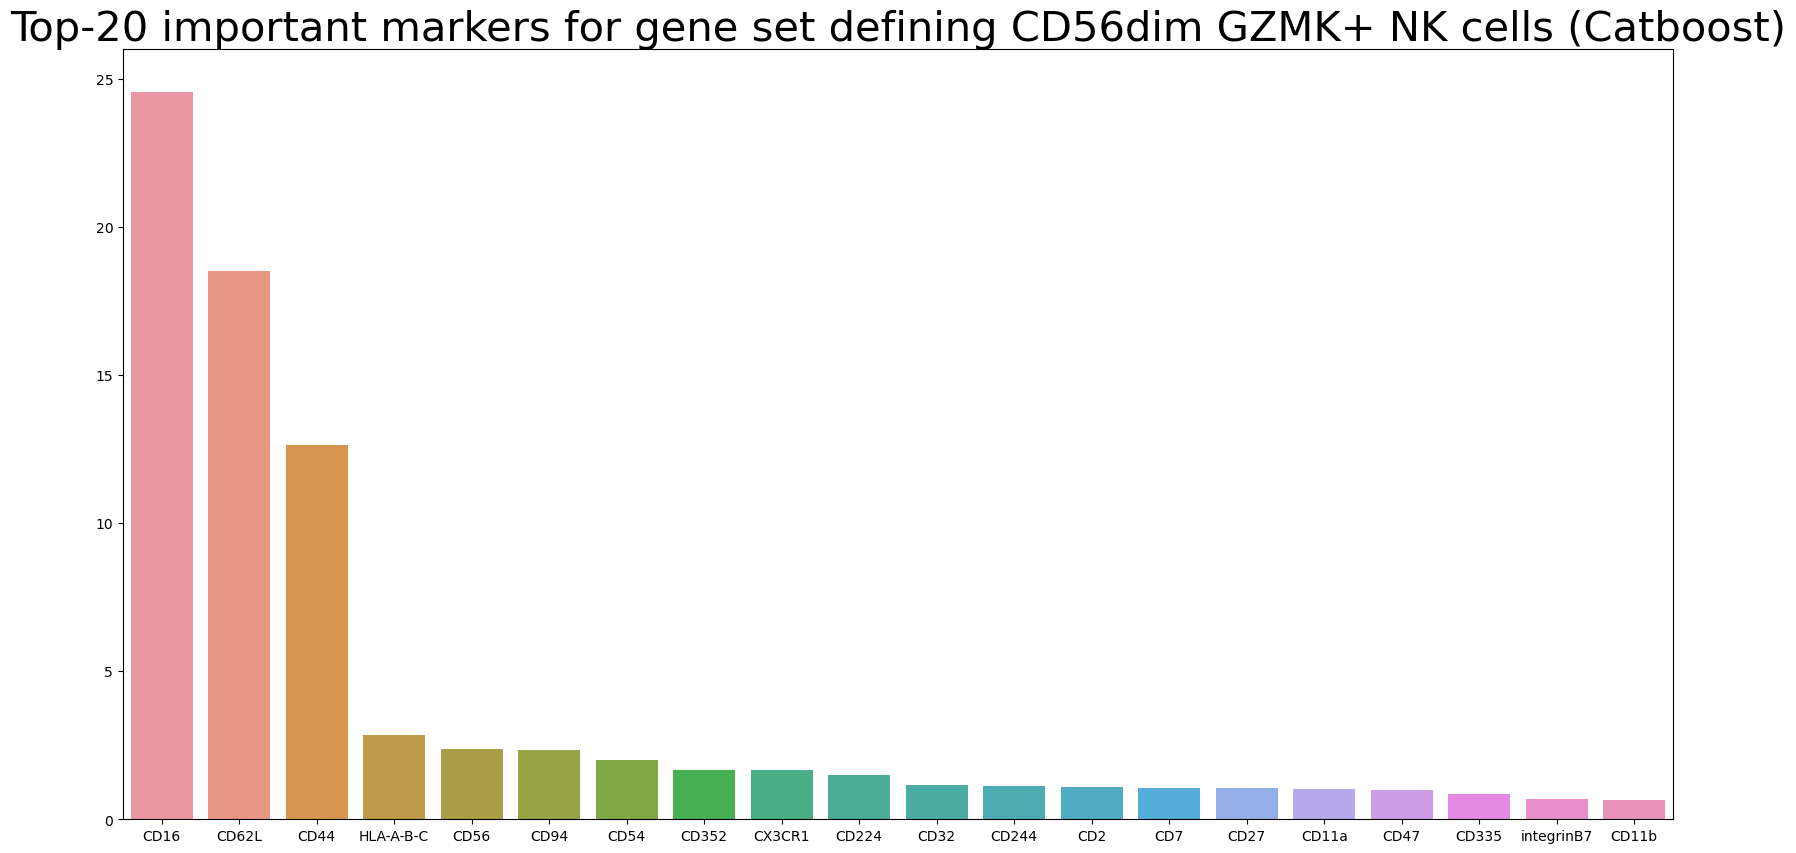

In [36]:
plt.figure(figsize=(20,10))
plt.ylim(0,26)
a=sb.barplot(data=importances_cb_top)

plt.title("Top-20 important markers for gene set defining CD56dim GZMK+ NK cells (Catboost)", fontsize = 30) ;




## 5. UMAP visualization

In [80]:
markers_prot = ['CD16', 'CD62L', 'CD44', 'HLA-A-B-C', 'CD56', 'CD94', 'CD54', 'CD352', 'CX3CR1', 'CD224_prot']


In [61]:
#Computing a neighborhood of observations using latent space

sc.pp.neighbors(adata_neurips, use_rep="X_totalVI")   

sc.tl.umap(adata_neurips)

In [62]:
#selecting one sample from Neurips

sample =eg[eg.obs['POOL'] == "s4d1"].copy()


In [63]:
sample

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47_prot', 'CD48', 'CD40', 'CD154', 'CD52_prot', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


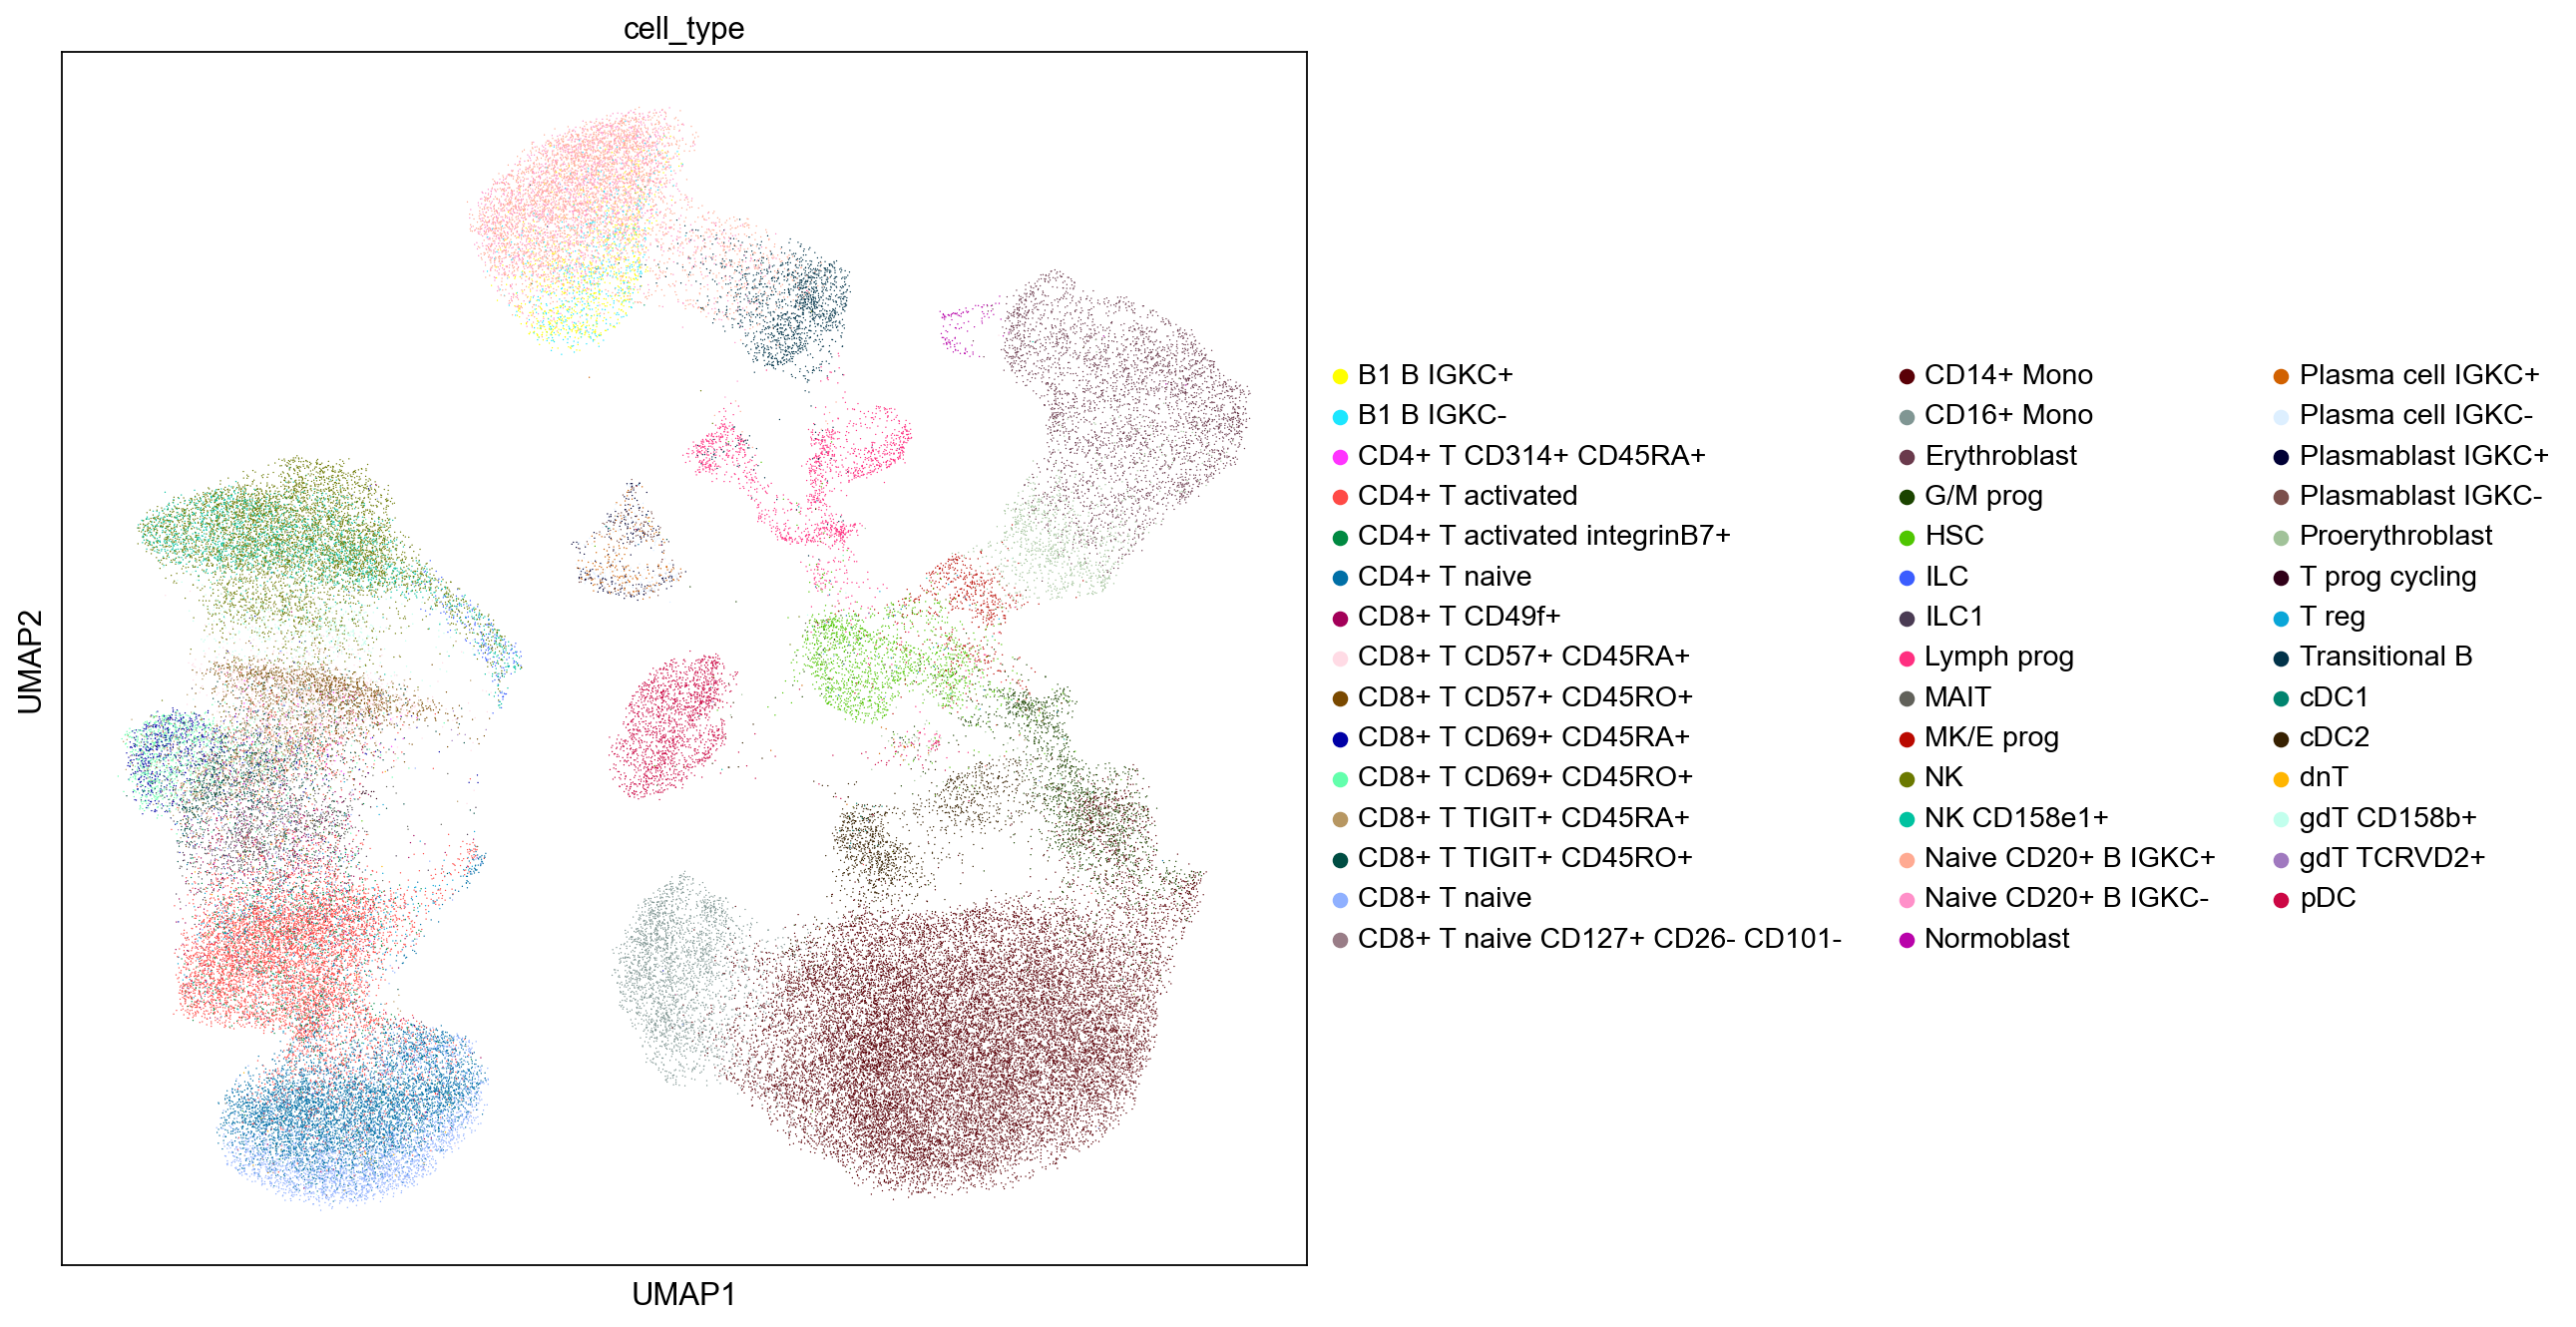

In [64]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_neurips, color = ['cell_type'])

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


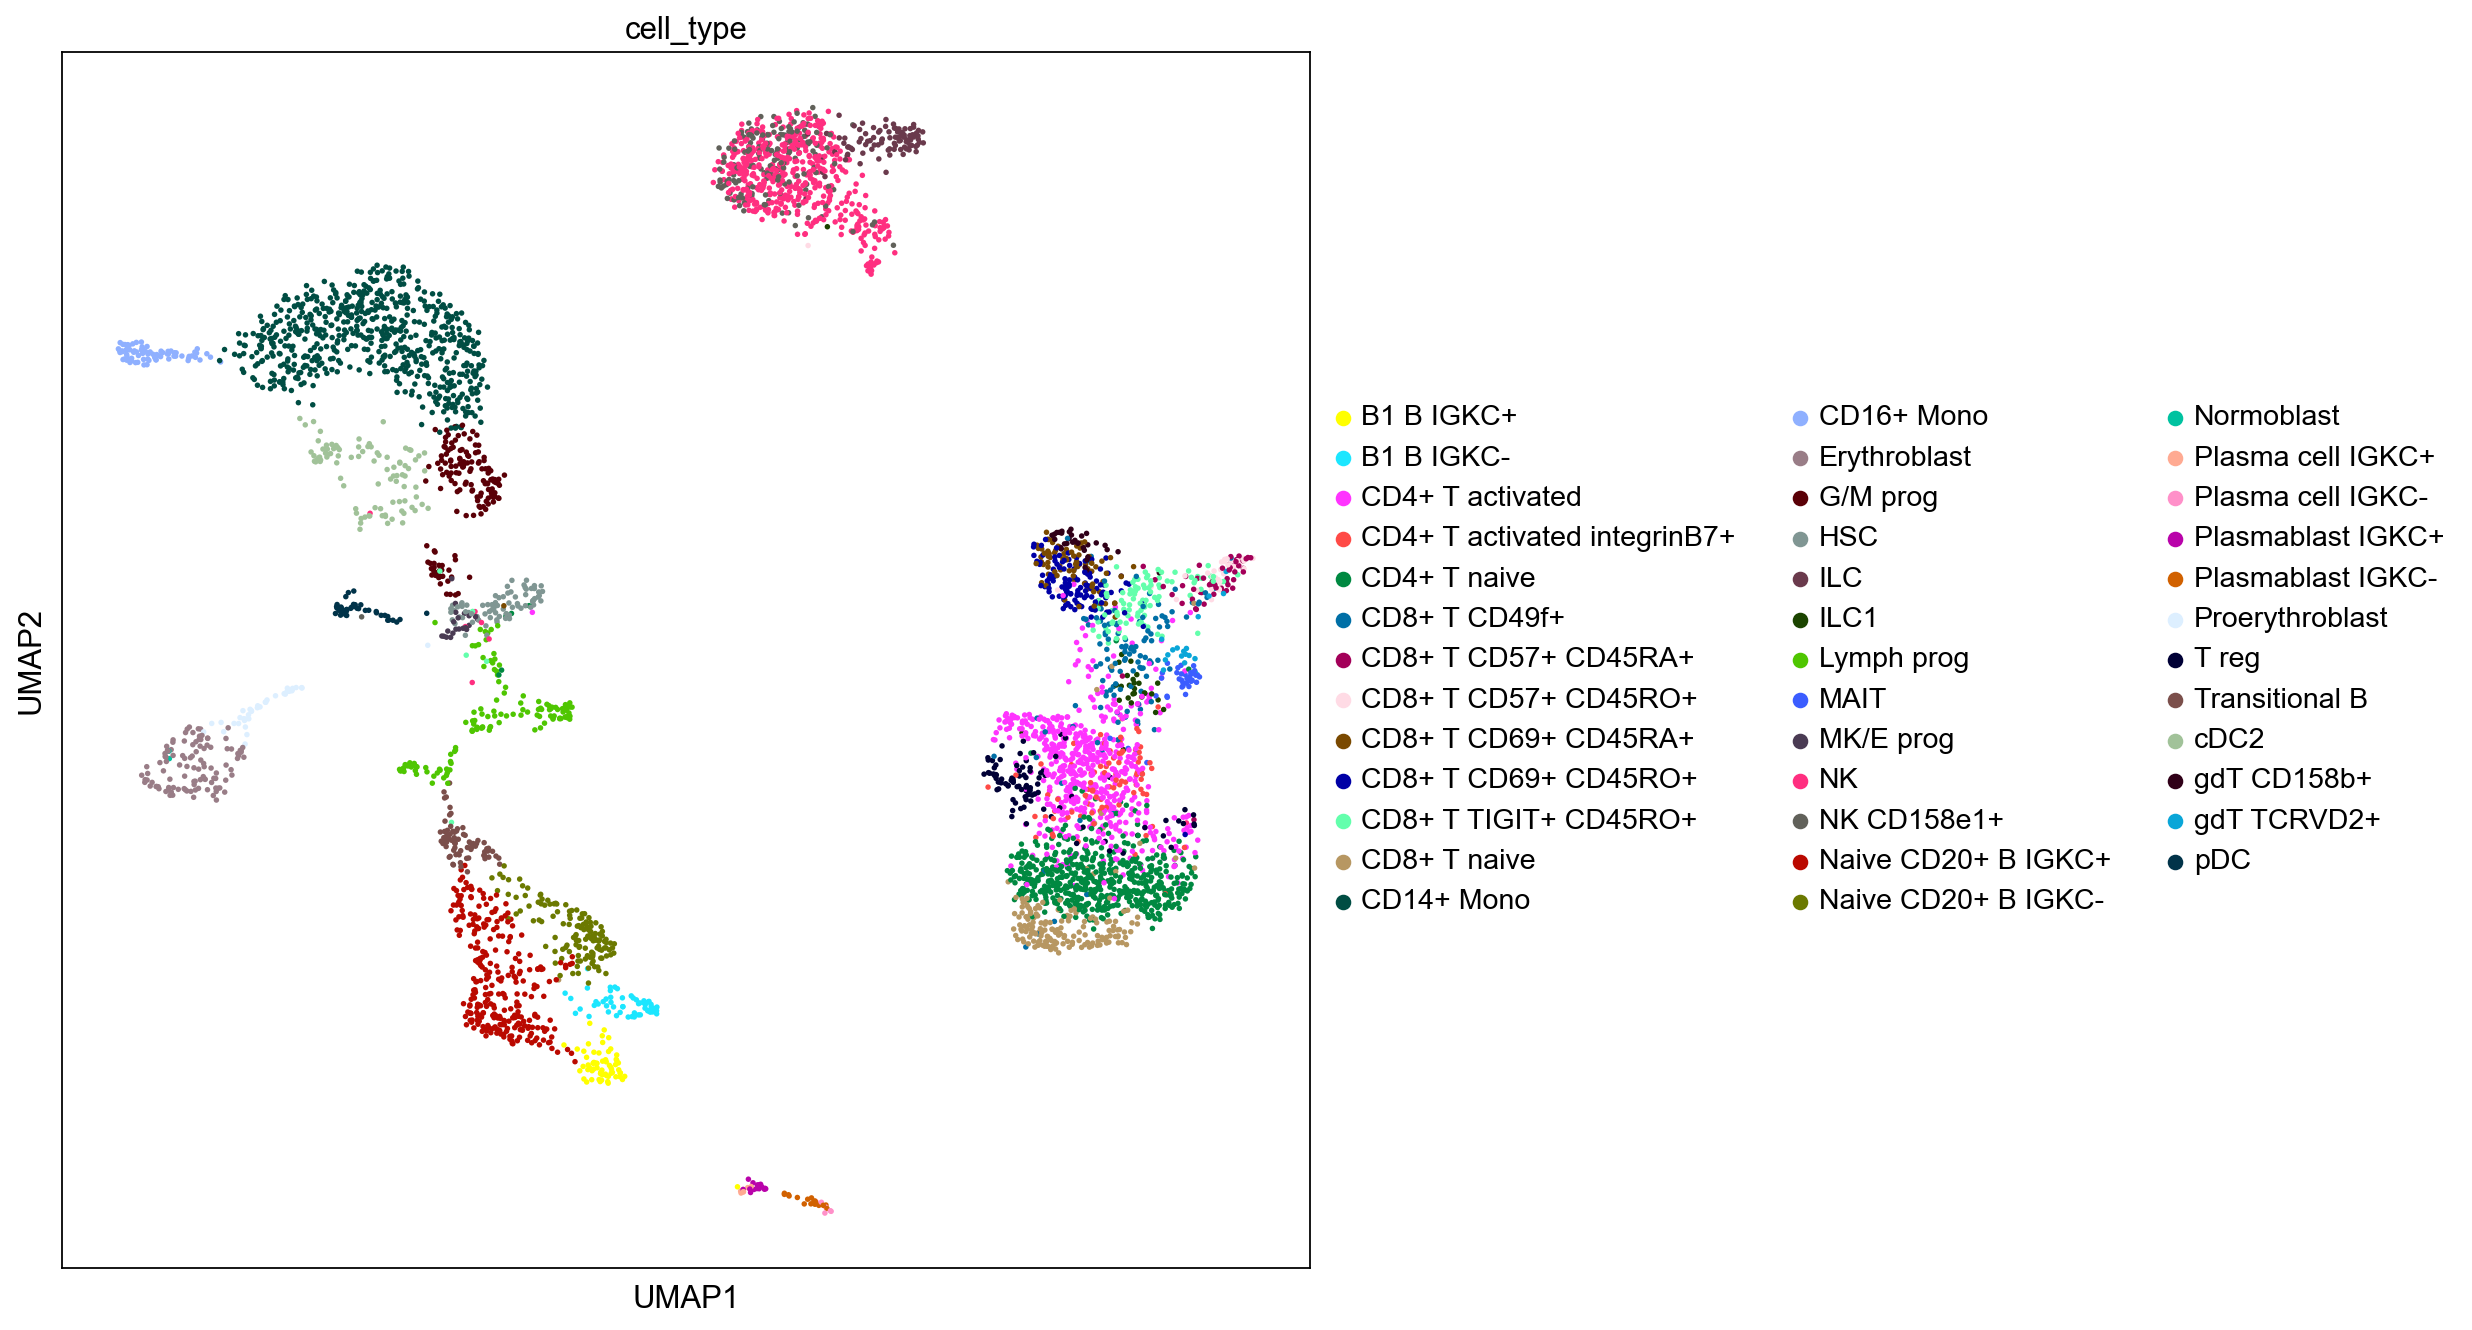

In [65]:
#only one sample

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample, color = ['cell_type'])

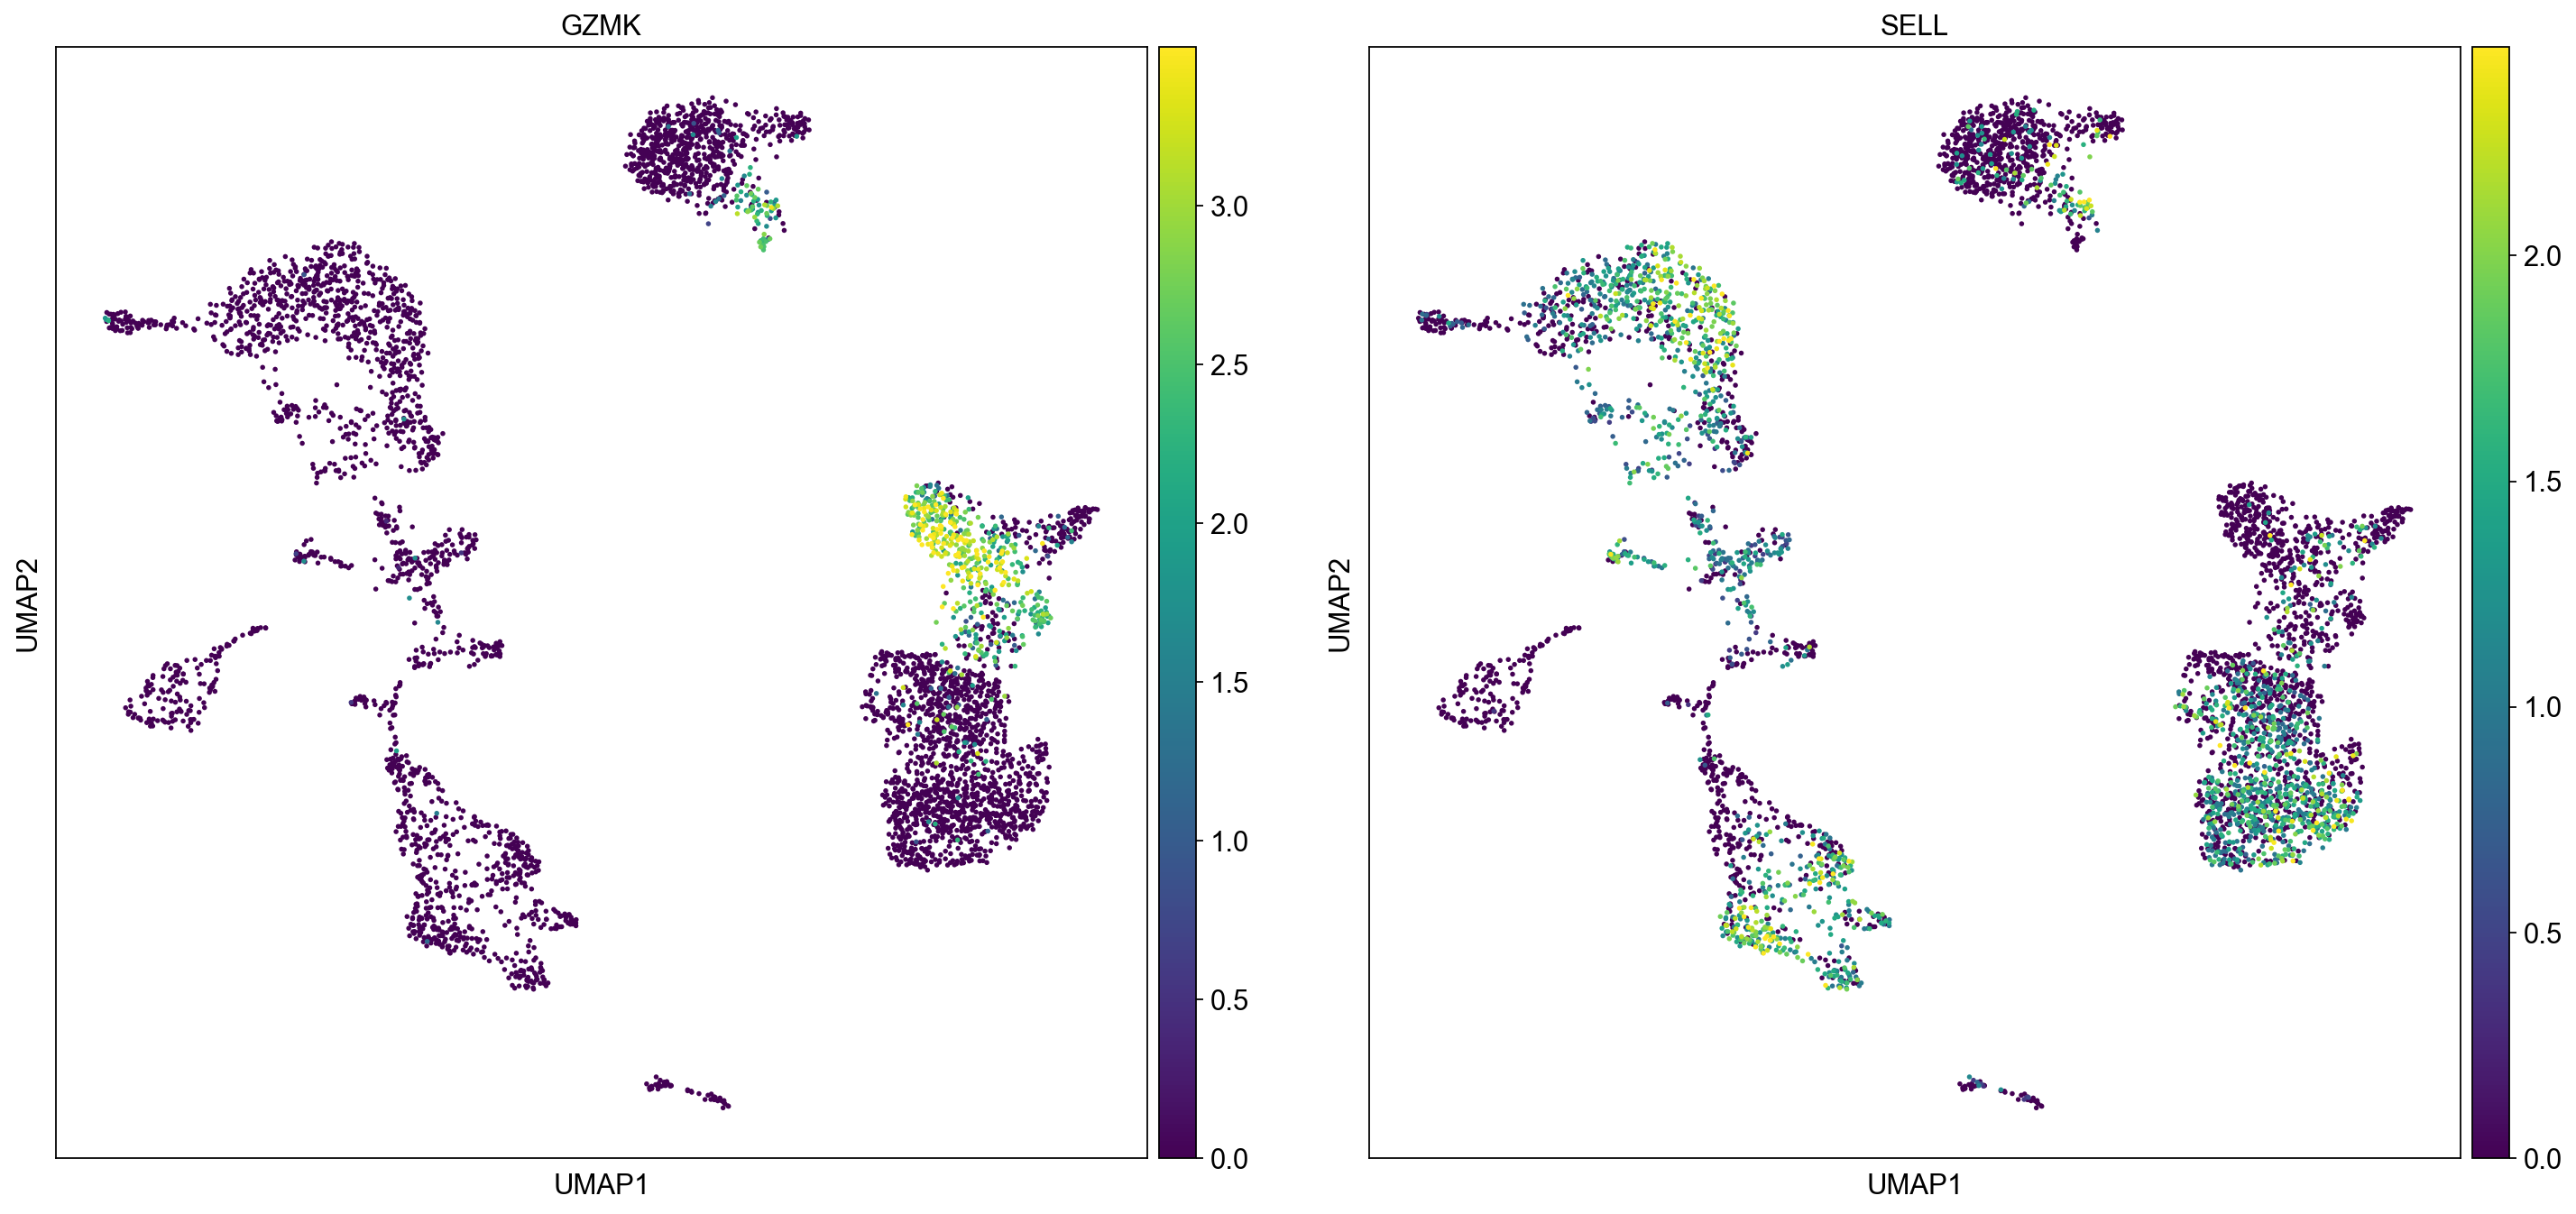

In [66]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample, color = markers,  vmax="p99", ncols = 2)

UMAPs above represent RNA markers for CD56dim GZMK+ NK cells (according to Melsen et al., paper). 

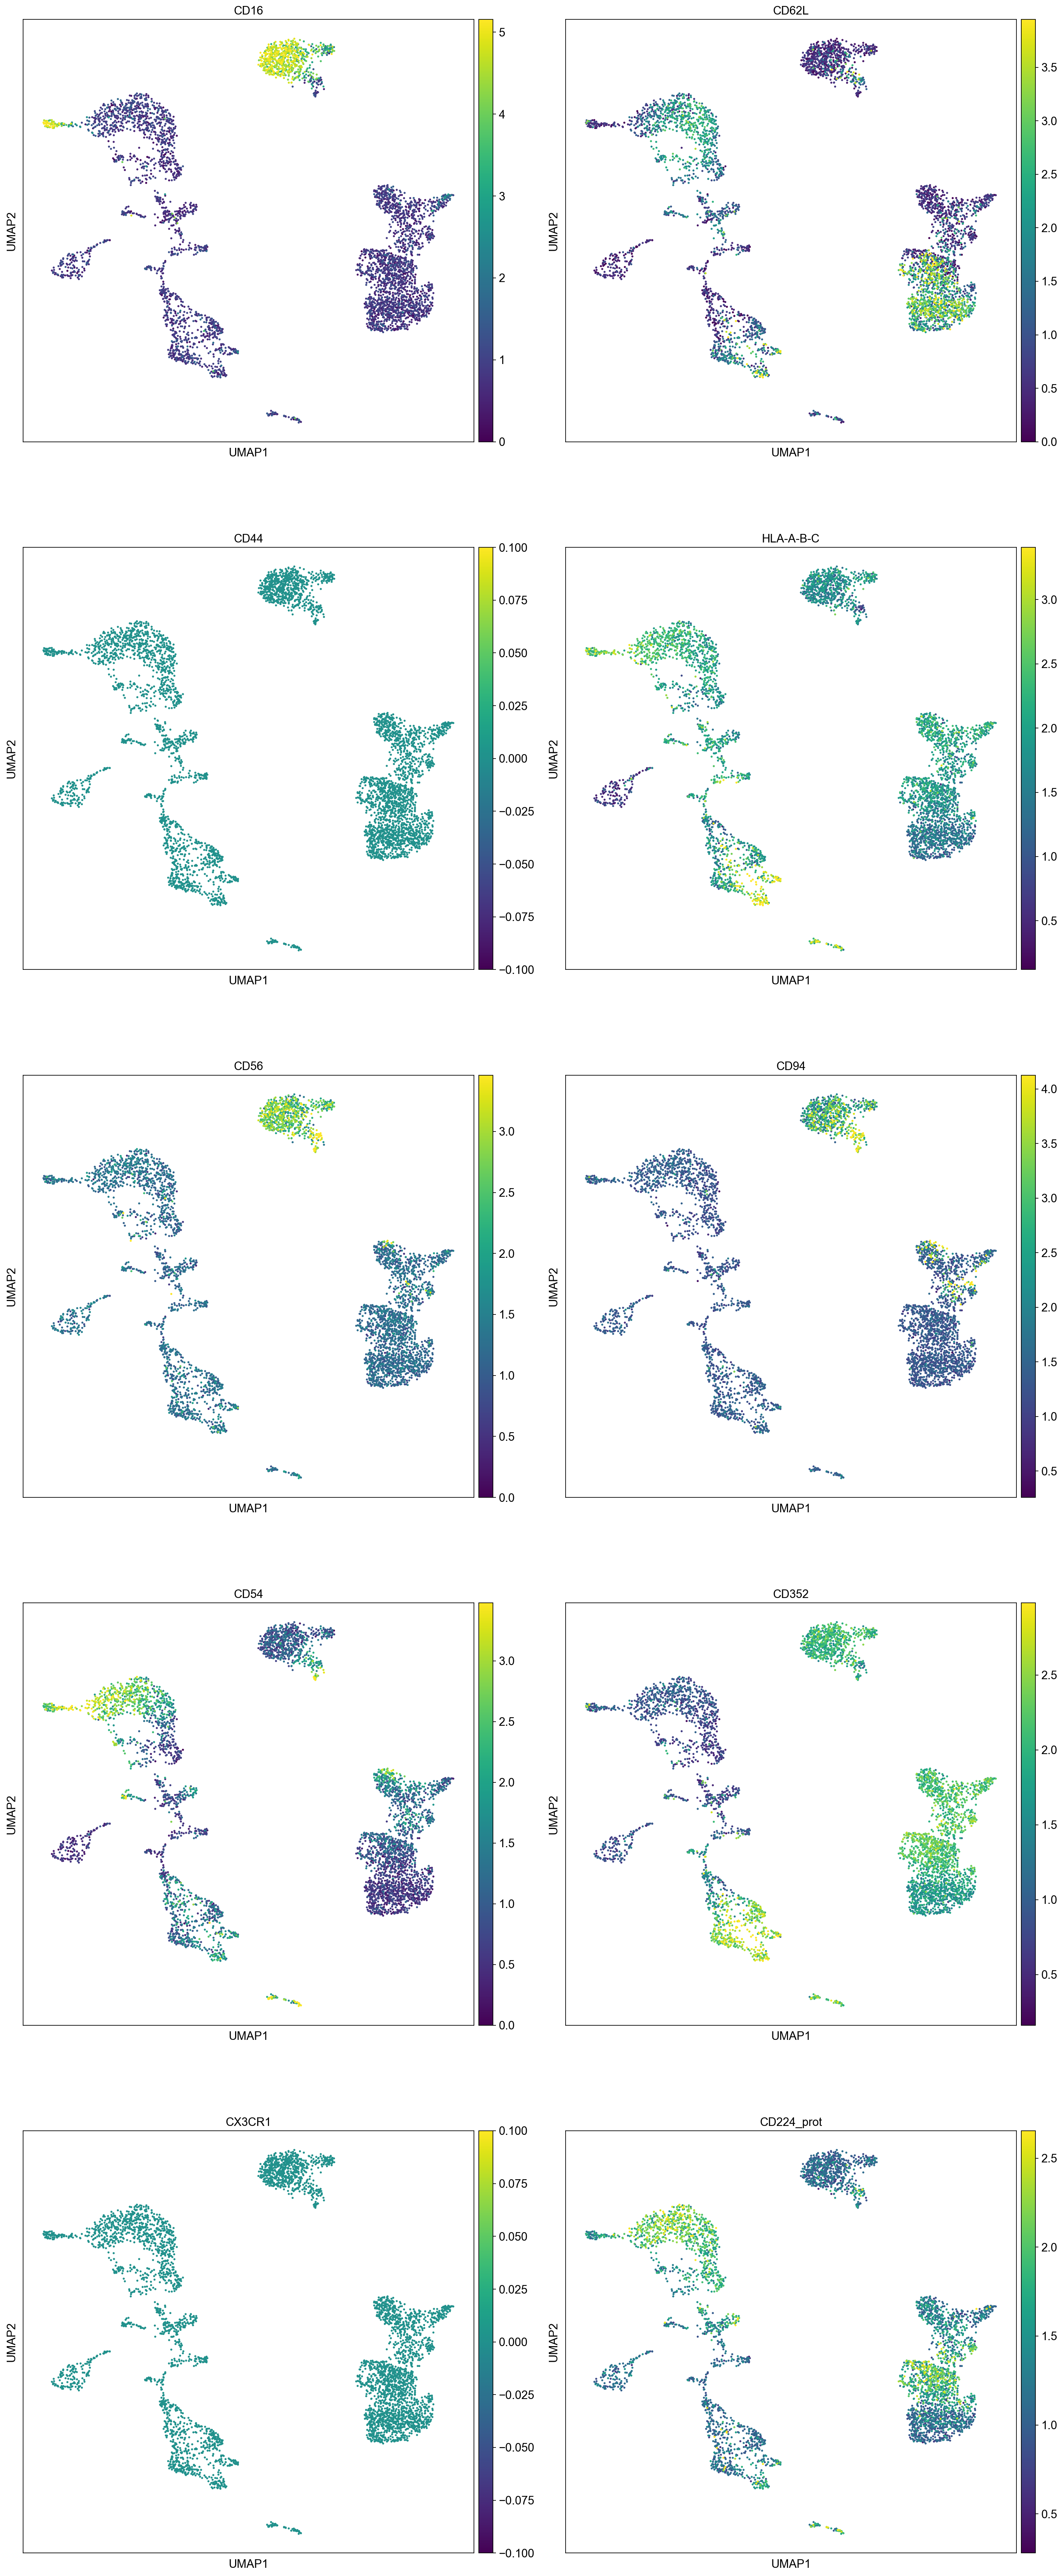

In [81]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample, color = markers_prot,  vmax="p99", ncols = 2)

Markers above are important features (surface proteins) identified by CatBoostReggressor. 